In [1]:
!export AUTOGRAPH_VERBOSITY=0
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import tensorflow as tf 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# tf.compat.v1.logging.set_verbosity(100)

In [2]:
%load_ext autoreload
%autoreload 2
import cantera as ct
import os
import gym 
import numpy as np 
import pandas as pd
from stable_baselines.common.policies import MlpPolicy, CnnLstmPolicy,MlpLstmPolicy
from stable_baselines.common.vec_env import SubprocVecEnv
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.common import set_global_seeds
from stable_baselines import ACKTR, PPO2
from envs.sim_env import SimEnv, NO_idx, CO_idx, O2_idx, H2O_idx
from envs.SimUtils import solvePhi_airSplit, equil, runMainBurner, correctNOx
import seaborn as sns

In [3]:
model = PPO2.load(f"Trained Models/PPO2_MlpLstmPolicy_461e7ff_11202019_320000.zip")

In [4]:
from stable_baselines.common.vec_env import DummyVecEnv
sim_env = SimEnv()
env = DummyVecEnv([lambda: sim_env])
# env = SimEnv()
obs = env.reset()
env.action_space.high

array([17733.37587108,  1690.62375258,  9642.49689204])

In [5]:
model.set_env(env)

In [6]:
game_over = False
results_list = []
while not game_over: 
    action, _states = model.predict(obs)
#     action = env.action_space.high[np.newaxis,:]
#     action = env.action_space.high[np.newaxis,:]
    obs, rewards, game_over, info = env.step(action)
    env.render(mode='human')
    g = env.envs[0].sec_stage_gas
    results_list.append([
        env.envs[0].age/1e-3, 
        g.T, 
        correctNOx(g.X[NO_idx], g.X[H2O_idx], g.X[O2_idx]),
        correctNOx(g.X[CO_idx], g.X[H2O_idx], g.X[O2_idx]),
        env.envs[0].mfc_main.mdot(0),
        env.envs[0].mfc_fuel_sec.mdot(0),
        env.envs[0].mfc_air_sec.mdot(0), 
        env.envs[0].remaining_main_burner_mass,
        env.envs[0].sec_fuel_remaining,
        env.envs[0].sec_air_remaining,
        rewards, ])

step|age_(ms)|T|phi_norm|NO|CO|Rem_Main|Rem_SecFuel|Rem_SecAir|Mdot_Main|Mdot_SecFuel|Mdot_SecAir|Max_Main|Max_SecFuel|Max_SecAir|Reward|Reward_Reactants|Reward_T|Reward_NO|Reward_CO
1| 0.00| 333.43| 0.99| 0.00| 0.01| 88.67| 1.69| 9.64| 0.08| 2.46| 0.24| 17733.38| 1690.62| 9642.50| 36.41|0.00| -462.36|498.76|0.00
2| 0.00| 589.41| 0.96| 0.01| 0.14| 88.67| 1.69| 9.64| 2.02| 0.53| 0.85| 17733.38| 1690.62| 9642.50| 77.86|0.00| -420.90|498.76|0.00
3| 0.00| 589.41| 0.96| 0.01| 0.14| 88.67| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 77.86|0.00| -420.90|498.76|0.00
4| 0.00| 591.22| 0.95| 0.01| 0.14| 88.67| 1.69| 9.64| 0.00| 0.00| 0.39| 17733.38| 1690.62| 9642.50| 78.34|0.00| -420.42|498.76|0.00
5| 0.00| 550.10| 0.95| 0.01| 0.11| 88.67| 1.69| 9.64| 0.00| 0.98| 0.81| 17733.38| 1690.62| 9642.50| 68.23|0.00| -430.53|498.76|0.00
6| 0.01| 675.15| 0.93| 0.01| 0.21| 88.67| 1.69| 9.64| 2.35| 0.08| 0.48| 17733.38| 1690.62| 9642.50| 104.54|0.00| -394.21|498.76|0.00
7| 0.01| 687.91| 0.92| 0

64| 0.06| 804.79| 0.84| 0.02| 0.36| 88.67| 1.69| 9.64| 1.52| 0.00| 0.32| 17733.38| 1690.62| 9642.50| 161.56|0.00| -337.19|498.75|0.00
65| 0.06| 804.17| 0.84| 0.02| 0.35| 88.67| 1.69| 9.64| 0.08| 0.14| 0.08| 17733.38| 1690.62| 9642.50| 161.24|0.00| -337.51|498.75|0.00
66| 0.07| 799.57| 0.85| 0.02| 0.35| 88.67| 1.69| 9.64| 1.02| 1.17| 1.51| 17733.38| 1690.62| 9642.50| 158.88|0.00| -339.88|498.75|0.00
67| 0.07| 799.57| 0.85| 0.02| 0.35| 88.67| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 158.88|0.00| -339.88|498.75|0.00
68| 0.07| 800.48| 0.84| 0.02| 0.35| 88.67| 1.69| 9.64| 0.45| 0.00| 0.91| 17733.38| 1690.62| 9642.50| 159.34|0.00| -339.41|498.75|0.00
69| 0.07| 805.42| 0.84| 0.02| 0.36| 88.67| 1.69| 9.64| 1.53| 0.00| 0.09| 17733.38| 1690.62| 9642.50| 161.89|0.00| -336.87|498.75|0.00
70| 0.07| 805.26| 0.84| 0.02| 0.35| 88.67| 1.69| 9.64| 1.38| 0.78| 0.00| 17733.38| 1690.62| 9642.50| 161.81|0.00| -336.95|498.75|0.00
71| 0.07| 801.12| 0.84| 0.02| 0.35| 88.67| 1.69| 9.64| 0.00| 0

125| 0.12| 791.68| 0.85| 0.02| 0.32| 88.67| 1.69| 9.64| 0.00| 1.05| 0.05| 17733.38| 1690.62| 9642.50| 154.87|0.00| -343.88|498.75|0.00
126| 0.13| 789.91| 0.85| 0.02| 0.32| 88.67| 1.69| 9.64| 0.00| 0.37| 1.75| 17733.38| 1690.62| 9642.50| 153.99|0.00| -344.77|498.75|0.00
127| 0.13| 789.87| 0.85| 0.02| 0.32| 88.67| 1.69| 9.64| 0.00| 0.00| 0.12| 17733.38| 1690.62| 9642.50| 153.97|0.00| -344.79|498.75|0.00
128| 0.13| 787.37| 0.84| 0.02| 0.32| 88.67| 1.69| 9.64| 0.00| 0.43| 3.54| 17733.38| 1690.62| 9642.50| 152.72|0.00| -346.03|498.75|0.00
129| 0.13| 783.17| 0.85| 0.02| 0.32| 88.67| 1.69| 9.64| 0.00| 1.34| 0.00| 17733.38| 1690.62| 9642.50| 150.64|0.00| -348.12|498.75|0.00
130| 0.13| 783.11| 0.85| 0.02| 0.32| 88.67| 1.69| 9.64| 0.00| 0.00| 0.20| 17733.38| 1690.62| 9642.50| 150.61|0.00| -348.15|498.75|0.00
131| 0.13| 779.46| 0.85| 0.02| 0.31| 88.67| 1.69| 9.64| 0.57| 1.27| 2.72| 17733.38| 1690.62| 9642.50| 148.82|0.00| -349.93|498.75|0.00
132| 0.13| 777.27| 0.85| 0.02| 0.31| 88.67| 1.69| 9.64|

191| 0.19| 765.54| 0.84| 0.02| 0.29| 88.67| 1.69| 9.64| 0.34| 1.11| 1.62| 17733.38| 1690.62| 9642.50| 142.14|0.00| -356.61|498.75|0.00
192| 0.19| 765.82| 0.84| 0.02| 0.29| 88.67| 1.69| 9.64| 0.21| 0.00| 0.03| 17733.38| 1690.62| 9642.50| 142.27|0.00| -356.48|498.75|0.00
193| 0.19| 765.94| 0.84| 0.02| 0.29| 88.67| 1.69| 9.64| 0.24| 0.00| 1.14| 17733.38| 1690.62| 9642.50| 142.32|0.00| -356.43|498.75|0.00
194| 0.19| 768.00| 0.84| 0.02| 0.29| 88.67| 1.69| 9.64| 1.57| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 143.30|0.00| -355.45|498.75|0.00
195| 0.19| 768.00| 0.84| 0.02| 0.29| 88.67| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 143.30|0.00| -355.45|498.75|0.00
196| 0.20| 767.32| 0.84| 0.02| 0.29| 88.67| 1.69| 9.64| 1.02| 0.98| 0.00| 17733.38| 1690.62| 9642.50| 142.98|0.00| -355.77|498.75|0.00
197| 0.20| 767.77| 0.84| 0.02| 0.29| 88.67| 1.69| 9.64| 1.76| 0.90| 0.00| 17733.38| 1690.62| 9642.50| 143.19|0.00| -355.56|498.75|0.00
198| 0.20| 767.41| 0.84| 0.02| 0.29| 88.67| 1.69| 9.64|

257| 0.26| 749.80| 0.85| 0.02| 0.25| 88.67| 1.69| 9.64| 0.45| 0.00| 0.44| 17733.38| 1690.62| 9642.50| 134.86|0.01| -363.89|498.76|0.00
258| 0.26| 748.73| 0.85| 0.02| 0.25| 88.67| 1.69| 9.64| 1.09| 1.49| 0.16| 17733.38| 1690.62| 9642.50| 134.37|0.01| -364.37|498.76|0.00
259| 0.26| 748.52| 0.85| 0.02| 0.25| 88.67| 1.69| 9.64| 0.99| 0.77| 0.77| 17733.38| 1690.62| 9642.50| 134.28|0.01| -364.46|498.76|0.00
260| 0.26| 749.66| 0.85| 0.02| 0.25| 88.67| 1.69| 9.64| 1.26| 0.00| 0.78| 17733.38| 1690.62| 9642.50| 134.79|0.01| -363.95|498.76|0.00
261| 0.26| 750.41| 0.85| 0.02| 0.25| 88.67| 1.69| 9.64| 0.82| 0.00| 0.39| 17733.38| 1690.62| 9642.50| 135.13|0.01| -363.61|498.76|0.00
262| 0.26| 750.52| 0.85| 0.02| 0.25| 88.67| 1.69| 9.64| 0.24| 0.00| 1.00| 17733.38| 1690.62| 9642.50| 135.18|0.01| -363.56|498.76|0.00
263| 0.26| 749.75| 0.85| 0.02| 0.25| 88.67| 1.69| 9.64| 1.45| 1.36| 2.25| 17733.38| 1690.62| 9642.50| 134.83|0.01| -363.91|498.76|0.00
264| 0.26| 749.98| 0.85| 0.02| 0.25| 88.67| 1.69| 9.64|

325| 0.33| 764.19| 0.84| 0.02| 0.25| 88.67| 1.69| 9.64| 0.38| 0.22| 0.68| 17733.38| 1690.62| 9642.50| 141.48|0.01| -357.25|498.76|0.00
326| 0.33| 765.20| 0.84| 0.02| 0.25| 88.67| 1.69| 9.64| 1.30| 0.00| 0.01| 17733.38| 1690.62| 9642.50| 141.95|0.01| -356.78|498.75|0.00
327| 0.33| 766.10| 0.84| 0.02| 0.25| 88.67| 1.69| 9.64| 1.55| 0.15| 1.03| 17733.38| 1690.62| 9642.50| 142.38|0.01| -356.35|498.75|0.00
328| 0.33| 767.29| 0.84| 0.02| 0.25| 88.67| 1.69| 9.64| 1.62| 0.00| 0.55| 17733.38| 1690.62| 9642.50| 142.94|0.01| -355.79|498.75|0.00
329| 0.33| 767.92| 0.84| 0.02| 0.25| 88.67| 1.69| 9.64| 1.65| 0.53| 0.07| 17733.38| 1690.62| 9642.50| 143.24|0.01| -355.49|498.75|0.00
330| 0.33| 769.24| 0.84| 0.02| 0.26| 88.67| 1.69| 9.64| 2.41| 0.23| 2.25| 17733.38| 1690.62| 9642.50| 143.86|0.01| -354.86|498.75|0.00
331| 0.33| 768.69| 0.84| 0.02| 0.26| 88.67| 1.69| 9.64| 0.00| 0.38| 0.89| 17733.38| 1690.62| 9642.50| 143.60|0.01| -355.12|498.75|0.00
332| 0.33| 767.03| 0.84| 0.02| 0.25| 88.67| 1.69| 9.64|

394| 0.39| 764.49| 0.84| 0.02| 0.24| 88.67| 1.69| 9.64| 2.14| 0.00| 2.62| 17733.38| 1690.62| 9642.50| 141.59|0.01| -357.11|498.76|0.00
395| 0.40| 763.92| 0.84| 0.02| 0.24| 88.67| 1.69| 9.64| 0.29| 0.57| 2.40| 17733.38| 1690.62| 9642.50| 141.32|0.01| -357.38|498.76|0.00
396| 0.40| 763.86| 0.84| 0.02| 0.24| 88.67| 1.69| 9.64| 0.40| 0.31| 0.20| 17733.38| 1690.62| 9642.50| 141.29|0.01| -357.41|498.76|0.00
397| 0.40| 763.74| 0.84| 0.02| 0.24| 88.67| 1.69| 9.64| 0.00| 0.00| 1.37| 17733.38| 1690.62| 9642.50| 141.24|0.01| -357.46|498.76|0.00
398| 0.40| 763.98| 0.84| 0.02| 0.24| 88.67| 1.69| 9.64| 0.67| 0.18| 0.00| 17733.38| 1690.62| 9642.50| 141.35|0.01| -357.35|498.76|0.00
399| 0.40| 763.30| 0.84| 0.02| 0.24| 88.67| 1.69| 9.64| 0.88| 1.09| 2.18| 17733.38| 1690.62| 9642.50| 141.03|0.01| -357.67|498.76|0.00
400| 0.40| 761.47| 0.85| 0.02| 0.23| 88.67| 1.69| 9.64| 0.00| 1.84| 1.02| 17733.38| 1690.62| 9642.50| 140.17|0.01| -358.53|498.76|0.00
401| 0.40| 762.18| 0.84| 0.02| 0.23| 88.67| 1.69| 9.64|

464| 0.46| 771.22| 0.84| 0.02| 0.23| 88.67| 1.69| 9.64| 0.49| 0.79| 0.00| 17733.38| 1690.62| 9642.50| 144.75|0.01| -353.92|498.75|0.00
465| 0.47| 770.99| 0.84| 0.02| 0.23| 88.67| 1.69| 9.64| 1.36| 1.06| 0.79| 17733.38| 1690.62| 9642.50| 144.63|0.01| -354.03|498.75|0.00
466| 0.47| 770.02| 0.84| 0.02| 0.23| 88.67| 1.69| 9.64| 0.56| 1.34| 1.89| 17733.38| 1690.62| 9642.50| 144.17|0.01| -354.49|498.75|0.00
467| 0.47| 770.09| 0.84| 0.02| 0.23| 88.67| 1.69| 9.64| 0.57| 0.27| 0.00| 17733.38| 1690.62| 9642.50| 144.21|0.01| -354.46|498.75|0.00
468| 0.47| 769.18| 0.84| 0.02| 0.23| 88.67| 1.69| 9.64| 0.00| 1.00| 1.13| 17733.38| 1690.62| 9642.50| 143.77|0.01| -354.89|498.75|0.00
469| 0.47| 770.28| 0.84| 0.02| 0.23| 88.67| 1.69| 9.64| 2.09| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 144.29|0.01| -354.37|498.75|0.00
470| 0.47| 769.86| 0.84| 0.02| 0.23| 88.67| 1.69| 9.64| 1.13| 1.03| 2.03| 17733.38| 1690.62| 9642.50| 144.09|0.01| -354.57|498.75|0.00
471| 0.47| 770.14| 0.84| 0.02| 0.23| 88.67| 1.69| 9.64|

537| 0.54| 765.94| 0.84| 0.02| 0.22| 88.67| 1.69| 9.64| 1.57| 1.82| 2.14| 17733.38| 1690.62| 9642.50| 142.18|0.01| -356.43|498.75|0.00
538| 0.54| 766.70| 0.84| 0.02| 0.22| 88.67| 1.69| 9.64| 1.95| 0.11| 0.84| 17733.38| 1690.62| 9642.50| 142.54|0.01| -356.07|498.75|0.00
539| 0.54| 765.53| 0.84| 0.02| 0.21| 88.67| 1.69| 9.64| 0.52| 1.76| 2.38| 17733.38| 1690.62| 9642.50| 141.99|0.01| -356.62|498.76|0.00
540| 0.54| 766.67| 0.84| 0.02| 0.21| 88.67| 1.69| 9.64| 2.48| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 142.53|0.01| -356.08|498.75|0.00
541| 0.54| 766.62| 0.84| 0.02| 0.21| 88.67| 1.69| 9.64| 0.62| 0.20| 3.07| 17733.38| 1690.62| 9642.50| 142.50|0.01| -356.11|498.75|0.00
542| 0.54| 764.95| 0.84| 0.02| 0.21| 88.67| 1.69| 9.64| 0.00| 2.26| 0.95| 17733.38| 1690.62| 9642.50| 141.71|0.01| -356.90|498.76|0.00
543| 0.54| 765.20| 0.84| 0.02| 0.21| 88.67| 1.69| 9.64| 0.86| 0.06| 1.47| 17733.38| 1690.62| 9642.50| 141.83|0.01| -356.78|498.76|0.00
544| 0.54| 764.13| 0.84| 0.02| 0.21| 88.67| 1.69| 9.64|

610| 0.61| 762.76| 0.85| 0.02| 0.20| 88.67| 1.69| 9.64| 3.45| 0.00| 2.32| 17733.38| 1690.62| 9642.50| 140.62|0.01| -357.92|498.76|0.00
611| 0.61| 762.13| 0.85| 0.02| 0.20| 88.67| 1.69| 9.64| 0.56| 1.37| 0.16| 17733.38| 1690.62| 9642.50| 140.32|0.01| -358.22|498.76|0.00
612| 0.61| 762.32| 0.85| 0.02| 0.20| 88.67| 1.69| 9.64| 0.75| 0.00| 2.08| 17733.38| 1690.62| 9642.50| 140.41|0.01| -358.13|498.76|0.00
613| 0.61| 762.93| 0.85| 0.02| 0.20| 88.67| 1.69| 9.64| 1.82| 0.17| 0.29| 17733.38| 1690.62| 9642.50| 140.70|0.01| -357.84|498.76|0.00
614| 0.61| 762.90| 0.84| 0.02| 0.20| 88.67| 1.69| 9.64| 0.00| 0.00| 0.53| 17733.38| 1690.62| 9642.50| 140.68|0.01| -357.86|498.76|0.00
615| 0.62| 763.59| 0.84| 0.02| 0.20| 88.67| 1.69| 9.64| 1.85| 0.08| 0.00| 17733.38| 1690.62| 9642.50| 141.00|0.01| -357.53|498.76|0.00
616| 0.62| 763.28| 0.85| 0.02| 0.20| 88.67| 1.69| 9.64| 1.00| 1.08| 0.76| 17733.38| 1690.62| 9642.50| 140.86|0.01| -357.68|498.76|0.00
617| 0.62| 763.71| 0.84| 0.02| 0.20| 88.67| 1.69| 9.64|

681| 0.68| 764.94| 0.84| 0.02| 0.19| 88.67| 1.69| 9.64| 0.78| 0.52| 0.00| 17733.38| 1690.62| 9642.50| 141.56|0.01| -356.90|498.76|0.00
682| 0.68| 765.04| 0.84| 0.02| 0.19| 88.67| 1.69| 9.64| 0.31| 0.00| 0.34| 17733.38| 1690.62| 9642.50| 141.60|0.01| -356.85|498.76|0.00
683| 0.68| 764.88| 0.84| 0.02| 0.19| 88.67| 1.69| 9.64| 0.00| 0.15| 1.51| 17733.38| 1690.62| 9642.50| 141.53|0.01| -356.93|498.76|0.00
684| 0.68| 764.74| 0.84| 0.02| 0.19| 88.67| 1.69| 9.64| 0.05| 0.21| 0.89| 17733.38| 1690.62| 9642.50| 141.46|0.01| -356.99|498.76|0.00
685| 0.69| 764.71| 0.84| 0.02| 0.19| 88.67| 1.69| 9.64| 0.00| 0.00| 0.59| 17733.38| 1690.62| 9642.50| 141.44|0.01| -357.01|498.76|0.00
686| 0.69| 764.71| 0.84| 0.02| 0.19| 88.67| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 141.44|0.01| -357.01|498.76|0.00
687| 0.69| 764.67| 0.84| 0.02| 0.19| 88.67| 1.69| 9.64| 0.00| 0.00| 0.89| 17733.38| 1690.62| 9642.50| 141.42|0.01| -357.03|498.76|0.00
688| 0.69| 764.61| 0.84| 0.02| 0.19| 88.67| 1.69| 9.64|

754| 0.75| 763.33| 0.84| 0.02| 0.18| 88.67| 1.69| 9.64| 2.06| 2.05| 0.00| 17733.38| 1690.62| 9642.50| 140.69|0.02| -357.66|498.76|0.00
755| 0.76| 763.20| 0.84| 0.02| 0.18| 88.67| 1.69| 9.64| 0.00| 0.06| 2.37| 17733.38| 1690.62| 9642.50| 140.62|0.02| -357.72|498.76|0.00
756| 0.76| 762.23| 0.84| 0.02| 0.18| 88.67| 1.69| 9.64| 0.00| 1.87| 0.72| 17733.38| 1690.62| 9642.50| 140.17|0.02| -358.17|498.76|0.00
757| 0.76| 761.97| 0.84| 0.02| 0.18| 88.67| 1.69| 9.64| 0.00| 0.50| 0.03| 17733.38| 1690.62| 9642.50| 140.05|0.02| -358.29|498.76|0.00
758| 0.76| 761.97| 0.84| 0.02| 0.18| 88.67| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 140.05|0.02| -358.29|498.76|0.00
759| 0.76| 761.66| 0.84| 0.02| 0.18| 88.67| 1.69| 9.64| 1.09| 1.17| 2.05| 17733.38| 1690.62| 9642.50| 139.90|0.02| -358.44|498.76|0.00
760| 0.76| 762.05| 0.84| 0.02| 0.18| 88.67| 1.69| 9.64| 1.19| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 140.08|0.02| -358.26|498.76|0.00
761| 0.76| 762.05| 0.84| 0.02| 0.18| 88.67| 1.69| 9.64|

828| 0.83| 762.70| 0.84| 0.02| 0.17| 88.67| 1.69| 9.64| 1.55| 0.63| 1.13| 17733.38| 1690.62| 9642.50| 140.26|0.02| -357.95|498.76|0.00
829| 0.83| 762.11| 0.84| 0.02| 0.17| 88.67| 1.69| 9.64| 0.00| 1.07| 2.55| 17733.38| 1690.62| 9642.50| 139.98|0.02| -358.23|498.76|0.00
830| 0.83| 762.01| 0.84| 0.02| 0.17| 88.67| 1.69| 9.64| 0.37| 0.42| 0.39| 17733.38| 1690.62| 9642.50| 139.93|0.02| -358.27|498.76|0.00
831| 0.83| 762.27| 0.84| 0.02| 0.17| 88.67| 1.69| 9.64| 1.41| 0.34| 0.20| 17733.38| 1690.62| 9642.50| 140.05|0.02| -358.15|498.76|0.00
832| 0.83| 762.75| 0.84| 0.02| 0.17| 88.67| 1.69| 9.64| 1.63| 0.02| 0.00| 17733.38| 1690.62| 9642.50| 140.27|0.02| -357.93|498.76|0.00
833| 0.83| 762.86| 0.84| 0.02| 0.17| 88.67| 1.69| 9.64| 0.78| 0.27| 0.00| 17733.38| 1690.62| 9642.50| 140.32|0.02| -357.88|498.76|0.00
834| 0.83| 763.55| 0.84| 0.02| 0.17| 88.67| 1.69| 9.64| 2.43| 0.07| 0.00| 17733.38| 1690.62| 9642.50| 140.64|0.02| -357.55|498.76|0.00
835| 0.84| 763.61| 0.84| 0.02| 0.17| 88.67| 1.69| 9.64|

902| 0.90| 767.42| 0.84| 0.02| 0.17| 88.67| 1.69| 9.64| 0.00| 0.18| 2.17| 17733.38| 1690.62| 9642.50| 142.31|0.02| -355.73|498.75|0.00
903| 0.90| 767.39| 0.84| 0.02| 0.17| 88.67| 1.69| 9.64| 0.00| 0.00| 0.69| 17733.38| 1690.62| 9642.50| 142.30|0.02| -355.74|498.75|0.00
904| 0.90| 767.19| 0.84| 0.02| 0.17| 88.67| 1.69| 9.64| 1.70| 1.49| 0.74| 17733.38| 1690.62| 9642.50| 142.20|0.02| -355.83|498.76|0.00
905| 0.91| 767.50| 0.84| 0.02| 0.17| 88.67| 1.69| 9.64| 1.14| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 142.35|0.02| -355.69|498.75|0.00
906| 0.91| 768.30| 0.84| 0.02| 0.17| 88.67| 1.69| 9.64| 2.91| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 142.72|0.02| -355.31|498.75|0.00
907| 0.91| 767.63| 0.84| 0.02| 0.17| 88.67| 1.69| 9.64| 0.00| 1.45| 1.29| 17733.38| 1690.62| 9642.50| 142.40|0.02| -355.63|498.75|0.00
908| 0.91| 767.00| 0.84| 0.02| 0.17| 88.67| 1.69| 9.64| 0.27| 1.45| 2.19| 17733.38| 1690.62| 9642.50| 142.10|0.02| -355.93|498.76|0.00
909| 0.91| 767.09| 0.84| 0.02| 0.17| 88.67| 1.69| 9.64|

963| 0.96| 765.16| 0.84| 0.02| 0.16| 88.67| 1.69| 9.64| 0.92| 1.45| 0.66| 17733.38| 1690.62| 9642.50| 141.09|0.02| -356.79|498.76|0.00
964| 0.96| 765.27| 0.84| 0.02| 0.16| 88.67| 1.69| 9.64| 0.47| 0.00| 0.23| 17733.38| 1690.62| 9642.50| 141.14|0.02| -356.74|498.76|0.00
965| 0.97| 765.67| 0.84| 0.02| 0.16| 88.67| 1.69| 9.64| 1.59| 0.00| 0.29| 17733.38| 1690.62| 9642.50| 141.32|0.02| -356.55|498.76|0.00
966| 0.97| 765.77| 0.84| 0.02| 0.16| 88.67| 1.69| 9.64| 0.69| 0.11| 0.95| 17733.38| 1690.62| 9642.50| 141.37|0.02| -356.51|498.76|0.00
967| 0.97| 765.32| 0.84| 0.02| 0.16| 88.67| 1.69| 9.64| 0.00| 1.06| 0.64| 17733.38| 1690.62| 9642.50| 141.15|0.02| -356.72|498.76|0.00
968| 0.97| 766.22| 0.84| 0.02| 0.16| 88.67| 1.69| 9.64| 3.59| 0.00| 0.53| 17733.38| 1690.62| 9642.50| 141.57|0.02| -356.30|498.76|0.00
969| 0.97| 766.69| 0.84| 0.02| 0.16| 88.67| 1.69| 9.64| 3.04| 0.68| 0.92| 17733.38| 1690.62| 9642.50| 141.79|0.02| -356.07|498.76|0.00
970| 0.97| 766.91| 0.84| 0.02| 0.16| 88.67| 1.69| 9.64|

1037| 1.04| 764.85| 0.84| 0.02| 0.15| 88.67| 1.69| 9.64| 0.38| 2.13| 0.74| 17733.38| 1690.62| 9642.50| 140.72|0.02| -356.94|498.76|0.00
1038| 1.04| 764.70| 0.84| 0.02| 0.15| 88.67| 1.69| 9.64| 0.75| 0.89| 0.11| 17733.38| 1690.62| 9642.50| 140.65|0.02| -357.01|498.76|0.00
1039| 1.04| 764.83| 0.84| 0.02| 0.15| 88.67| 1.69| 9.64| 0.65| 0.00| 0.76| 17733.38| 1690.62| 9642.50| 140.70|0.02| -356.95|498.76|0.00
1040| 1.04| 764.90| 0.84| 0.02| 0.15| 88.67| 1.69| 9.64| 0.30| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 140.74|0.02| -356.92|498.76|0.00
1041| 1.04| 764.79| 0.84| 0.02| 0.15| 88.67| 1.69| 9.64| 1.10| 1.02| 0.00| 17733.38| 1690.62| 9642.50| 140.68|0.02| -356.97|498.76|0.00
1042| 1.04| 764.85| 0.84| 0.02| 0.15| 88.67| 1.69| 9.64| 2.21| 1.16| 1.04| 17733.38| 1690.62| 9642.50| 140.71|0.02| -356.94|498.76|0.00
1043| 1.04| 765.03| 0.84| 0.02| 0.15| 88.67| 1.69| 9.64| 0.95| 0.00| 1.28| 17733.38| 1690.62| 9642.50| 140.79|0.02| -356.86|498.76|0.00
1044| 1.04| 765.18| 0.84| 0.02| 0.15| 88.67| 1.6

1098| 1.10| 762.95| 0.84| 0.02| 0.15| 88.67| 1.69| 9.64| 0.00| 0.00| 0.50| 17733.38| 1690.62| 9642.50| 139.62|0.02| -357.83|498.76|0.00
1099| 1.10| 763.16| 0.84| 0.02| 0.15| 88.67| 1.69| 9.64| 1.17| 0.00| 1.59| 17733.38| 1690.62| 9642.50| 139.72|0.02| -357.73|498.76|0.00
1100| 1.10| 762.93| 0.84| 0.02| 0.15| 88.67| 1.69| 9.64| 0.00| 0.63| 0.36| 17733.38| 1690.62| 9642.50| 139.61|0.02| -357.84|498.76|0.00
1101| 1.10| 762.87| 0.84| 0.02| 0.15| 88.67| 1.69| 9.64| 0.10| 0.00| 2.91| 17733.38| 1690.62| 9642.50| 139.57|0.02| -357.87|498.76|0.00
1102| 1.10| 763.23| 0.84| 0.02| 0.15| 88.67| 1.69| 9.64| 1.62| 0.00| 0.18| 17733.38| 1690.62| 9642.50| 139.74|0.02| -357.70|498.76|0.00
1103| 1.10| 763.49| 0.84| 0.02| 0.15| 88.67| 1.69| 9.64| 1.50| 0.00| 2.32| 17733.38| 1690.62| 9642.50| 139.86|0.02| -357.58|498.76|0.00
1104| 1.10| 763.45| 0.84| 0.02| 0.15| 88.67| 1.69| 9.64| 0.00| 0.00| 1.45| 17733.38| 1690.62| 9642.50| 139.83|0.02| -357.60|498.76|0.00
1105| 1.11| 763.48| 0.84| 0.02| 0.15| 88.67| 1.6

1161| 1.16| 764.48| 0.84| 0.02| 0.14| 88.67| 1.69| 9.64| 0.06| 1.95| 2.16| 17733.38| 1690.62| 9642.50| 140.10|0.03| -357.12|498.76|0.00
1162| 1.16| 764.55| 0.84| 0.02| 0.14| 88.67| 1.69| 9.64| 0.65| 0.04| 1.77| 17733.38| 1690.62| 9642.50| 140.13|0.03| -357.08|498.76|0.00
1163| 1.16| 764.73| 0.84| 0.02| 0.14| 88.67| 1.69| 9.64| 1.17| 0.00| 2.27| 17733.38| 1690.62| 9642.50| 140.21|0.03| -357.00|498.76|0.00
1164| 1.16| 764.87| 0.84| 0.02| 0.15| 88.67| 1.69| 9.64| 0.99| 0.00| 2.63| 17733.38| 1690.62| 9642.50| 140.27|0.03| -356.93|498.76|0.00
1165| 1.17| 765.15| 0.84| 0.02| 0.15| 88.67| 1.69| 9.64| 1.34| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 140.40|0.03| -356.80|498.76|0.00
1166| 1.17| 765.14| 0.84| 0.02| 0.15| 88.67| 1.69| 9.64| 0.13| 0.05| 0.68| 17733.38| 1690.62| 9642.50| 140.39|0.03| -356.80|498.76|0.00
1167| 1.17| 765.17| 0.84| 0.02| 0.14| 88.67| 1.69| 9.64| 1.21| 0.50| 2.30| 17733.38| 1690.62| 9642.50| 140.40|0.03| -356.79|498.76|0.00
1168| 1.17| 764.89| 0.84| 0.02| 0.14| 88.67| 1.6

1222| 1.22| 761.30| 0.85| 0.02| 0.14| 88.67| 1.69| 9.64| 0.63| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 138.35|0.03| -358.60|498.76|0.00
1223| 1.22| 761.83| 0.85| 0.02| 0.14| 88.67| 1.69| 9.64| 2.88| 0.00| 1.77| 17733.38| 1690.62| 9642.50| 138.60|0.03| -358.36|498.76|0.00
1224| 1.22| 761.83| 0.85| 0.02| 0.14| 88.67| 1.69| 9.64| 0.00| 0.00| 0.04| 17733.38| 1690.62| 9642.50| 138.59|0.03| -358.36|498.76|0.00
1225| 1.22| 762.17| 0.85| 0.02| 0.14| 88.67| 1.69| 9.64| 1.68| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 138.74|0.03| -358.20|498.76|0.00
1226| 1.23| 762.06| 0.85| 0.02| 0.14| 88.67| 1.69| 9.64| 0.00| 0.36| 0.00| 17733.38| 1690.62| 9642.50| 138.69|0.03| -358.25|498.76|0.00
1227| 1.23| 762.18| 0.85| 0.02| 0.14| 88.67| 1.69| 9.64| 0.72| 0.00| 0.59| 17733.38| 1690.62| 9642.50| 138.74|0.03| -358.19|498.76|0.00
1228| 1.23| 761.95| 0.85| 0.02| 0.14| 88.67| 1.69| 9.64| 0.60| 1.00| 1.79| 17733.38| 1690.62| 9642.50| 138.63|0.03| -358.30|498.76|0.00
1229| 1.23| 761.65| 0.85| 0.02| 0.14| 88.67| 1.6

1285| 1.28| 762.12| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 0.63| 0.44| 1.44| 17733.38| 1690.62| 9642.50| 138.44|0.03| -358.22|498.76|0.00
1286| 1.29| 762.15| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 0.24| 0.00| 0.75| 17733.38| 1690.62| 9642.50| 138.45|0.03| -358.21|498.76|0.00
1287| 1.29| 762.35| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 1.16| 0.00| 0.69| 17733.38| 1690.62| 9642.50| 138.54|0.03| -358.11|498.76|0.00
1288| 1.29| 762.05| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 0.05| 1.07| 0.15| 17733.38| 1690.62| 9642.50| 138.39|0.03| -358.26|498.76|0.00
1289| 1.29| 762.10| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 0.83| 0.19| 1.89| 17733.38| 1690.62| 9642.50| 138.41|0.03| -358.23|498.76|0.00
1290| 1.29| 762.48| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 2.23| 0.00| 1.63| 17733.38| 1690.62| 9642.50| 138.59|0.03| -358.05|498.76|0.00
1291| 1.29| 762.40| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 0.41| 0.46| 1.14| 17733.38| 1690.62| 9642.50| 138.54|0.03| -358.09|498.76|0.00
1292| 1.29| 762.17| 0.85| 0.02| 0.13| 88.67| 1.6

1347| 1.35| 760.46| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 0.00| 0.00| 0.35| 17733.38| 1690.62| 9642.50| 137.34|0.03| -359.00|498.76|0.00
1348| 1.35| 760.83| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 2.21| 0.00| 1.17| 17733.38| 1690.62| 9642.50| 137.51|0.03| -358.82|498.76|0.00
1349| 1.35| 760.88| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 0.39| 0.08| 0.00| 17733.38| 1690.62| 9642.50| 137.53|0.03| -358.80|498.76|0.00
1350| 1.35| 761.06| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 1.07| 0.00| 0.82| 17733.38| 1690.62| 9642.50| 137.61|0.03| -358.72|498.76|0.00
1351| 1.35| 760.96| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 0.58| 0.66| 0.65| 17733.38| 1690.62| 9642.50| 137.56|0.03| -358.76|498.76|0.00
1352| 1.35| 760.59| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 0.53| 1.53| 1.92| 17733.38| 1690.62| 9642.50| 137.38|0.03| -358.93|498.76|0.00
1353| 1.35| 760.58| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 0.00| 0.00| 0.61| 17733.38| 1690.62| 9642.50| 137.37|0.03| -358.94|498.76|0.00
1354| 1.35| 760.74| 0.85| 0.02| 0.13| 88.67| 1.6

1412| 1.41| 760.49| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 0.00| 0.00| 1.38| 17733.38| 1690.62| 9642.50| 136.99|0.03| -358.98|498.76|0.00
1413| 1.41| 760.29| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 0.14| 0.77| 1.13| 17733.38| 1690.62| 9642.50| 136.89|0.03| -359.08|498.76|0.00
1414| 1.41| 760.70| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 2.48| 0.00| 0.83| 17733.38| 1690.62| 9642.50| 137.08|0.03| -358.88|498.76|0.00
1415| 1.41| 760.43| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 1.15| 1.78| 0.15| 17733.38| 1690.62| 9642.50| 136.94|0.03| -359.01|498.76|0.00
1416| 1.42| 760.40| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 0.00| 0.09| 0.00| 17733.38| 1690.62| 9642.50| 136.93|0.03| -359.02|498.76|0.00
1417| 1.42| 760.40| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 0.91| 0.53| 0.80| 17733.38| 1690.62| 9642.50| 136.92|0.03| -359.02|498.76|0.00
1418| 1.42| 760.27| 0.85| 0.02| 0.13| 88.67| 1.69| 9.64| 0.00| 0.49| 0.35| 17733.38| 1690.62| 9642.50| 136.85|0.03| -359.09|498.76|0.00
1419| 1.42| 760.12| 0.85| 0.02| 0.12| 88.67| 1.6

1474| 1.47| 759.76| 0.85| 0.02| 0.12| 88.67| 1.69| 9.64| 1.45| 0.00| 1.10| 17733.38| 1690.62| 9642.50| 136.26|0.03| -359.32|498.76|0.00
1475| 1.47| 759.64| 0.85| 0.02| 0.12| 88.67| 1.69| 9.64| 0.00| 0.31| 1.78| 17733.38| 1690.62| 9642.50| 136.20|0.03| -359.37|498.76|0.00
1476| 1.48| 759.77| 0.85| 0.02| 0.12| 88.67| 1.69| 9.64| 1.77| 0.65| 0.00| 17733.38| 1690.62| 9642.50| 136.26|0.03| -359.31|498.76|0.00
1477| 1.48| 759.76| 0.85| 0.02| 0.12| 88.67| 1.69| 9.64| 2.06| 1.19| 2.37| 17733.38| 1690.62| 9642.50| 136.25|0.03| -359.32|498.76|0.00
1478| 1.48| 759.60| 0.85| 0.02| 0.12| 88.67| 1.69| 9.64| 0.62| 0.93| 1.51| 17733.38| 1690.62| 9642.50| 136.16|0.03| -359.40|498.76|0.00
1479| 1.48| 759.08| 0.85| 0.02| 0.12| 88.67| 1.69| 9.64| 0.00| 2.00| 0.84| 17733.38| 1690.62| 9642.50| 135.92|0.03| -359.64|498.76|0.00
1480| 1.48| 759.15| 0.85| 0.02| 0.12| 88.67| 1.69| 9.64| 1.33| 0.60| 0.00| 17733.38| 1690.62| 9642.50| 135.94|0.03| -359.60|498.76|0.00
1481| 1.48| 759.23| 0.85| 0.02| 0.12| 88.67| 1.6

1541| 1.54| 760.11| 0.85| 0.02| 0.12| 88.67| 1.69| 9.64| 1.42| 0.00| 2.13| 17733.38| 1690.62| 9642.50| 135.97|0.03| -359.16|498.76|0.00
1542| 1.54| 759.71| 0.85| 0.02| 0.12| 88.67| 1.69| 9.64| 0.00| 1.44| 2.16| 17733.38| 1690.62| 9642.50| 135.78|0.03| -359.34|498.76|0.00
1543| 1.54| 759.70| 0.85| 0.02| 0.12| 88.67| 1.69| 9.64| 0.15| 0.15| 0.25| 17733.38| 1690.62| 9642.50| 135.77|0.03| -359.35|498.76|0.00
1544| 1.54| 759.89| 0.85| 0.02| 0.12| 88.67| 1.69| 9.64| 1.30| 0.00| 0.81| 17733.38| 1690.62| 9642.50| 135.85|0.03| -359.26|498.76|0.00
1545| 1.54| 759.87| 0.85| 0.02| 0.12| 88.67| 1.69| 9.64| 1.16| 0.71| 1.69| 17733.38| 1690.62| 9642.50| 135.83|0.03| -359.27|498.76|0.00
1546| 1.55| 759.94| 0.85| 0.02| 0.12| 88.67| 1.69| 9.64| 0.88| 0.00| 3.19| 17733.38| 1690.62| 9642.50| 135.86|0.03| -359.24|498.76|0.00
1547| 1.55| 760.33| 0.85| 0.02| 0.12| 88.67| 1.69| 9.64| 2.44| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 136.03|0.03| -359.06|498.76|0.00
1548| 1.55| 760.25| 0.85| 0.02| 0.12| 88.67| 1.6

1605| 1.60| 758.51| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 0.00| 0.00| 1.25| 17733.38| 1690.62| 9642.50| 134.76|0.04| -359.90|498.76|0.00
1606| 1.61| 758.27| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 1.26| 1.87| 0.00| 17733.38| 1690.62| 9642.50| 134.64|0.04| -360.01|498.76|0.00
1607| 1.61| 758.55| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 1.83| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 134.76|0.04| -359.88|498.76|0.00
1608| 1.61| 758.50| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 0.00| 0.00| 2.92| 17733.38| 1690.62| 9642.50| 134.73|0.04| -359.91|498.76|0.00
1609| 1.61| 758.62| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 2.31| 0.84| 2.07| 17733.38| 1690.62| 9642.50| 134.77|0.04| -359.85|498.76|0.00
1610| 1.61| 758.26| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 1.10| 2.10| 1.92| 17733.38| 1690.62| 9642.50| 134.60|0.04| -360.02|498.76|0.00
1611| 1.61| 758.38| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 0.95| 0.00| 1.10| 17733.38| 1690.62| 9642.50| 134.65|0.04| -359.96|498.76|0.00
1612| 1.61| 758.10| 0.85| 0.02| 0.11| 88.67| 1.6

1667| 1.67| 757.83| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 0.46| 0.00| 2.16| 17733.38| 1690.62| 9642.50| 133.95|0.04| -360.21|498.76|0.00
1668| 1.67| 757.83| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 0.00| 0.00| 0.33| 17733.38| 1690.62| 9642.50| 133.93|0.04| -360.22|498.76|0.00
1669| 1.67| 757.91| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 0.77| 0.00| 1.67| 17733.38| 1690.62| 9642.50| 133.96|0.04| -360.18|498.76|0.00
1670| 1.67| 757.93| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 0.25| 0.00| 0.61| 17733.38| 1690.62| 9642.50| 133.97|0.04| -360.17|498.76|0.00
1671| 1.67| 758.16| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 1.51| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 134.06|0.04| -360.06|498.76|0.00
1672| 1.67| 758.39| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 1.61| 0.00| 0.18| 17733.38| 1690.62| 9642.50| 134.16|0.04| -359.96|498.76|0.00
1673| 1.67| 758.35| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 0.00| 0.00| 2.17| 17733.38| 1690.62| 9642.50| 134.13|0.04| -359.98|498.76|0.00
1674| 1.67| 758.27| 0.85| 0.02| 0.11| 88.67| 1.6

1730| 1.73| 757.46| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 0.00| 1.30| 1.33| 17733.38| 1690.62| 9642.50| 133.23|0.04| -360.39|498.76|0.00
1731| 1.73| 757.14| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 0.90| 2.07| 0.21| 17733.38| 1690.62| 9642.50| 133.07|0.04| -360.53|498.76|0.00
1732| 1.73| 757.31| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 2.47| 0.73| 1.66| 17733.38| 1690.62| 9642.50| 133.14|0.04| -360.46|498.76|0.00
1733| 1.73| 757.30| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 0.05| 0.00| 1.00| 17733.38| 1690.62| 9642.50| 133.13|0.04| -360.46|498.76|0.00
1734| 1.73| 757.02| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 0.60| 1.56| 1.62| 17733.38| 1690.62| 9642.50| 132.99|0.04| -360.59|498.76|0.00
1735| 1.73| 756.86| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 1.26| 1.53| 0.82| 17733.38| 1690.62| 9642.50| 132.91|0.04| -360.66|498.76|0.00
1736| 1.74| 756.49| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 0.74| 2.18| 0.39| 17733.38| 1690.62| 9642.50| 132.73|0.04| -360.83|498.76|0.00
1737| 1.74| 756.38| 0.85| 0.02| 0.11| 88.67| 1.6

1793| 1.79| 757.37| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 0.77| 0.99| 1.11| 17733.38| 1690.62| 9642.50| 132.60|0.04| -360.43|498.76|0.00
1794| 1.79| 757.42| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 1.35| 0.44| 2.35| 17733.38| 1690.62| 9642.50| 132.62|0.04| -360.40|498.76|0.00
1795| 1.79| 757.38| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 0.00| 0.00| 2.51| 17733.38| 1690.62| 9642.50| 132.59|0.04| -360.42|498.76|0.00
1796| 1.80| 757.37| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 0.00| 0.00| 0.37| 17733.38| 1690.62| 9642.50| 132.58|0.04| -360.43|498.76|0.00
1797| 1.80| 757.36| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 0.00| 0.02| 0.23| 17733.38| 1690.62| 9642.50| 132.56|0.04| -360.43|498.76|0.00
1798| 1.80| 757.08| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 0.03| 1.31| 1.05| 17733.38| 1690.62| 9642.50| 132.42|0.04| -360.56|498.76|0.00
1799| 1.80| 757.19| 0.85| 0.02| 0.11| 88.67| 1.69| 9.64| 0.88| 0.00| 0.35| 17733.38| 1690.62| 9642.50| 132.46|0.04| -360.51|498.76|0.00
1800| 1.80| 756.85| 0.85| 0.02| 0.11| 88.67| 1.6

1859| 1.86| 757.23| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 0.32| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 131.88|0.04| -360.49|498.76|0.00
1860| 1.86| 757.06| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 0.56| 1.02| 2.17| 17733.38| 1690.62| 9642.50| 131.79|0.04| -360.57|498.76|0.00
1861| 1.86| 757.00| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 0.20| 0.39| 0.62| 17733.38| 1690.62| 9642.50| 131.75|0.04| -360.60|498.76|0.00
1862| 1.86| 757.13| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 1.11| 0.00| 1.21| 17733.38| 1690.62| 9642.50| 131.80|0.04| -360.54|498.76|0.00
1863| 1.86| 757.22| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 0.70| 0.00| 0.02| 17733.38| 1690.62| 9642.50| 131.83|0.04| -360.50|498.76|0.00
1864| 1.86| 757.12| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 0.83| 1.06| 0.00| 17733.38| 1690.62| 9642.50| 131.78|0.04| -360.54|498.76|0.00
1865| 1.86| 757.27| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 3.03| 1.26| 0.00| 17733.38| 1690.62| 9642.50| 131.83|0.04| -360.47|498.76|0.00
1866| 1.87| 757.14| 0.85| 0.02| 0.10| 88.67| 1.6

1923| 1.92| 757.30| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 0.67| 1.28| 0.79| 17733.38| 1690.62| 9642.50| 131.23|0.04| -360.46|498.76|0.00
1924| 1.92| 757.07| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 0.00| 1.19| 0.13| 17733.38| 1690.62| 9642.50| 131.11|0.04| -360.56|498.76|0.00
1925| 1.92| 757.15| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 0.68| 0.00| 0.41| 17733.38| 1690.62| 9642.50| 131.14|0.04| -360.53|498.76|0.00
1926| 1.93| 757.15| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 0.00| 0.00| 0.21| 17733.38| 1690.62| 9642.50| 131.12|0.04| -360.53|498.76|0.00
1927| 1.93| 757.27| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 1.59| 0.44| 0.15| 17733.38| 1690.62| 9642.50| 131.17|0.04| -360.48|498.76|0.00
1928| 1.93| 757.26| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 0.38| 0.18| 1.29| 17733.38| 1690.62| 9642.50| 131.15|0.04| -360.48|498.76|0.00
1929| 1.93| 757.37| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 2.18| 0.74| 1.77| 17733.38| 1690.62| 9642.50| 131.19|0.04| -360.43|498.76|0.00
1930| 1.93| 757.41| 0.85| 0.02| 0.10| 88.67| 1.6

1988| 1.99| 757.89| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 1.01| 0.75| 0.73| 17733.38| 1690.62| 9642.50| 130.75|0.04| -360.19|498.76|0.00
1989| 1.99| 757.62| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 0.00| 1.44| 0.00| 17733.38| 1690.62| 9642.50| 130.62|0.04| -360.31|498.76|0.00
1990| 1.99| 757.56| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 0.00| 0.29| 0.28| 17733.38| 1690.62| 9642.50| 130.58|0.04| -360.34|498.76|0.00
1991| 1.99| 757.33| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 0.34| 1.40| 1.02| 17733.38| 1690.62| 9642.50| 130.46|0.04| -360.45|498.76|0.00
1992| 1.99| 757.44| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 1.28| 0.23| 0.26| 17733.38| 1690.62| 9642.50| 130.50|0.04| -360.39|498.76|0.00
1993| 1.99| 757.66| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 1.82| 0.00| 0.52| 17733.38| 1690.62| 9642.50| 130.59|0.04| -360.30|498.76|0.00
1994| 1.99| 757.66| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 130.58|0.04| -360.30|498.76|0.00
1995| 1.99| 757.57| 0.85| 0.02| 0.10| 88.67| 1.6

2053| 2.05| 757.47| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 2.55| 0.95| 1.24| 17733.38| 1690.62| 9642.50| 129.77|0.05| -360.38|498.76|0.00
2054| 2.05| 757.57| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 2.13| 0.67| 2.04| 17733.38| 1690.62| 9642.50| 129.80|0.05| -360.34|498.76|0.00
2055| 2.05| 757.44| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 0.98| 1.31| 0.97| 17733.38| 1690.62| 9642.50| 129.73|0.05| -360.40|498.76|0.00
2056| 2.06| 757.22| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 0.36| 1.43| 0.00| 17733.38| 1690.62| 9642.50| 129.61|0.05| -360.50|498.76|0.00
2057| 2.06| 757.08| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 1.05| 1.35| 1.81| 17733.38| 1690.62| 9642.50| 129.53|0.05| -360.56|498.76|0.00
2058| 2.06| 756.99| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 1.00| 1.14| 0.00| 17733.38| 1690.62| 9642.50| 129.48|0.05| -360.60|498.76|0.00
2059| 2.06| 756.99| 0.85| 0.02| 0.10| 88.67| 1.69| 9.64| 0.00| 0.00| 0.56| 17733.38| 1690.62| 9642.50| 129.47|0.05| -360.60|498.76|0.00
2060| 2.06| 757.22| 0.85| 0.02| 0.10| 88.67| 1.6

2118| 2.12| 758.50| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 0.00| 0.00| 0.58| 17733.38| 1690.62| 9642.50| 129.39|0.05| -359.91|498.76|0.00
2119| 2.12| 758.78| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 2.42| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 129.51|0.05| -359.78|498.76|0.00
2120| 2.12| 758.72| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 0.00| 0.25| 0.94| 17733.38| 1690.62| 9642.50| 129.47|0.05| -359.80|498.76|0.00
2121| 2.12| 758.70| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 0.00| 0.04| 0.73| 17733.38| 1690.62| 9642.50| 129.45|0.05| -359.81|498.76|0.00
2122| 2.12| 758.78| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 0.68| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 129.47|0.05| -359.78|498.76|0.00
2123| 2.12| 758.85| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 0.95| 0.10| 1.51| 17733.38| 1690.62| 9642.50| 129.49|0.05| -359.74|498.76|0.00
2124| 2.12| 759.16| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 2.77| 0.00| 0.82| 17733.38| 1690.62| 9642.50| 129.62|0.05| -359.60|498.76|0.00
2125| 2.12| 759.33| 0.85| 0.02| 0.09| 88.67| 1.6

2185| 2.18| 758.17| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 2.08| 0.00| 1.36| 17733.38| 1690.62| 9642.50| 128.32|0.05| -360.06|498.76|0.00
2186| 2.19| 758.37| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 1.81| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 128.39|0.05| -359.96|498.76|0.00
2187| 2.19| 758.42| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 0.81| 0.09| 1.81| 17733.38| 1690.62| 9642.50| 128.40|0.05| -359.94|498.76|0.00
2188| 2.19| 758.63| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 2.16| 0.00| 2.04| 17733.38| 1690.62| 9642.50| 128.49|0.05| -359.84|498.76|0.00
2189| 2.19| 758.55| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 0.00| 0.38| 1.39| 17733.38| 1690.62| 9642.50| 128.43|0.05| -359.88|498.76|0.00
2190| 2.19| 758.48| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 0.00| 0.36| 0.71| 17733.38| 1690.62| 9642.50| 128.39|0.05| -359.91|498.76|0.00
2191| 2.19| 758.30| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 2.41| 2.51| 2.06| 17733.38| 1690.62| 9642.50| 128.29|0.05| -360.00|498.76|0.00
2192| 2.19| 758.11| 0.85| 0.02| 0.09| 88.67| 1.6

2249| 2.25| 758.36| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 127.46|0.05| -359.97|498.76|0.00
2250| 2.25| 758.49| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 1.59| 0.16| 1.28| 17733.38| 1690.62| 9642.50| 127.50|0.05| -359.91|498.76|0.00
2251| 2.25| 758.47| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 0.00| 0.00| 1.30| 17733.38| 1690.62| 9642.50| 127.48|0.05| -359.92|498.76|0.00
2252| 2.25| 758.62| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 1.70| 0.00| 1.97| 17733.38| 1690.62| 9642.50| 127.54|0.05| -359.85|498.76|0.00
2253| 2.25| 758.53| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 1.01| 1.23| 0.54| 17733.38| 1690.62| 9642.50| 127.48|0.05| -359.89|498.76|0.00
2254| 2.25| 758.66| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 1.35| 0.00| 0.66| 17733.38| 1690.62| 9642.50| 127.52|0.05| -359.83|498.76|0.00
2255| 2.25| 758.62| 0.85| 0.02| 0.09| 88.67| 1.69| 9.64| 1.36| 1.14| 0.00| 17733.38| 1690.62| 9642.50| 127.49|0.05| -359.85|498.76|0.00
2256| 2.26| 758.74| 0.85| 0.02| 0.09| 88.67| 1.6

2313| 2.31| 757.99| 0.85| 0.02| 0.09| 88.66| 1.69| 9.64| 0.52| 0.00| 0.48| 17733.38| 1690.62| 9642.50| 126.29|0.05| -360.14|498.76|0.00
2314| 2.31| 757.88| 0.85| 0.02| 0.09| 88.66| 1.69| 9.64| 1.86| 1.88| 0.58| 17733.38| 1690.62| 9642.50| 126.23|0.05| -360.19|498.76|0.00
2315| 2.31| 758.08| 0.85| 0.02| 0.09| 88.66| 1.69| 9.64| 2.31| 0.17| 1.82| 17733.38| 1690.62| 9642.50| 126.30|0.05| -360.10|498.76|0.00
2316| 2.32| 757.95| 0.85| 0.02| 0.09| 88.66| 1.69| 9.64| 0.00| 0.72| 0.96| 17733.38| 1690.62| 9642.50| 126.22|0.05| -360.16|498.76|0.00
2317| 2.32| 757.93| 0.85| 0.02| 0.09| 88.66| 1.69| 9.64| 0.00| 0.00| 1.76| 17733.38| 1690.62| 9642.50| 126.20|0.05| -360.17|498.76|0.00
2318| 2.32| 758.02| 0.85| 0.02| 0.09| 88.66| 1.69| 9.64| 0.90| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 126.22|0.05| -360.13|498.76|0.00
2319| 2.32| 758.28| 0.85| 0.02| 0.09| 88.66| 1.69| 9.64| 2.58| 0.00| 1.10| 17733.38| 1690.62| 9642.50| 126.33|0.05| -360.01|498.76|0.00
2320| 2.32| 758.01| 0.85| 0.02| 0.09| 88.66| 1.6

2379| 2.38| 758.53| 0.85| 0.02| 0.09| 88.66| 1.69| 9.64| 1.29| 0.20| 0.00| 17733.38| 1690.62| 9642.50| 125.45|0.05| -359.89|498.76|0.00
2380| 2.38| 758.28| 0.85| 0.02| 0.09| 88.66| 1.69| 9.64| 0.22| 1.72| 0.84| 17733.38| 1690.62| 9642.50| 125.32|0.05| -360.01|498.76|0.00
2381| 2.38| 758.24| 0.85| 0.02| 0.09| 88.66| 1.69| 9.64| 0.00| 0.00| 2.89| 17733.38| 1690.62| 9642.50| 125.28|0.05| -360.02|498.76|0.00
2382| 2.38| 758.01| 0.85| 0.02| 0.09| 88.66| 1.69| 9.64| 0.00| 1.45| 0.33| 17733.38| 1690.62| 9642.50| 125.16|0.05| -360.13|498.76|0.00
2383| 2.38| 758.17| 0.85| 0.02| 0.09| 88.66| 1.69| 9.64| 1.58| 0.00| 0.52| 17733.38| 1690.62| 9642.50| 125.22|0.05| -360.06|498.76|0.00
2384| 2.38| 758.32| 0.85| 0.02| 0.09| 88.66| 1.69| 9.64| 1.72| 0.07| 0.71| 17733.38| 1690.62| 9642.50| 125.27|0.05| -359.99|498.76|0.00
2385| 2.38| 758.30| 0.85| 0.02| 0.09| 88.66| 1.69| 9.64| 0.00| 0.00| 1.44| 17733.38| 1690.62| 9642.50| 125.25|0.05| -360.00|498.76|0.00
2386| 2.39| 758.34| 0.85| 0.02| 0.09| 88.66| 1.6

2446| 2.45| 758.40| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.99| 0.15| 1.66| 17733.38| 1690.62| 9642.50| 124.22|0.05| -359.95|498.76|0.00
2447| 2.45| 758.55| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 1.77| 0.00| 1.46| 17733.38| 1690.62| 9642.50| 124.28|0.05| -359.88|498.76|0.00
2448| 2.45| 758.59| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.93| 0.38| 0.00| 17733.38| 1690.62| 9642.50| 124.27|0.05| -359.86|498.76|0.00
2449| 2.45| 758.52| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.03| 0.42| 0.60| 17733.38| 1690.62| 9642.50| 124.23|0.05| -359.90|498.76|0.00
2450| 2.45| 758.52| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 1.54| 0.98| 0.11| 17733.38| 1690.62| 9642.50| 124.21|0.05| -359.89|498.76|0.00
2451| 2.45| 758.49| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 1.72| 1.38| 0.00| 17733.38| 1690.62| 9642.50| 124.18|0.05| -359.91|498.76|0.00
2452| 2.45| 758.74| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 2.55| 0.00| 0.39| 17733.38| 1690.62| 9642.50| 124.27|0.05| -359.80|498.76|0.00
2453| 2.45| 758.82| 0.85| 0.02| 0.08| 88.66| 1.6

2510| 2.51| 759.42| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.61| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 123.52|0.06| -359.48|498.76|0.00
2511| 2.51| 759.37| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.00| 0.23| 1.30| 17733.38| 1690.62| 9642.50| 123.48|0.06| -359.50|498.76|0.00
2512| 2.51| 759.37| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 1.63| 1.05| 0.22| 17733.38| 1690.62| 9642.50| 123.46|0.06| -359.50|498.76|0.00
2513| 2.51| 759.26| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.01| 0.66| 0.83| 17733.38| 1690.62| 9642.50| 123.39|0.06| -359.55|498.76|0.00
2514| 2.51| 759.06| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.00| 1.32| 1.09| 17733.38| 1690.62| 9642.50| 123.28|0.06| -359.65|498.76|0.00
2515| 2.52| 758.80| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.59| 2.11| 0.18| 17733.38| 1690.62| 9642.50| 123.14|0.06| -359.76|498.76|0.00
2516| 2.52| 758.81| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.16| 0.00| 0.99| 17733.38| 1690.62| 9642.50| 123.12|0.06| -359.76|498.76|0.00
2517| 2.52| 758.69| 0.85| 0.02| 0.08| 88.66| 1.6

2577| 2.58| 756.98| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 2.27| 1.85| 1.36| 17733.38| 1690.62| 9642.50| 121.09|0.06| -360.61|498.76|0.00
2578| 2.58| 756.98| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 121.07|0.06| -360.61|498.76|0.00
2579| 2.58| 756.95| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.00| 0.11| 0.70| 17733.38| 1690.62| 9642.50| 121.04|0.06| -360.62|498.76|0.00
2580| 2.58| 757.03| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.80| 0.00| 0.10| 17733.38| 1690.62| 9642.50| 121.05|0.06| -360.59|498.76|0.00
2581| 2.58| 757.09| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.64| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 121.06|0.06| -360.56|498.76|0.00
2582| 2.58| 757.08| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 2.75| 1.84| 0.08| 17733.38| 1690.62| 9642.50| 121.04|0.06| -360.56|498.76|0.00
2583| 2.58| 757.23| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 1.60| 0.00| 0.52| 17733.38| 1690.62| 9642.50| 121.09|0.06| -360.49|498.76|0.00
2584| 2.58| 757.23| 0.85| 0.02| 0.08| 88.66| 1.6

2645| 2.65| 756.23| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 1.51| 0.37| 2.28| 17733.38| 1690.62| 9642.50| 119.35|0.06| -360.95|498.76|0.00
2646| 2.65| 756.20| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.00| 0.00| 1.97| 17733.38| 1690.62| 9642.50| 119.32|0.06| -360.97|498.76|0.00
2647| 2.65| 756.06| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.10| 0.87| 2.68| 17733.38| 1690.62| 9642.50| 119.24|0.06| -361.03|498.76|0.00
2648| 2.65| 755.95| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.00| 0.75| 1.02| 17733.38| 1690.62| 9642.50| 119.16|0.06| -361.08|498.76|0.00
2649| 2.65| 755.99| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.60| 0.00| 0.73| 17733.38| 1690.62| 9642.50| 119.16|0.06| -361.06|498.76|0.00
2650| 2.65| 755.98| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.00| 0.00| 0.98| 17733.38| 1690.62| 9642.50| 119.14|0.06| -361.07|498.76|0.00
2651| 2.65| 756.03| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.63| 0.00| 1.20| 17733.38| 1690.62| 9642.50| 119.14|0.06| -361.05|498.76|0.00
2652| 2.65| 756.15| 0.85| 0.02| 0.08| 88.66| 1.6

2711| 2.71| 754.45| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 1.50| 0.21| 0.47| 17733.38| 1690.62| 9642.50| 117.12|0.06| -361.77|498.76|0.00
2712| 2.71| 754.41| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.00| 0.28| 0.70| 17733.38| 1690.62| 9642.50| 117.08|0.06| -361.79|498.76|0.00
2713| 2.71| 754.29| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.00| 0.74| 1.45| 17733.38| 1690.62| 9642.50| 117.00|0.06| -361.84|498.76|0.00
2714| 2.71| 754.24| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.00| 0.40| 0.00| 17733.38| 1690.62| 9642.50| 116.96|0.06| -361.87|498.76|0.00
2715| 2.72| 754.48| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 2.71| 0.00| 0.05| 17733.38| 1690.62| 9642.50| 117.05|0.06| -361.76|498.76|0.00
2716| 2.72| 754.37| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.62| 1.14| 1.63| 17733.38| 1690.62| 9642.50| 116.97|0.06| -361.81|498.76|0.00
2717| 2.72| 754.46| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 1.51| 0.25| 0.79| 17733.38| 1690.62| 9642.50| 116.99|0.06| -361.76|498.76|0.00
2718| 2.72| 754.45| 0.85| 0.02| 0.08| 88.66| 1.6

2777| 2.78| 753.35| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.00| 0.84| 0.22| 17733.38| 1690.62| 9642.50| 115.13|0.06| -362.27|498.76|0.00
2778| 2.78| 753.25| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.00| 0.74| 0.53| 17733.38| 1690.62| 9642.50| 115.06|0.06| -362.32|498.76|0.00
2779| 2.78| 753.42| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 2.49| 0.29| 0.39| 17733.38| 1690.62| 9642.50| 115.12|0.06| -362.24|498.76|0.00
2780| 2.78| 753.53| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 1.30| 0.00| 0.44| 17733.38| 1690.62| 9642.50| 115.14|0.06| -362.19|498.76|0.00
2781| 2.78| 753.55| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.17| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 115.13|0.06| -362.18|498.76|0.00
2782| 2.78| 753.66| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 1.53| 0.00| 1.85| 17733.38| 1690.62| 9642.50| 115.15|0.06| -362.13|498.76|0.00
2783| 2.78| 753.45| 0.85| 0.02| 0.08| 88.66| 1.69| 9.64| 0.46| 1.84| 1.53| 17733.38| 1690.62| 9642.50| 115.03|0.06| -362.23|498.76|0.00
2784| 2.78| 753.41| 0.85| 0.02| 0.08| 88.66| 1.6

2847| 2.85| 753.69| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.99| 0.00| 1.14| 17733.38| 1690.62| 9642.50| 113.62|0.06| -362.12|498.76|0.00
2848| 2.85| 753.92| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 2.70| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 113.71|0.06| -362.01|498.76|0.00
2849| 2.85| 754.01| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 1.22| 0.00| 0.83| 17733.38| 1690.62| 9642.50| 113.72|0.06| -361.97|498.76|0.00
2850| 2.85| 754.08| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 1.17| 0.25| 0.00| 17733.38| 1690.62| 9642.50| 113.73|0.06| -361.94|498.76|0.00
2851| 2.85| 754.08| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.22| 0.00| 1.77| 17733.38| 1690.62| 9642.50| 113.71|0.06| -361.94|498.76|0.00
2852| 2.85| 754.06| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.25| 0.33| 0.00| 17733.38| 1690.62| 9642.50| 113.67|0.06| -361.95|498.76|0.00
2853| 2.85| 754.11| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.55| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 113.67|0.06| -361.93|498.76|0.00
2854| 2.85| 754.25| 0.85| 0.02| 0.07| 88.66| 1.6

2914| 2.91| 754.69| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.02| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 112.41|0.06| -361.66|498.76|0.00
2915| 2.92| 754.69| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 112.39|0.06| -361.66|498.76|0.00
2916| 2.92| 754.56| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.20| 1.11| 0.35| 17733.38| 1690.62| 9642.50| 112.31|0.06| -361.72|498.76|0.00
2917| 2.92| 754.41| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 1.09| 1.32| 17733.38| 1690.62| 9642.50| 112.21|0.06| -361.79|498.76|0.00
2918| 2.92| 754.55| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 1.77| 0.00| 1.49| 17733.38| 1690.62| 9642.50| 112.25|0.06| -361.73|498.76|0.00
2919| 2.92| 754.68| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 1.82| 0.00| 1.37| 17733.38| 1690.62| 9642.50| 112.29|0.06| -361.66|498.76|0.00
2920| 2.92| 754.61| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 0.44| 1.58| 17733.38| 1690.62| 9642.50| 112.23|0.06| -361.70|498.76|0.00
2921| 2.92| 754.80| 0.85| 0.02| 0.07| 88.66| 1.6

2978| 2.98| 755.45| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 1.35| 1.88| 0.55| 17733.38| 1690.62| 9642.50| 111.10|0.07| -361.31|498.76|0.00
2979| 2.98| 755.63| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 2.55| 0.11| 2.37| 17733.38| 1690.62| 9642.50| 111.15|0.07| -361.23|498.76|0.00
2980| 2.98| 755.66| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.52| 0.00| 1.06| 17733.38| 1690.62| 9642.50| 111.14|0.07| -361.22|498.76|0.00
2981| 2.98| 755.67| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 2.21| 1.28| 0.80| 17733.38| 1690.62| 9642.50| 111.12|0.07| -361.21|498.76|0.00
2982| 2.98| 755.44| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.28| 2.09| 0.47| 17733.38| 1690.62| 9642.50| 110.99|0.07| -361.32|498.76|0.00
2983| 2.98| 755.47| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.61| 0.00| 1.32| 17733.38| 1690.62| 9642.50| 110.98|0.07| -361.30|498.76|0.00
2984| 2.98| 755.30| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 1.35| 0.73| 17733.38| 1690.62| 9642.50| 110.87|0.07| -361.38|498.76|0.00
2985| 2.99| 755.29| 0.85| 0.02| 0.07| 88.66| 1.6

3048| 3.05| 755.63| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 1.99| 0.00| 2.81| 17733.38| 1690.62| 9642.50| 109.28|0.07| -361.23|498.76|0.00
3049| 3.05| 755.63| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 0.00| 0.49| 17733.38| 1690.62| 9642.50| 109.25|0.07| -361.23|498.76|0.00
3050| 3.05| 755.64| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.81| 0.44| 0.00| 17733.38| 1690.62| 9642.50| 109.23|0.07| -361.22|498.76|0.00
3051| 3.05| 755.64| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.23| 0.00| 1.98| 17733.38| 1690.62| 9642.50| 109.20|0.07| -361.22|498.76|0.00
3052| 3.05| 755.70| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.78| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 109.20|0.07| -361.20|498.76|0.00
3053| 3.05| 755.62| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.19| 0.68| 1.12| 17733.38| 1690.62| 9642.50| 109.14|0.07| -361.23|498.76|0.00
3054| 3.05| 755.61| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 0.00| 1.66| 17733.38| 1690.62| 9642.50| 109.10|0.07| -361.24|498.76|0.00
3055| 3.06| 755.55| 0.85| 0.02| 0.07| 88.66| 1.6

3120| 3.12| 755.23| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.39| 0.00| 0.41| 17733.38| 1690.62| 9642.50| 107.04|0.07| -361.41|498.76|0.00
3121| 3.12| 755.23| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.54| 0.13| 2.39| 17733.38| 1690.62| 9642.50| 107.01|0.07| -361.41|498.76|0.00
3122| 3.12| 755.41| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 2.29| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 107.06|0.07| -361.33|498.76|0.00
3123| 3.12| 755.30| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.41| 1.19| 0.00| 17733.38| 1690.62| 9642.50| 106.99|0.07| -361.38|498.76|0.00
3124| 3.12| 755.44| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 1.76| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 107.02|0.07| -361.32|498.76|0.00
3125| 3.13| 755.63| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 2.48| 0.00| 0.40| 17733.38| 1690.62| 9642.50| 107.08|0.07| -361.23|498.76|0.00
3126| 3.13| 755.67| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.70| 0.00| 1.63| 17733.38| 1690.62| 9642.50| 107.07|0.07| -361.21|498.76|0.00
3127| 3.13| 755.75| 0.85| 0.02| 0.07| 88.66| 1.6

3189| 3.19| 754.34| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.92| 0.10| 0.00| 17733.38| 1690.62| 9642.50| 104.58|0.07| -361.82|498.76|0.00
3190| 3.19| 754.44| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 1.27| 0.00| 0.57| 17733.38| 1690.62| 9642.50| 104.59|0.07| -361.78|498.76|0.00
3191| 3.19| 754.43| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 0.06| 0.23| 17733.38| 1690.62| 9642.50| 104.55|0.07| -361.78|498.76|0.00
3192| 3.19| 754.53| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 1.69| 0.18| 0.73| 17733.38| 1690.62| 9642.50| 104.57|0.07| -361.73|498.76|0.00
3193| 3.19| 754.53| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 104.54|0.07| -361.73|498.76|0.00
3194| 3.19| 754.43| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 0.80| 0.71| 17733.38| 1690.62| 9642.50| 104.46|0.07| -361.78|498.76|0.00
3195| 3.20| 754.56| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 1.64| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 104.49|0.07| -361.72|498.76|0.00
3196| 3.20| 754.49| 0.85| 0.02| 0.07| 88.66| 1.6

3257| 3.26| 755.15| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 0.00| 0.68| 17733.38| 1690.62| 9642.50| 102.83|0.07| -361.45|498.76|0.00
3258| 3.26| 754.98| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.19| 1.65| 0.24| 17733.38| 1690.62| 9642.50| 102.72|0.07| -361.53|498.76|0.00
3259| 3.26| 754.95| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 0.00| 3.14| 17733.38| 1690.62| 9642.50| 102.67|0.07| -361.54|498.76|0.00
3260| 3.26| 754.92| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.69| 0.61| 0.90| 17733.38| 1690.62| 9642.50| 102.63|0.07| -361.55|498.76|0.00
3261| 3.26| 755.04| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 1.76| 0.00| 1.28| 17733.38| 1690.62| 9642.50| 102.65|0.07| -361.50|498.76|0.00
3262| 3.26| 755.00| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.64| 0.75| 0.42| 17733.38| 1690.62| 9642.50| 102.60|0.07| -361.52|498.76|0.00
3263| 3.26| 754.85| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.50| 1.67| 0.88| 17733.38| 1690.62| 9642.50| 102.50|0.07| -361.59|498.76|0.00
3264| 3.26| 754.85| 0.85| 0.02| 0.07| 88.66| 1.6

3327| 3.33| 755.24| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 0.00| 0.12| 17733.38| 1690.62| 9642.50| 100.60|0.07| -361.41|498.76|0.00
3328| 3.33| 755.21| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.75| 0.64| 1.39| 17733.38| 1690.62| 9642.50| 100.55|0.07| -361.42|498.76|0.00
3329| 3.33| 755.15| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.15| 0.65| 0.29| 17733.38| 1690.62| 9642.50| 100.49|0.07| -361.45|498.76|0.00
3330| 3.33| 755.17| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.45| 0.00| 1.26| 17733.38| 1690.62| 9642.50| 100.46|0.07| -361.44|498.76|0.00
3331| 3.33| 755.15| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 0.00| 2.46| 17733.38| 1690.62| 9642.50| 100.42|0.07| -361.45|498.76|0.00
3332| 3.33| 755.10| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 1.49| 1.51| 0.00| 17733.38| 1690.62| 9642.50| 100.36|0.07| -361.47|498.76|0.00
3333| 3.33| 754.87| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 1.95| 1.93| 17733.38| 1690.62| 9642.50| 100.22|0.07| -361.58|498.76|0.00
3334| 3.33| 754.84| 0.85| 0.02| 0.07| 88.66| 1.6

3398| 3.40| 754.86| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 1.09| 1.43| 0.00| 17733.38| 1690.62| 9642.50| 98.01|0.07| -361.58|498.76|0.00
3399| 3.40| 754.97| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 1.74| 0.00| 0.87| 17733.38| 1690.62| 9642.50| 98.03|0.07| -361.53|498.76|0.00
3400| 3.40| 754.97| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 98.00|0.07| -361.53|498.76|0.00
3401| 3.40| 755.04| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 2.60| 1.12| 0.00| 17733.38| 1690.62| 9642.50| 97.99|0.07| -361.50|498.76|0.00
3402| 3.40| 755.04| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.16| 0.00| 0.91| 17733.38| 1690.62| 9642.50| 97.96|0.07| -361.50|498.76|0.00
3403| 3.40| 755.10| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 1.11| 0.00| 2.21| 17733.38| 1690.62| 9642.50| 97.95|0.08| -361.47|498.76|0.00
3404| 3.40| 755.09| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 0.00| 1.57| 17733.38| 1690.62| 9642.50| 97.91|0.08| -361.48|498.76|0.00
3405| 3.41| 755.03| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64

3468| 3.47| 755.51| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.69| 0.00| 0.13| 17733.38| 1690.62| 9642.50| 95.84|0.08| -361.28|498.76|0.00
3469| 3.47| 755.52| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.08| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 95.81|0.08| -361.28|498.76|0.00
3470| 3.47| 755.55| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.72| 0.08| 1.06| 17733.38| 1690.62| 9642.50| 95.78|0.08| -361.27|498.76|0.00
3471| 3.47| 755.50| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 0.35| 1.29| 17733.38| 1690.62| 9642.50| 95.73|0.08| -361.29|498.76|0.00
3472| 3.47| 755.62| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 1.80| 0.00| 1.20| 17733.38| 1690.62| 9642.50| 95.74|0.08| -361.23|498.76|0.00
3473| 3.47| 755.64| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.37| 0.00| 0.28| 17733.38| 1690.62| 9642.50| 95.72|0.08| -361.22|498.76|0.00
3474| 3.47| 755.62| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 0.00| 2.18| 17733.38| 1690.62| 9642.50| 95.67|0.08| -361.23|498.76|0.00
3475| 3.48| 755.61| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64

3537| 3.54| 755.89| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 2.26| 0.00| 2.72| 17733.38| 1690.62| 9642.50| 93.48|0.08| -361.11|498.76|0.00
3538| 3.54| 755.99| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 1.38| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 93.48|0.08| -361.06|498.76|0.00
3539| 3.54| 755.99| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.10| 0.00| 0.62| 17733.38| 1690.62| 9642.50| 93.45|0.08| -361.06|498.76|0.00
3540| 3.54| 755.93| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.14| 0.60| 1.10| 17733.38| 1690.62| 9642.50| 93.38|0.08| -361.09|498.76|0.00
3541| 3.54| 755.93| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 93.34|0.08| -361.09|498.76|0.00
3542| 3.54| 755.93| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 93.30|0.08| -361.09|498.76|0.00
3543| 3.54| 755.96| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64| 1.09| 0.00| 4.47| 17733.38| 1690.62| 9642.50| 93.28|0.08| -361.08|498.76|0.00
3544| 3.54| 755.78| 0.85| 0.02| 0.07| 88.66| 1.69| 9.64

3604| 3.60| 756.71| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 0.08| 0.73| 17733.38| 1690.62| 9642.50| 91.29|0.08| -360.73|498.76|0.00
3605| 3.61| 756.61| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 0.99| 0.23| 17733.38| 1690.62| 9642.50| 91.21|0.08| -360.78|498.76|0.00
3606| 3.61| 756.65| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.21| 0.35| 0.38| 17733.38| 1690.62| 9642.50| 91.19|0.08| -360.76|498.76|0.00
3607| 3.61| 756.71| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 2.44| 1.09| 0.00| 17733.38| 1690.62| 9642.50| 91.17|0.08| -360.73|498.76|0.00
3608| 3.61| 756.75| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.71| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 91.16|0.08| -360.71|498.76|0.00
3609| 3.61| 756.62| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.90| 2.37| 2.25| 17733.38| 1690.62| 9642.50| 91.06|0.08| -360.77|498.76|0.00
3610| 3.61| 756.55| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.64| 1.70| 1.10| 17733.38| 1690.62| 9642.50| 90.99|0.08| -360.80|498.76|0.00
3611| 3.61| 756.52| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64

3675| 3.68| 757.27| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.58| 0.00| 0.22| 17733.38| 1690.62| 9642.50| 88.73|0.08| -360.47|498.76|0.00
3676| 3.68| 757.33| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.11| 0.01| 1.59| 17733.38| 1690.62| 9642.50| 88.72|0.08| -360.45|498.76|0.00
3677| 3.68| 757.24| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 0.86| 0.33| 17733.38| 1690.62| 9642.50| 88.64|0.08| -360.49|498.76|0.00
3678| 3.68| 757.09| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 1.31| 2.38| 17733.38| 1690.62| 9642.50| 88.53|0.08| -360.55|498.76|0.00
3679| 3.68| 757.06| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.63| 1.43| 0.36| 17733.38| 1690.62| 9642.50| 88.47|0.08| -360.57|498.76|0.00
3680| 3.68| 757.07| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.14| 0.00| 0.09| 17733.38| 1690.62| 9642.50| 88.43|0.08| -360.57|498.76|0.00
3681| 3.68| 757.07| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.01| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 88.39|0.08| -360.57|498.76|0.00
3682| 3.68| 757.01| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64

3745| 3.75| 757.50| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.59| 0.08| 2.26| 17733.38| 1690.62| 9642.50| 85.95|0.08| -360.37|498.76|0.00
3746| 3.75| 757.56| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.09| 0.00| 1.12| 17733.38| 1690.62| 9642.50| 85.93|0.08| -360.34|498.76|0.00
3747| 3.75| 757.46| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 0.93| 0.28| 17733.38| 1690.62| 9642.50| 85.85|0.08| -360.38|498.76|0.00
3748| 3.75| 757.46| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.10| 0.71| 1.30| 17733.38| 1690.62| 9642.50| 85.80|0.08| -360.39|498.76|0.00
3749| 3.75| 757.60| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 2.38| 0.00| 1.19| 17733.38| 1690.62| 9642.50| 85.83|0.08| -360.32|498.76|0.00
3750| 3.75| 757.57| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.73| 0.74| 0.39| 17733.38| 1690.62| 9642.50| 85.77|0.08| -360.33|498.76|0.00
3751| 3.75| 757.48| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 0.95| 0.00| 17733.38| 1690.62| 9642.50| 85.68|0.08| -360.38|498.76|0.00
3752| 3.75| 757.41| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64

3816| 3.82| 756.45| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 2.19| 0.00| 0.03| 17733.38| 1690.62| 9642.50| 82.42|0.08| -360.85|498.76|0.00
3817| 3.82| 756.34| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 1.01| 1.64| 17733.38| 1690.62| 9642.50| 82.32|0.08| -360.90|498.76|0.00
3818| 3.82| 756.43| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.42| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 82.32|0.08| -360.86|498.76|0.00
3819| 3.82| 756.21| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.58| 2.65| 0.00| 17733.38| 1690.62| 9642.50| 82.18|0.08| -360.96|498.76|0.00
3820| 3.82| 756.37| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 2.53| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 82.21|0.08| -360.89|498.76|0.00
3821| 3.82| 756.36| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.37| 0.91| 2.10| 17733.38| 1690.62| 9642.50| 82.16|0.08| -360.89|498.76|0.00
3822| 3.82| 756.39| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.62| 0.65| 0.56| 17733.38| 1690.62| 9642.50| 82.13|0.08| -360.88|498.76|0.00
3823| 3.82| 756.34| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64

3885| 3.89| 756.40| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.05| 0.00| 1.21| 17733.38| 1690.62| 9642.50| 79.33|0.09| -360.87|498.76|0.00
3886| 3.89| 756.47| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.77| 0.44| 0.00| 17733.38| 1690.62| 9642.50| 79.32|0.09| -360.84|498.76|0.00
3887| 3.89| 756.55| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.60| 0.18| 0.00| 17733.38| 1690.62| 9642.50| 79.31|0.09| -360.80|498.76|0.00
3888| 3.89| 756.46| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.42| 1.87| 0.92| 17733.38| 1690.62| 9642.50| 79.22|0.09| -360.85|498.76|0.00
3889| 3.89| 756.47| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.36| 0.00| 1.92| 17733.38| 1690.62| 9642.50| 79.18|0.09| -360.84|498.76|0.00
3890| 3.89| 756.38| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 0.84| 0.94| 17733.38| 1690.62| 9642.50| 79.09|0.09| -360.88|498.76|0.00
3891| 3.89| 756.31| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.98| 1.42| 0.73| 17733.38| 1690.62| 9642.50| 79.01|0.09| -360.92|498.76|0.00
3892| 3.89| 756.27| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64

3957| 3.96| 756.45| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.93| 1.26| 2.09| 17733.38| 1690.62| 9642.50| 76.04|0.09| -360.85|498.76|0.00
3958| 3.96| 756.46| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.16| 0.00| 0.33| 17733.38| 1690.62| 9642.50| 75.99|0.09| -360.85|498.76|0.00
3959| 3.96| 756.53| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.14| 0.00| 0.86| 17733.38| 1690.62| 9642.50| 75.97|0.09| -360.82|498.76|0.00
3960| 3.96| 756.42| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.47| 1.37| 0.84| 17733.38| 1690.62| 9642.50| 75.88|0.09| -360.86|498.76|0.00
3961| 3.96| 756.41| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 0.00| 1.07| 17733.38| 1690.62| 9642.50| 75.83|0.09| -360.87|498.76|0.00
3962| 3.96| 756.32| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.07| 1.65| 1.68| 17733.38| 1690.62| 9642.50| 75.74|0.09| -360.91|498.76|0.00
3963| 3.96| 756.42| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.84| 0.00| 0.81| 17733.38| 1690.62| 9642.50| 75.74|0.09| -360.86|498.76|0.00
3964| 3.96| 756.31| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64

4028| 4.03| 755.57| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 1.44| 1.30| 17733.38| 1690.62| 9642.50| 72.24|0.09| -361.25|498.76|0.00
4029| 4.03| 755.52| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 0.57| 0.00| 17733.38| 1690.62| 9642.50| 72.16|0.09| -361.28|498.76|0.00
4030| 4.03| 755.57| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.93| 0.00| 0.55| 17733.38| 1690.62| 9642.50| 72.14|0.09| -361.25|498.76|0.00
4031| 4.03| 755.70| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 2.13| 0.00| 0.85| 17733.38| 1690.62| 9642.50| 72.15|0.09| -361.20|498.76|0.00
4032| 4.03| 755.77| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.80| 0.24| 1.71| 17733.38| 1690.62| 9642.50| 72.13|0.09| -361.16|498.76|0.00
4033| 4.03| 755.86| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 2.40| 0.60| 0.00| 17733.38| 1690.62| 9642.50| 72.12|0.09| -361.12|498.76|0.00
4034| 4.03| 755.99| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 2.34| 0.00| 1.82| 17733.38| 1690.62| 9642.50| 72.13|0.09| -361.06|498.76|0.00
4035| 4.04| 756.07| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64

4100| 4.10| 755.77| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.14| 0.38| 0.00| 17733.38| 1690.62| 9642.50| 68.76|0.09| -361.16|498.76|0.00
4101| 4.10| 755.81| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.54| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 68.73|0.09| -361.15|498.76|0.00
4102| 4.10| 755.73| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.05| 0.86| 0.00| 17733.38| 1690.62| 9642.50| 68.64|0.09| -361.18|498.76|0.00
4103| 4.10| 755.73| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 2.63| 1.67| 0.91| 17733.38| 1690.62| 9642.50| 68.59|0.09| -361.18|498.76|0.00
4104| 4.10| 755.85| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 2.11| 0.00| 1.39| 17733.38| 1690.62| 9642.50| 68.59|0.09| -361.13|498.76|0.00
4105| 4.11| 755.74| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.46| 1.43| 1.06| 17733.38| 1690.62| 9642.50| 68.50|0.09| -361.18|498.76|0.00
4106| 4.11| 755.73| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 0.15| 0.00| 17733.38| 1690.62| 9642.50| 68.44|0.09| -361.18|498.76|0.00
4107| 4.11| 755.75| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64

4171| 4.17| 755.77| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.80| 0.00| 0.32| 17733.38| 1690.62| 9642.50| 65.12|0.09| -361.16|498.76|0.00
4172| 4.17| 755.77| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 0.00| 0.08| 17733.38| 1690.62| 9642.50| 65.07|0.09| -361.17|498.76|0.00
4173| 4.17| 755.74| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.70| 0.65| 2.27| 17733.38| 1690.62| 9642.50| 65.00|0.09| -361.18|498.76|0.00
4174| 4.17| 755.69| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 0.53| 0.60| 17733.38| 1690.62| 9642.50| 64.92|0.09| -361.20|498.76|0.00
4175| 4.18| 755.76| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.53| 0.00| 1.52| 17733.38| 1690.62| 9642.50| 64.91|0.09| -361.17|498.76|0.00
4176| 4.18| 755.77| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.05| 0.00| 0.07| 17733.38| 1690.62| 9642.50| 64.86|0.09| -361.17|498.76|0.00
4177| 4.18| 755.79| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.17| 0.48| 0.00| 17733.38| 1690.62| 9642.50| 64.82|0.09| -361.15|498.76|0.00
4178| 4.18| 755.79| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64

4242| 4.24| 755.36| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.04| 0.57| 0.00| 17733.38| 1690.62| 9642.50| 61.16|0.09| -361.35|498.76|0.00
4243| 4.24| 755.42| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 2.84| 1.08| 0.56| 17733.38| 1690.62| 9642.50| 61.14|0.09| -361.32|498.76|0.00
4244| 4.24| 755.39| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.90| 0.79| 2.51| 17733.38| 1690.62| 9642.50| 61.07|0.09| -361.34|498.76|0.00
4245| 4.25| 755.47| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.41| 0.00| 0.27| 17733.38| 1690.62| 9642.50| 61.05|0.09| -361.30|498.76|0.00
4246| 4.25| 755.26| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 2.30| 2.48| 17733.38| 1690.62| 9642.50| 60.90|0.09| -361.40|498.76|0.00
4247| 4.25| 755.25| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.17| 0.00| 2.24| 17733.38| 1690.62| 9642.50| 60.84|0.09| -361.40|498.76|0.00
4248| 4.25| 755.28| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.80| 0.00| 2.02| 17733.38| 1690.62| 9642.50| 60.80|0.09| -361.39|498.76|0.00
4249| 4.25| 755.18| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64

4312| 4.31| 755.15| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.62| 0.00| 1.20| 17733.38| 1690.62| 9642.50| 57.23|0.10| -361.45|498.76|0.00
4313| 4.31| 755.17| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.16| 0.36| 2.60| 17733.38| 1690.62| 9642.50| 57.18|0.10| -361.44|498.76|0.00
4314| 4.31| 755.12| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.43| 0.75| 2.01| 17733.38| 1690.62| 9642.50| 57.10|0.10| -361.46|498.76|0.00
4315| 4.32| 755.03| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.25| 1.18| 0.00| 17733.38| 1690.62| 9642.50| 57.01|0.10| -361.50|498.76|0.00
4316| 4.32| 755.07| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.67| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 56.97|0.10| -361.49|498.76|0.00
4317| 4.32| 754.99| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.49| 1.09| 2.15| 17733.38| 1690.62| 9642.50| 56.88|0.10| -361.52|498.76|0.00
4318| 4.32| 754.97| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.99| 1.59| 0.03| 17733.38| 1690.62| 9642.50| 56.81|0.10| -361.53|498.76|0.00
4319| 4.32| 754.95| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64

4380| 4.38| 755.57| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.81| 1.15| 3.55| 17733.38| 1690.62| 9642.50| 53.57|0.10| -361.25|498.76|0.00
4381| 4.38| 755.64| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 2.67| 0.98| 0.09| 17733.38| 1690.62| 9642.50| 53.54|0.10| -361.22|498.76|0.00
4382| 4.38| 755.65| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.17| 0.45| 2.34| 17733.38| 1690.62| 9642.50| 53.49|0.10| -361.22|498.76|0.00
4383| 4.38| 755.67| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.77| 0.00| 3.33| 17733.38| 1690.62| 9642.50| 53.44|0.10| -361.21|498.76|0.00
4384| 4.38| 755.66| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.33| 0.86| 1.41| 17733.38| 1690.62| 9642.50| 53.38|0.10| -361.21|498.76|0.00
4385| 4.39| 755.76| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.83| 0.00| 0.65| 17733.38| 1690.62| 9642.50| 53.37|0.10| -361.17|498.76|0.00
4386| 4.39| 755.70| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.38| 1.56| 1.01| 17733.38| 1690.62| 9642.50| 53.28|0.10| -361.20|498.76|0.00
4387| 4.39| 755.60| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64

4451| 4.45| 755.86| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 2.02| 0.00| 1.49| 17733.38| 1690.62| 9642.50| 49.55|0.10| -361.12|498.76|0.00
4452| 4.45| 755.89| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.57| 0.00| 0.98| 17733.38| 1690.62| 9642.50| 49.50|0.10| -361.11|498.76|0.00
4453| 4.45| 755.73| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.28| 2.72| 0.60| 17733.38| 1690.62| 9642.50| 49.37|0.10| -361.18|498.76|0.00
4454| 4.45| 755.65| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 0.77| 2.66| 17733.38| 1690.62| 9642.50| 49.28|0.10| -361.22|498.76|0.00
4455| 4.46| 755.65| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 0.00| 0.43| 17733.38| 1690.62| 9642.50| 49.22|0.10| -361.22|498.76|0.00
4456| 4.46| 755.76| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 2.03| 0.00| 0.46| 17733.38| 1690.62| 9642.50| 49.21|0.10| -361.17|498.76|0.00
4457| 4.46| 755.73| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 0.12| 2.20| 17733.38| 1690.62| 9642.50| 49.13|0.10| -361.18|498.76|0.00
4458| 4.46| 755.81| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64

4524| 4.52| 754.72| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.54| 0.00| 0.44| 17733.38| 1690.62| 9642.50| 44.62|0.10| -361.65|498.76|0.00
4525| 4.53| 754.87| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 3.06| 0.00| 1.74| 17733.38| 1690.62| 9642.50| 44.63|0.10| -361.58|498.76|0.00
4526| 4.53| 754.87| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 0.00| 0.12| 17733.38| 1690.62| 9642.50| 44.56|0.10| -361.58|498.76|0.00
4527| 4.53| 754.92| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.98| 0.00| 0.61| 17733.38| 1690.62| 9642.50| 44.53|0.10| -361.56|498.76|0.00
4528| 4.53| 754.91| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.01| 0.00| 0.75| 17733.38| 1690.62| 9642.50| 44.46|0.10| -361.56|498.76|0.00
4529| 4.53| 754.90| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.11| 0.19| 0.00| 17733.38| 1690.62| 9642.50| 44.40|0.10| -361.56|498.76|0.00
4530| 4.53| 754.89| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.00| 0.00| 2.40| 17733.38| 1690.62| 9642.50| 44.33|0.10| -361.57|498.76|0.00
4531| 4.53| 754.88| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64

4598| 4.60| 755.53| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.00| 2.32| 0.55| 17733.38| 1690.62| 9642.50| 40.37|0.10| -361.27|498.76|0.00
4599| 4.60| 755.64| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 2.19| 0.06| 0.00| 17733.38| 1690.62| 9642.50| 40.36|0.10| -361.22|498.76|0.00
4600| 4.60| 755.70| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.79| 0.49| 0.08| 17733.38| 1690.62| 9642.50| 40.32|0.10| -361.20|498.76|0.00
4601| 4.60| 755.53| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 0.01| 2.14| 0.00| 17733.38| 1690.62| 9642.50| 40.18|0.10| -361.28|498.76|0.00
4602| 4.60| 755.61| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.83| 0.00| 1.72| 17733.38| 1690.62| 9642.50| 40.16|0.10| -361.24|498.76|0.00
4603| 4.60| 755.62| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.09| 0.42| 2.01| 17733.38| 1690.62| 9642.50| 40.10|0.10| -361.23|498.76|0.00
4604| 4.60| 755.70| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64| 1.45| 0.00| 0.66| 17733.38| 1690.62| 9642.50| 40.07|0.10| -361.20|498.76|0.00
4605| 4.61| 755.67| 0.85| 0.02| 0.06| 88.66| 1.69| 9.64

4669| 4.67| 756.11| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 1.08| 17733.38| 1690.62| 9642.50| 36.07|0.10| -361.01|498.76|0.00
4670| 4.67| 756.06| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.51| 1.03| 0.00| 17733.38| 1690.62| 9642.50| 35.98|0.10| -361.03|498.76|0.00
4671| 4.67| 756.07| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.48| 0.00| 1.17| 17733.38| 1690.62| 9642.50| 35.92|0.10| -361.03|498.76|0.00
4672| 4.67| 756.02| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 2.81| 2.54| 0.54| 17733.38| 1690.62| 9642.50| 35.83|0.10| -361.05|498.76|0.00
4673| 4.67| 755.95| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.99| 1.43| 0.58| 17733.38| 1690.62| 9642.50| 35.74|0.10| -361.08|498.76|0.00
4674| 4.67| 755.92| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.37| 0.41| 17733.38| 1690.62| 9642.50| 35.66|0.10| -361.09|498.76|0.00
4675| 4.68| 755.98| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.17| 0.00| 1.26| 17733.38| 1690.62| 9642.50| 35.61|0.10| -361.07|498.76|0.00
4676| 4.68| 755.97| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64

4741| 4.74| 756.78| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.08| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 31.60|0.11| -360.70|498.76|0.00
4742| 4.74| 756.76| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.93| 0.86| 1.09| 17733.38| 1690.62| 9642.50| 31.52|0.11| -360.71|498.76|0.00
4743| 4.74| 756.81| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.23| 0.00| 1.21| 17733.38| 1690.62| 9642.50| 31.48|0.11| -360.68|498.76|0.00
4744| 4.74| 756.89| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.48| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 31.44|0.11| -360.65|498.76|0.00
4745| 4.75| 756.97| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 2.43| 0.44| 1.95| 17733.38| 1690.62| 9642.50| 31.41|0.11| -360.61|498.76|0.00
4746| 4.75| 757.06| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.79| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 31.39|0.11| -360.57|498.76|0.00
4747| 4.75| 757.16| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 2.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 31.37|0.11| -360.53|498.76|0.00
4748| 4.75| 757.19| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64

4815| 4.82| 757.12| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.72| 0.00| 17733.38| 1690.62| 9642.50| 26.69|0.11| -360.54|498.76|0.00
4816| 4.82| 757.11| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 2.09| 17733.38| 1690.62| 9642.50| 26.61|0.11| -360.55|498.76|0.00
4817| 4.82| 757.09| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.21| 0.79| 17733.38| 1690.62| 9642.50| 26.53|0.11| -360.56|498.76|0.00
4818| 4.82| 757.05| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.59| 0.80| 2.12| 17733.38| 1690.62| 9642.50| 26.44|0.11| -360.58|498.76|0.00
4819| 4.82| 756.92| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.14| 1.65| 1.39| 17733.38| 1690.62| 9642.50| 26.32|0.11| -360.64|498.76|0.00
4820| 4.82| 756.94| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.22| 0.40| 2.19| 17733.38| 1690.62| 9642.50| 26.26|0.11| -360.63|498.76|0.00
4821| 4.82| 756.96| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.77| 0.00| 3.05| 17733.38| 1690.62| 9642.50| 26.19|0.11| -360.62|498.76|0.00
4822| 4.82| 756.98| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64

4891| 4.89| 756.77| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 1.78| 0.36| 17733.38| 1690.62| 9642.50| 21.16|0.11| -360.70|498.76|0.00
4892| 4.89| 756.85| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 2.07| 0.05| 2.92| 17733.38| 1690.62| 9642.50| 21.12|0.11| -360.67|498.76|0.00
4893| 4.89| 756.82| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.33| 1.33| 0.09| 17733.38| 1690.62| 9642.50| 21.04|0.11| -360.68|498.76|0.00
4894| 4.89| 756.84| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.55| 0.00| 0.64| 17733.38| 1690.62| 9642.50| 20.98|0.11| -360.67|498.76|0.00
4895| 4.90| 756.80| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.53| 0.13| 17733.38| 1690.62| 9642.50| 20.89|0.11| -360.69|498.76|0.00
4896| 4.90| 756.84| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.69| 0.37| 2.59| 17733.38| 1690.62| 9642.50| 20.83|0.11| -360.67|498.76|0.00
4897| 4.90| 756.84| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.82| 1.15| 1.14| 17733.38| 1690.62| 9642.50| 20.76|0.11| -360.67|498.76|0.00
4898| 4.90| 756.92| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64

4963| 4.96| 756.12| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 1.43| 0.00| 17733.38| 1690.62| 9642.50| 15.62|0.11| -361.00|498.76|0.00
4964| 4.96| 756.15| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.83| 0.48| 2.95| 17733.38| 1690.62| 9642.50| 15.56|0.11| -360.99|498.76|0.00
4965| 4.97| 756.15| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 0.73| 17733.38| 1690.62| 9642.50| 15.48|0.11| -360.99|498.76|0.00
4966| 4.97| 756.09| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.46| 1.63| 1.37| 17733.38| 1690.62| 9642.50| 15.38|0.11| -361.02|498.76|0.00
4967| 4.97| 756.00| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 1.14| 1.20| 17733.38| 1690.62| 9642.50| 15.27|0.11| -361.06|498.76|0.00
4968| 4.97| 756.06| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.20| 0.00| 0.56| 17733.38| 1690.62| 9642.50| 15.22|0.11| -361.03|498.76|0.00
4969| 4.97| 756.05| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 1.23| 17733.38| 1690.62| 9642.50| 15.14|0.11| -361.04|498.76|0.00
4970| 4.97| 756.09| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64

5036| 5.04| 756.26| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.93| 0.67| 1.82| 17733.38| 1690.62| 9642.50| 10.21|0.11| -360.94|498.76|0.00
5037| 5.04| 756.27| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.12| 0.00| 0.25| 17733.38| 1690.62| 9642.50| 10.14|0.11| -360.94|498.76|0.00
5038| 5.04| 756.32| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.14| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 10.08|0.11| -360.91|498.76|0.00
5039| 5.04| 756.32| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 0.88| 17733.38| 1690.62| 9642.50| 10.01|0.11| -360.91|498.76|0.00
5040| 5.04| 756.31| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 0.82| 17733.38| 1690.62| 9642.50| 9.93|0.11| -360.92|498.76|0.00
5041| 5.04| 756.32| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.16| 0.48| 1.58| 17733.38| 1690.62| 9642.50| 9.86|0.11| -360.91|498.76|0.00
5042| 5.04| 756.36| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.17| 0.13| 1.04| 17733.38| 1690.62| 9642.50| 9.80|0.11| -360.89|498.76|0.00
5043| 5.04| 756.34| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0

5110| 5.11| 756.66| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.01| 0.37| 2.75| 17733.38| 1690.62| 9642.50| 4.68|0.11| -360.75|498.76|0.00
5111| 5.11| 756.62| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.44| 0.77| 1.79| 17733.38| 1690.62| 9642.50| 4.58|0.11| -360.77|498.76|0.00
5112| 5.11| 756.63| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.18| 0.00| 0.04| 17733.38| 1690.62| 9642.50| 4.51|0.11| -360.77|498.76|0.00
5113| 5.11| 756.68| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.22| 0.00| 0.89| 17733.38| 1690.62| 9642.50| 4.46|0.11| -360.75|498.76|0.00
5114| 5.11| 756.68| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| 4.38|0.11| -360.75|498.76|0.00
5115| 5.12| 756.61| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.98| 0.47| 17733.38| 1690.62| 9642.50| 4.26|0.11| -360.78|498.76|0.00
5116| 5.12| 756.64| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.89| 0.00| 1.52| 17733.38| 1690.62| 9642.50| 4.20|0.11| -360.76|498.76|0.00
5117| 5.12| 756.58| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00|

5184| 5.18| 755.97| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.03| 0.19| 17733.38| 1690.62| 9642.50| -1.52|0.11| -361.07|498.76|0.00
5185| 5.19| 755.99| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.48| 0.00| 1.02| 17733.38| 1690.62| 9642.50| -1.59|0.11| -361.07|498.76|0.00
5186| 5.19| 755.96| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.17| 0.96| 1.59| 17733.38| 1690.62| 9642.50| -1.68|0.11| -361.08|498.76|0.00
5187| 5.19| 755.92| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.43| 1.70| 17733.38| 1690.62| 9642.50| -1.78|0.11| -361.09|498.76|0.00
5188| 5.19| 755.99| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.71| 0.08| 0.57| 17733.38| 1690.62| 9642.50| -1.83|0.11| -361.06|498.76|0.00
5189| 5.19| 756.06| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.91| 0.39| 0.00| 17733.38| 1690.62| 9642.50| -1.88|0.11| -361.03|498.76|0.00
5190| 5.19| 756.02| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.61| 0.84| 1.67| 17733.38| 1690.62| 9642.50| -1.98|0.11| -361.05|498.76|0.00
5191| 5.19| 756.01| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64

5260| 5.26| 755.86| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.85| 0.06| 0.00| 17733.38| 1690.62| 9642.50| -7.78|0.12| -361.12|498.76|0.00
5261| 5.26| 755.87| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.52| 0.00| 2.25| 17733.38| 1690.62| 9642.50| -7.86|0.12| -361.12|498.76|0.00
5262| 5.26| 755.84| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.14| 1.18| 0.00| 17733.38| 1690.62| 9642.50| -7.96|0.12| -361.13|498.76|0.00
5263| 5.26| 755.74| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 1.37| 0.00| 17733.38| 1690.62| 9642.50| -8.08|0.12| -361.18|498.76|0.00
5264| 5.26| 755.70| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.56| 1.01| 17733.38| 1690.62| 9642.50| -8.19|0.12| -361.20|498.76|0.00
5265| 5.27| 755.65| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.04| 0.69| 0.86| 17733.38| 1690.62| 9642.50| -8.29|0.12| -361.22|498.76|0.00
5266| 5.27| 755.76| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 2.63| 0.00| 1.79| 17733.38| 1690.62| 9642.50| -8.33|0.12| -361.17|498.76|0.00
5267| 5.27| 755.77| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64

5334| 5.33| 755.48| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.49| 0.54| 1.13| 17733.38| 1690.62| 9642.50| -14.18|0.12| -361.30|498.76|0.00
5335| 5.34| 755.49| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -14.27|0.12| -361.30|498.76|0.00
5336| 5.34| 755.47| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.19| 0.92| 1.34| 17733.38| 1690.62| 9642.50| -14.36|0.12| -361.30|498.76|0.00
5337| 5.34| 755.47| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 0.40| 17733.38| 1690.62| 9642.50| -14.45|0.12| -361.30|498.76|0.00
5338| 5.34| 755.43| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.93| 1.11| 0.00| 17733.38| 1690.62| 9642.50| -14.55|0.12| -361.32|498.76|0.00
5339| 5.34| 755.45| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.57| 0.00| 1.96| 17733.38| 1690.62| 9642.50| -14.63|0.12| -361.31|498.76|0.00
5340| 5.34| 755.35| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 1.43| 0.86| 17733.38| 1690.62| 9642.50| -14.76|0.12| -361.36|498.76|0.00
5341| 5.34| 755.34| 0.85| 0.02| 0.05| 88.66| 1.6

5405| 5.41| 755.26| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 2.03| 0.72| 1.78| 17733.38| 1690.62| 9642.50| -20.42|0.12| -361.40|498.76|0.00
5406| 5.41| 755.22| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.64| 0.82| 17733.38| 1690.62| 9642.50| -20.53|0.12| -361.42|498.76|0.00
5407| 5.41| 755.20| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.21| 0.33| 0.52| 17733.38| 1690.62| 9642.50| -20.63|0.12| -361.43|498.76|0.00
5408| 5.41| 755.06| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.29| 2.87| 1.83| 17733.38| 1690.62| 9642.50| -20.78|0.12| -361.49|498.76|0.00
5409| 5.41| 755.02| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.96| 1.84| 1.14| 17733.38| 1690.62| 9642.50| -20.89|0.12| -361.51|498.76|0.00
5410| 5.41| 755.03| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.46| 0.00| 1.64| 17733.38| 1690.62| 9642.50| -20.97|0.12| -361.51|498.76|0.00
5411| 5.41| 754.87| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.19| 3.07| 2.04| 17733.38| 1690.62| 9642.50| -21.13|0.12| -361.58|498.76|0.00
5412| 5.41| 754.79| 0.85| 0.02| 0.05| 88.66| 1.6

5480| 5.48| 754.96| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.95| 0.00| 1.35| 17733.38| 1690.62| 9642.50| -27.23|0.12| -361.54|498.76|0.00
5481| 5.48| 754.94| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.03| 0.34| 0.33| 17733.38| 1690.62| 9642.50| -27.33|0.12| -361.55|498.76|0.00
5482| 5.48| 754.99| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.31| 0.00| 0.28| 17733.38| 1690.62| 9642.50| -27.39|0.12| -361.52|498.76|0.00
5483| 5.48| 755.01| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.55| 0.00| 1.83| 17733.38| 1690.62| 9642.50| -27.48|0.12| -361.52|498.76|0.00
5484| 5.48| 754.97| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.62| 1.57| 1.53| 17733.38| 1690.62| 9642.50| -27.58|0.12| -361.53|498.76|0.00
5485| 5.49| 754.96| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 0.96| 17733.38| 1690.62| 9642.50| -27.68|0.12| -361.54|498.76|0.00
5486| 5.49| 754.99| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.27| 0.28| 2.10| 17733.38| 1690.62| 9642.50| -27.75|0.12| -361.52|498.76|0.00
5487| 5.49| 754.99| 0.85| 0.02| 0.05| 88.66| 1.6

5553| 5.55| 754.49| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.90| 0.00| 0.61| 17733.38| 1690.62| 9642.50| -34.11|0.12| -361.75|498.76|0.00
5554| 5.55| 754.45| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.43| 0.87| 0.48| 17733.38| 1690.62| 9642.50| -34.22|0.12| -361.77|498.76|0.00
5555| 5.56| 754.45| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.24| 0.00| 1.82| 17733.38| 1690.62| 9642.50| -34.31|0.12| -361.77|498.76|0.00
5556| 5.56| 754.41| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.16| 0.76| 0.00| 17733.38| 1690.62| 9642.50| -34.42|0.12| -361.79|498.76|0.00
5557| 5.56| 754.45| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.69| 0.36| 1.88| 17733.38| 1690.62| 9642.50| -34.49|0.12| -361.77|498.76|0.00
5558| 5.56| 754.47| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.25| 0.28| 2.09| 17733.38| 1690.62| 9642.50| -34.58|0.12| -361.76|498.76|0.00
5559| 5.56| 754.55| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 2.01| 0.00| 1.62| 17733.38| 1690.62| 9642.50| -34.63|0.12| -361.72|498.76|0.00
5560| 5.56| 754.54| 0.85| 0.02| 0.05| 88.66| 1.6

5627| 5.63| 754.81| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.70| 2.36| 0.04| 17733.38| 1690.62| 9642.50| -40.89|0.13| -361.60|498.76|0.00
5628| 5.63| 754.84| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.84| 0.07| 1.11| 17733.38| 1690.62| 9642.50| -40.97|0.13| -361.59|498.76|0.00
5629| 5.63| 754.84| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.54| 0.97| 0.00| 17733.38| 1690.62| 9642.50| -41.07|0.13| -361.59|498.76|0.00
5630| 5.63| 754.72| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 1.88| 0.82| 17733.38| 1690.62| 9642.50| -41.22|0.13| -361.65|498.76|0.00
5631| 5.63| 754.72| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 0.14| 17733.38| 1690.62| 9642.50| -41.32|0.13| -361.65|498.76|0.00
5632| 5.63| 754.71| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 1.65| 17733.38| 1690.62| 9642.50| -41.41|0.13| -361.65|498.76|0.00
5633| 5.63| 754.74| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.71| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -41.50|0.13| -361.64|498.76|0.00
5634| 5.63| 754.73| 0.85| 0.02| 0.05| 88.66| 1.6

5701| 5.70| 754.30| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.52| 0.45| 0.61| 17733.38| 1690.62| 9642.50| -48.25|0.13| -361.84|498.76|0.00
5702| 5.70| 754.29| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 1.77| 17733.38| 1690.62| 9642.50| -48.35|0.13| -361.84|498.76|0.00
5703| 5.70| 754.30| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.89| 0.42| 1.32| 17733.38| 1690.62| 9642.50| -48.44|0.13| -361.84|498.76|0.00
5704| 5.70| 754.39| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 2.24| 0.00| 0.07| 17733.38| 1690.62| 9642.50| -48.50|0.13| -361.80|498.76|0.00
5705| 5.71| 754.45| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.31| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -48.57|0.13| -361.77|498.76|0.00
5706| 5.71| 754.40| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.71| 1.17| 0.21| 17733.38| 1690.62| 9642.50| -48.69|0.13| -361.79|498.76|0.00
5707| 5.71| 754.47| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.67| 0.00| 1.04| 17733.38| 1690.62| 9642.50| -48.76|0.13| -361.76|498.76|0.00
5708| 5.71| 754.51| 0.85| 0.02| 0.05| 88.66| 1.6

5776| 5.78| 754.80| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.59| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -55.43|0.13| -361.61|498.76|0.00
5777| 5.78| 754.87| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.92| 0.00| 1.09| 17733.38| 1690.62| 9642.50| -55.49|0.13| -361.58|498.76|0.00
5778| 5.78| 754.90| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.72| 0.00| 0.78| 17733.38| 1690.62| 9642.50| -55.58|0.13| -361.57|498.76|0.00
5779| 5.78| 754.93| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.80| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -55.67|0.13| -361.55|498.76|0.00
5780| 5.78| 754.78| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 2.25| 1.88| 17733.38| 1690.62| 9642.50| -55.83|0.13| -361.62|498.76|0.00
5781| 5.78| 754.83| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.42| 0.00| 1.59| 17733.38| 1690.62| 9642.50| -55.91|0.13| -361.60|498.76|0.00
5782| 5.78| 754.83| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.23| 0.10| 1.31| 17733.38| 1690.62| 9642.50| -56.01|0.13| -361.60|498.76|0.00
5783| 5.78| 754.90| 0.85| 0.02| 0.05| 88.66| 1.6

5853| 5.85| 755.59| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.42| 0.00| 0.04| 17733.38| 1690.62| 9642.50| -62.87|0.13| -361.25|498.76|0.00
5854| 5.85| 755.50| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.83| 1.89| 1.11| 17733.38| 1690.62| 9642.50| -63.01|0.13| -361.29|498.76|0.00
5855| 5.86| 755.48| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 2.34| 1.93| 0.00| 17733.38| 1690.62| 9642.50| -63.13|0.13| -361.30|498.76|0.00
5856| 5.86| 755.47| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 2.23| 17733.38| 1690.62| 9642.50| -63.23|0.13| -361.30|498.76|0.00
5857| 5.86| 755.52| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.33| 0.00| 0.54| 17733.38| 1690.62| 9642.50| -63.31|0.13| -361.28|498.76|0.00
5858| 5.86| 755.41| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.02| 1.70| 1.05| 17733.38| 1690.62| 9642.50| -63.47|0.13| -361.33|498.76|0.00
5859| 5.86| 755.48| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.95| 0.00| 1.91| 17733.38| 1690.62| 9642.50| -63.54|0.13| -361.30|498.76|0.00
5860| 5.86| 755.52| 0.85| 0.02| 0.05| 88.66| 1.6

5926| 5.93| 756.31| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.18| 0.00| 1.11| 17733.38| 1690.62| 9642.50| -70.14|0.13| -360.92|498.76|0.00
5927| 5.93| 756.30| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.04| 0.01| 17733.38| 1690.62| 9642.50| -70.24|0.13| -360.92|498.76|0.00
5928| 5.93| 756.24| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.99| 1.31| 17733.38| 1690.62| 9642.50| -70.38|0.13| -360.95|498.76|0.00
5929| 5.93| 756.23| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 1.25| 17733.38| 1690.62| 9642.50| -70.49|0.13| -360.95|498.76|0.00
5930| 5.93| 756.33| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 2.43| 0.00| 0.39| 17733.38| 1690.62| 9642.50| -70.55|0.13| -360.91|498.76|0.00
5931| 5.93| 756.28| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.86| 2.02| 0.50| 17733.38| 1690.62| 9642.50| -70.68|0.13| -360.93|498.76|0.00
5932| 5.93| 756.28| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.06| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -70.78|0.13| -360.93|498.76|0.00
5933| 5.93| 756.19| 0.85| 0.02| 0.05| 88.66| 1.6

6001| 6.00| 755.53| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.63| 0.54| 0.98| 17733.38| 1690.62| 9642.50| -78.49|0.13| -361.28|498.76|0.00
6002| 6.00| 755.62| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 2.41| 0.00| 0.78| 17733.38| 1690.62| 9642.50| -78.56|0.13| -361.23|498.76|0.00
6003| 6.00| 755.61| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.48| 1.04| 2.21| 17733.38| 1690.62| 9642.50| -78.67|0.13| -361.24|498.76|0.00
6004| 6.00| 755.63| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.53| 0.00| 0.09| 17733.38| 1690.62| 9642.50| -78.77|0.13| -361.23|498.76|0.00
6005| 6.01| 755.57| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.72| 1.33| 0.99| 17733.38| 1690.62| 9642.50| -78.91|0.13| -361.26|498.76|0.00
6006| 6.01| 755.59| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 2.35| 1.24| 0.00| 17733.38| 1690.62| 9642.50| -79.01|0.13| -361.25|498.76|0.00
6007| 6.01| 755.56| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.71| 0.89| 2.14| 17733.38| 1690.62| 9642.50| -79.13|0.13| -361.26|498.76|0.00
6008| 6.01| 755.56| 0.85| 0.02| 0.05| 88.66| 1.6

6078| 6.08| 755.00| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 0.27| 17733.38| 1690.62| 9642.50| -87.16|0.14| -361.52|498.76|0.00
6079| 6.08| 755.01| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.43| 0.00| 1.18| 17733.38| 1690.62| 9642.50| -87.27|0.14| -361.51|498.76|0.00
6080| 6.08| 754.99| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.16| 0.28| 2.27| 17733.38| 1690.62| 9642.50| -87.39|0.14| -361.52|498.76|0.00
6081| 6.08| 754.96| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.42| 2.45| 17733.38| 1690.62| 9642.50| -87.51|0.14| -361.54|498.76|0.00
6082| 6.08| 755.01| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.63| 0.00| 1.68| 17733.38| 1690.62| 9642.50| -87.60|0.14| -361.51|498.76|0.00
6083| 6.08| 754.98| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.46| 1.54| 17733.38| 1690.62| 9642.50| -87.73|0.14| -361.53|498.76|0.00
6084| 6.08| 755.03| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.29| 0.00| 0.39| 17733.38| 1690.62| 9642.50| -87.81|0.14| -361.51|498.76|0.00
6085| 6.09| 754.98| 0.85| 0.02| 0.05| 88.66| 1.6

6152| 6.15| 755.10| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.82| 0.79| 17733.38| 1690.62| 9642.50| -95.41|0.14| -361.47|498.76|0.00
6153| 6.15| 755.06| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.67| 1.17| 0.00| 17733.38| 1690.62| 9642.50| -95.55|0.14| -361.49|498.76|0.00
6154| 6.15| 755.13| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 2.17| 0.20| 0.92| 17733.38| 1690.62| 9642.50| -95.63|0.14| -361.46|498.76|0.00
6155| 6.16| 755.14| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.33| 0.00| 0.83| 17733.38| 1690.62| 9642.50| -95.74|0.14| -361.46|498.76|0.00
6156| 6.16| 755.15| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.56| 0.00| 0.52| 17733.38| 1690.62| 9642.50| -95.84|0.14| -361.45|498.76|0.00
6157| 6.16| 755.17| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 0.40| 0.00| 0.38| 17733.38| 1690.62| 9642.50| -95.95|0.14| -361.44|498.76|0.00
6158| 6.16| 755.14| 0.85| 0.02| 0.05| 88.66| 1.69| 9.64| 1.69| 1.45| 2.39| 17733.38| 1690.62| 9642.50| -96.08|0.14| -361.45|498.76|0.00
6159| 6.16| 755.14| 0.85| 0.02| 0.05| 88.66| 1.6

6225| 6.23| 754.78| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.92| 0.63| 2.17| 17733.38| 1690.62| 9642.50| -103.94|0.14| -361.62|498.76|0.00
6226| 6.23| 754.76| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.44| 0.00| 17733.38| 1690.62| 9642.50| -104.07|0.14| -361.63|498.76|0.00
6227| 6.23| 754.79| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.46| 0.31| 1.46| 17733.38| 1690.62| 9642.50| -104.17|0.14| -361.61|498.76|0.00
6228| 6.23| 754.86| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.80| 0.00| 0.18| 17733.38| 1690.62| 9642.50| -104.26|0.14| -361.58|498.76|0.00
6229| 6.23| 754.88| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.68| 0.55| 1.81| 17733.38| 1690.62| 9642.50| -104.36|0.14| -361.57|498.76|0.00
6230| 6.23| 754.85| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.53| 0.54| 17733.38| 1690.62| 9642.50| -104.50|0.14| -361.59|498.76|0.00
6231| 6.23| 754.84| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 1.27| 17733.38| 1690.62| 9642.50| -104.62|0.14| -361.59|498.76|0.00
6232| 6.23| 754.73| 0.86| 0.02| 0.05| 88.

6301| 6.30| 754.49| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.28| 1.28| 17733.38| 1690.62| 9642.50| -113.02|0.14| -361.75|498.76|0.00
6302| 6.30| 754.49| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 0.32| 17733.38| 1690.62| 9642.50| -113.14|0.14| -361.75|498.76|0.00
6303| 6.30| 754.57| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 2.26| 0.00| 1.66| 17733.38| 1690.62| 9642.50| -113.22|0.14| -361.72|498.76|0.00
6304| 6.30| 754.61| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.18| 0.01| 0.00| 17733.38| 1690.62| 9642.50| -113.32|0.14| -361.70|498.76|0.00
6305| 6.31| 754.62| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.04| 0.30| 2.49| 17733.38| 1690.62| 9642.50| -113.44|0.14| -361.69|498.76|0.00
6306| 6.31| 754.62| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.19| 0.24| 0.03| 17733.38| 1690.62| 9642.50| -113.56|0.14| -361.69|498.76|0.00
6307| 6.31| 754.61| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.06| 0.79| 17733.38| 1690.62| 9642.50| -113.68|0.14| -361.70|498.76|0.00
6308| 6.31| 754.59| 0.86| 0.02| 0.05| 88.

6377| 6.38| 753.90| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 1.57| 17733.38| 1690.62| 9642.50| -122.45|0.14| -362.02|498.76|0.00
6378| 6.38| 753.99| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 2.38| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -122.53|0.14| -361.98|498.76|0.00
6379| 6.38| 753.99| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.12| 0.60| 1.60| 17733.38| 1690.62| 9642.50| -122.66|0.14| -361.98|498.76|0.00
6380| 6.38| 753.98| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.95| 1.18| 2.65| 17733.38| 1690.62| 9642.50| -122.78|0.14| -361.98|498.76|0.00
6381| 6.38| 754.03| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.30| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -122.88|0.14| -361.96|498.76|0.00
6382| 6.38| 754.03| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 0.81| 17733.38| 1690.62| 9642.50| -123.00|0.14| -361.96|498.76|0.00
6383| 6.38| 754.03| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.19| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -123.12|0.14| -361.96|498.76|0.00
6384| 6.38| 754.06| 0.86| 0.02| 0.05| 88.

6453| 6.45| 753.40| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.55| 2.47| 0.47| 17733.38| 1690.62| 9642.50| -132.06|0.14| -362.25|498.76|0.00
6454| 6.45| 753.39| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 0.93| 17733.38| 1690.62| 9642.50| -132.19|0.14| -362.25|498.76|0.00
6455| 6.46| 753.38| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.18| 0.83| 1.67| 17733.38| 1690.62| 9642.50| -132.32|0.14| -362.26|498.76|0.00
6456| 6.46| 753.45| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.79| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -132.41|0.14| -362.23|498.76|0.00
6457| 6.46| 753.38| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.84| 1.84| 0.00| 17733.38| 1690.62| 9642.50| -132.57|0.14| -362.26|498.76|0.00
6458| 6.46| 753.43| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.82| 0.33| 0.58| 17733.38| 1690.62| 9642.50| -132.67|0.14| -362.24|498.76|0.00
6459| 6.46| 753.48| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.83| 0.18| 1.17| 17733.38| 1690.62| 9642.50| -132.78|0.14| -362.21|498.76|0.00
6460| 6.46| 753.51| 0.86| 0.02| 0.05| 88.

6529| 6.53| 753.98| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.86| 0.00| 0.97| 17733.38| 1690.62| 9642.50| -141.40|0.15| -361.99|498.76|0.00
6530| 6.53| 753.96| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.70| 0.67| 0.99| 17733.38| 1690.62| 9642.50| -141.54|0.15| -361.99|498.76|0.00
6531| 6.53| 753.98| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 2.17| 0.94| 1.86| 17733.38| 1690.62| 9642.50| -141.66|0.15| -361.98|498.76|0.00
6532| 6.53| 753.98| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -141.78|0.15| -361.98|498.76|0.00
6533| 6.53| 753.99| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.41| 0.10| 0.07| 17733.38| 1690.62| 9642.50| -141.91|0.15| -361.98|498.76|0.00
6534| 6.53| 753.98| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.35| 0.96| 1.32| 17733.38| 1690.62| 9642.50| -142.04|0.15| -361.98|498.76|0.00
6535| 6.54| 754.05| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 2.26| 0.00| 2.47| 17733.38| 1690.62| 9642.50| -142.13|0.15| -361.95|498.76|0.00
6536| 6.54| 753.98| 0.86| 0.02| 0.05| 88.

6601| 6.60| 754.21| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.39| 0.60| 0.73| 17733.38| 1690.62| 9642.50| -150.60|0.15| -361.88|498.76|0.00
6602| 6.60| 754.25| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.24| 0.00| 1.54| 17733.38| 1690.62| 9642.50| -150.72|0.15| -361.86|498.76|0.00
6603| 6.60| 754.29| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.23| 0.00| 0.91| 17733.38| 1690.62| 9642.50| -150.83|0.15| -361.84|498.76|0.00
6604| 6.60| 754.24| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.70| 1.41| 0.00| 17733.38| 1690.62| 9642.50| -150.98|0.15| -361.87|498.76|0.00
6605| 6.61| 754.23| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.94| 1.43| 0.87| 17733.38| 1690.62| 9642.50| -151.12|0.15| -361.87|498.76|0.00
6606| 6.61| 754.14| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.34| 1.75| 1.05| 17733.38| 1690.62| 9642.50| -151.29|0.15| -361.91|498.76|0.00
6607| 6.61| 754.17| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.64| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -151.41|0.15| -361.90|498.76|0.00
6608| 6.61| 754.20| 0.86| 0.02| 0.05| 88.

6676| 6.68| 754.69| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.84| 0.23| 0.00| 17733.38| 1690.62| 9642.50| -160.30|0.15| -361.66|498.76|0.00
6677| 6.68| 754.80| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 3.32| 0.22| 0.00| 17733.38| 1690.62| 9642.50| -160.38|0.15| -361.61|498.76|0.00
6678| 6.68| 754.81| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.40| 0.00| 1.71| 17733.38| 1690.62| 9642.50| -160.51|0.15| -361.61|498.76|0.00
6679| 6.68| 754.80| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 0.65| 17733.38| 1690.62| 9642.50| -160.65|0.15| -361.61|498.76|0.00
6680| 6.68| 754.76| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.72| 2.17| 17733.38| 1690.62| 9642.50| -160.80|0.15| -361.63|498.76|0.00
6681| 6.68| 754.75| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.00| 0.43| 17733.38| 1690.62| 9642.50| -160.94|0.15| -361.63|498.76|0.00
6682| 6.68| 754.70| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.01| 1.62| 1.19| 17733.38| 1690.62| 9642.50| -161.10|0.15| -361.66|498.76|0.00
6683| 6.68| 754.73| 0.86| 0.02| 0.05| 88.

6752| 6.75| 755.06| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.21| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -170.41|0.15| -361.49|498.76|0.00
6753| 6.75| 755.02| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.66| 1.66| 1.07| 17733.38| 1690.62| 9642.50| -170.56|0.15| -361.51|498.76|0.00
6754| 6.75| 755.06| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.43| 0.10| 1.40| 17733.38| 1690.62| 9642.50| -170.68|0.15| -361.49|498.76|0.00
6755| 6.76| 755.11| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 1.57| 0.00| 0.92| 17733.38| 1690.62| 9642.50| -170.79|0.15| -361.47|498.76|0.00
6756| 6.76| 755.08| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.00| 0.60| 1.53| 17733.38| 1690.62| 9642.50| -170.94|0.15| -361.48|498.76|0.00
6757| 6.76| 755.10| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.85| 0.19| 0.00| 17733.38| 1690.62| 9642.50| -171.07|0.15| -361.47|498.76|0.00
6758| 6.76| 755.13| 0.86| 0.02| 0.05| 88.66| 1.69| 9.64| 0.84| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -171.20|0.15| -361.46|498.76|0.00
6759| 6.76| 755.11| 0.86| 0.02| 0.05| 88.

6813| 6.81| 754.64| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.24| 1.96| 0.11| 17733.38| 1690.62| 9642.50| -179.01|0.15| -361.68|498.76|0.00
6814| 6.81| 754.69| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 1.49| 0.00| 0.42| 17733.38| 1690.62| 9642.50| -179.13|0.15| -361.66|498.76|0.00
6815| 6.82| 754.68| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.00| 1.42| 17733.38| 1690.62| 9642.50| -179.27|0.15| -361.66|498.76|0.00
6816| 6.82| 754.63| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.09| 0.95| 1.64| 17733.38| 1690.62| 9642.50| -179.44|0.15| -361.69|498.76|0.00
6817| 6.82| 754.60| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.49| 0.82| 0.57| 17733.38| 1690.62| 9642.50| -179.59|0.15| -361.70|498.76|0.00
6818| 6.82| 754.59| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.00| 1.91| 17733.38| 1690.62| 9642.50| -179.73|0.15| -361.70|498.76|0.00
6819| 6.82| 754.63| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.97| 0.05| 0.16| 17733.38| 1690.62| 9642.50| -179.86|0.15| -361.69|498.76|0.00
6820| 6.82| 754.58| 0.86| 0.02| 0.04| 88.

6890| 6.89| 754.93| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 1.31| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -189.72|0.15| -361.55|498.76|0.00
6891| 6.89| 754.95| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.92| 0.10| 1.04| 17733.38| 1690.62| 9642.50| -189.86|0.15| -361.54|498.76|0.00
6892| 6.89| 755.00| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 1.48| 0.00| 0.62| 17733.38| 1690.62| 9642.50| -189.98|0.15| -361.52|498.76|0.00
6893| 6.89| 755.03| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 1.03| 0.00| 2.15| 17733.38| 1690.62| 9642.50| -190.11|0.15| -361.51|498.76|0.00
6894| 6.89| 755.06| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 1.50| 0.28| 0.50| 17733.38| 1690.62| 9642.50| -190.23|0.15| -361.49|498.76|0.00
6895| 6.90| 754.98| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 1.13| 2.27| 0.61| 17733.38| 1690.62| 9642.50| -190.41|0.15| -361.53|498.76|0.00
6896| 6.90| 754.92| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 1.26| 0.00| 17733.38| 1690.62| 9642.50| -190.58|0.15| -361.56|498.76|0.00
6897| 6.90| 754.89| 0.86| 0.02| 0.04| 88.

6968| 6.97| 755.33| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.48| 0.18| 0.26| 17733.38| 1690.62| 9642.50| -200.77|0.16| -361.37|498.76|0.00
6969| 6.97| 755.30| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 1.04| 1.07| 1.96| 17733.38| 1690.62| 9642.50| -200.93|0.16| -361.38|498.76|0.00
6970| 6.97| 755.35| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 1.51| 0.00| 0.67| 17733.38| 1690.62| 9642.50| -201.06|0.16| -361.36|498.76|0.00
6971| 6.97| 755.36| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.39| 0.00| 1.00| 17733.38| 1690.62| 9642.50| -201.20|0.16| -361.35|498.76|0.00
6972| 6.97| 755.35| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.00| 0.99| 17733.38| 1690.62| 9642.50| -201.34|0.16| -361.36|498.76|0.00
6973| 6.97| 755.33| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.38| 0.65| 0.00| 17733.38| 1690.62| 9642.50| -201.50|0.16| -361.37|498.76|0.00
6974| 6.97| 755.34| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 1.11| 0.54| 0.60| 17733.38| 1690.62| 9642.50| -201.64|0.16| -361.36|498.76|0.00
6975| 6.98| 755.41| 0.86| 0.02| 0.04| 88.

7046| 7.05| 754.99| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.76| 1.43| 17733.38| 1690.62| 9642.50| -212.42|0.16| -361.52|498.76|0.00
7047| 7.05| 754.97| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.64| 0.80| 0.00| 17733.38| 1690.62| 9642.50| -212.57|0.16| -361.53|498.76|0.00
7048| 7.05| 754.97| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.00| 0.89| 17733.38| 1690.62| 9642.50| -212.73|0.16| -361.53|498.76|0.00
7049| 7.05| 754.98| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 1.08| 0.52| 0.00| 17733.38| 1690.62| 9642.50| -212.87|0.16| -361.53|498.76|0.00
7050| 7.05| 755.03| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 1.77| 0.00| 0.94| 17733.38| 1690.62| 9642.50| -212.99|0.16| -361.50|498.76|0.00
7051| 7.05| 755.04| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 1.61| 0.82| 1.51| 17733.38| 1690.62| 9642.50| -213.14|0.16| -361.50|498.76|0.00
7052| 7.05| 755.01| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.41| 1.18| 17733.38| 1690.62| 9642.50| -213.30|0.16| -361.51|498.76|0.00
7053| 7.05| 755.10| 0.86| 0.02| 0.04| 88.

7121| 7.12| 754.96| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.64| 0.00| 2.80| 17733.38| 1690.62| 9642.50| -223.72|0.16| -361.54|498.76|0.00
7122| 7.12| 754.99| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 1.04| 0.00| 0.36| 17733.38| 1690.62| 9642.50| -223.86|0.16| -361.52|498.76|0.00
7123| 7.12| 755.02| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.98| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -223.99|0.16| -361.51|498.76|0.00
7124| 7.12| 755.02| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.00| 0.48| 17733.38| 1690.62| 9642.50| -224.15|0.16| -361.51|498.76|0.00
7125| 7.13| 755.00| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.59| 0.88| 0.58| 17733.38| 1690.62| 9642.50| -224.31|0.16| -361.52|498.76|0.00
7126| 7.13| 755.02| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.88| 0.07| 0.00| 17733.38| 1690.62| 9642.50| -224.45|0.16| -361.51|498.76|0.00
7127| 7.13| 755.02| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.00| 0.49| 17733.38| 1690.62| 9642.50| -224.60|0.16| -361.51|498.76|0.00
7128| 7.13| 755.00| 0.86| 0.02| 0.04| 88.

7198| 7.20| 755.00| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -235.54|0.16| -361.52|498.76|0.00
7199| 7.20| 754.96| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.72| 1.07| 2.82| 17733.38| 1690.62| 9642.50| -235.71|0.16| -361.54|498.76|0.00
7200| 7.20| 754.88| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 1.39| 2.43| 2.12| 17733.38| 1690.62| 9642.50| -235.91|0.16| -361.57|498.76|0.00
7201| 7.20| 754.88| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.76| 0.33| 0.97| 17733.38| 1690.62| 9642.50| -236.06|0.16| -361.57|498.76|0.00
7202| 7.20| 754.88| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.07| 0.00| 0.89| 17733.38| 1690.62| 9642.50| -236.21|0.16| -361.57|498.76|0.00
7203| 7.20| 754.88| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.11| 0.00| 2.42| 17733.38| 1690.62| 9642.50| -236.37|0.16| -361.58|498.76|0.00
7204| 7.20| 754.89| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 1.06| 0.33| 1.60| 17733.38| 1690.62| 9642.50| -236.52|0.16| -361.57|498.76|0.00
7205| 7.21| 754.99| 0.86| 0.02| 0.04| 88.

7274| 7.27| 755.39| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 3.03| 0.00| 1.22| 17733.38| 1690.62| 9642.50| -247.30|0.16| -361.34|498.76|0.00
7275| 7.28| 755.37| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 1.86| 1.66| 0.00| 17733.38| 1690.62| 9642.50| -247.46|0.16| -361.35|498.76|0.00
7276| 7.28| 755.35| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.71| 0.61| 2.68| 17733.38| 1690.62| 9642.50| -247.63|0.16| -361.36|498.76|0.00
7277| 7.28| 755.38| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 1.49| 0.42| 0.34| 17733.38| 1690.62| 9642.50| -247.78|0.16| -361.35|498.76|0.00
7278| 7.28| 755.38| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.00| 0.33| 17733.38| 1690.62| 9642.50| -247.94|0.16| -361.35|498.76|0.00
7279| 7.28| 755.38| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 1.86| 0.96| 2.06| 17733.38| 1690.62| 9642.50| -248.09|0.16| -361.34|498.76|0.00
7280| 7.28| 755.44| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 1.84| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -248.23|0.16| -361.32|498.76|0.00
7281| 7.28| 755.50| 0.86| 0.02| 0.04| 88.

7350| 7.35| 755.62| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.66| 0.25| 0.67| 17733.38| 1690.62| 9642.50| -259.38|0.16| -361.23|498.76|0.00
7351| 7.35| 755.58| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.34| 0.85| 1.80| 17733.38| 1690.62| 9642.50| -259.56|0.16| -361.25|498.76|0.00
7352| 7.35| 755.63| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.68| 0.00| 0.94| 17733.38| 1690.62| 9642.50| -259.70|0.16| -361.23|498.76|0.00
7353| 7.35| 755.59| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.70| 1.14| 0.87| 17733.38| 1690.62| 9642.50| -259.88|0.16| -361.24|498.76|0.00
7354| 7.35| 755.57| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.61| 0.85| 1.13| 17733.38| 1690.62| 9642.50| -260.05|0.16| -361.26|498.76|0.00
7355| 7.36| 755.60| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.20| 0.00| 1.75| 17733.38| 1690.62| 9642.50| -260.20|0.16| -361.24|498.76|0.00
7356| 7.36| 755.63| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.56| 0.46| 0.00| 17733.38| 1690.62| 9642.50| -260.35|0.16| -361.23|498.76|0.00
7357| 7.36| 755.63| 0.85| 0.02| 0.04| 88.

7427| 7.43| 755.82| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.00| 2.95| 17733.38| 1690.62| 9642.50| -271.89|0.17| -361.14|498.76|0.00
7428| 7.43| 755.88| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 2.19| 0.30| 0.39| 17733.38| 1690.62| 9642.50| -272.03|0.17| -361.12|498.76|0.00
7429| 7.43| 755.87| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.00| 0.77| 17733.38| 1690.62| 9642.50| -272.20|0.17| -361.12|498.76|0.00
7430| 7.43| 755.93| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 2.12| 0.18| 0.40| 17733.38| 1690.62| 9642.50| -272.34|0.17| -361.09|498.76|0.00
7431| 7.43| 755.84| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 1.61| 2.62| 17733.38| 1690.62| 9642.50| -272.55|0.17| -361.13|498.76|0.00
7432| 7.43| 755.89| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.72| 0.00| 1.07| 17733.38| 1690.62| 9642.50| -272.69|0.17| -361.11|498.76|0.00
7433| 7.43| 755.94| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.59| 0.00| 0.13| 17733.38| 1690.62| 9642.50| -272.83|0.17| -361.08|498.76|0.00
7434| 7.43| 755.94| 0.85| 0.02| 0.04| 88.

7504| 7.50| 755.60| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.78| 0.61| 1.15| 17733.38| 1690.62| 9642.50| -284.87|0.17| -361.24|498.76|0.00
7505| 7.51| 755.50| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.37| 2.22| 0.41| 17733.38| 1690.62| 9642.50| -285.08|0.17| -361.29|498.76|0.00
7506| 7.51| 755.54| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 2.49| 0.80| 1.52| 17733.38| 1690.62| 9642.50| -285.24|0.17| -361.27|498.76|0.00
7507| 7.51| 755.50| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.93| 1.22| 2.15| 17733.38| 1690.62| 9642.50| -285.42|0.17| -361.29|498.76|0.00
7508| 7.51| 755.49| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.00| 1.52| 17733.38| 1690.62| 9642.50| -285.59|0.17| -361.29|498.76|0.00
7509| 7.51| 755.49| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 0.05| 0.00| 1.16| 17733.38| 1690.62| 9642.50| -285.76|0.17| -361.29|498.76|0.00
7510| 7.51| 755.56| 0.86| 0.02| 0.04| 88.66| 1.69| 9.64| 2.59| 0.23| 0.61| 17733.38| 1690.62| 9642.50| -285.90|0.17| -361.26|498.76|0.00
7511| 7.51| 755.59| 0.85| 0.02| 0.04| 88.

7581| 7.58| 755.92| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.60| 0.00| 0.72| 17733.38| 1690.62| 9642.50| -297.86|0.17| -361.09|498.76|0.00
7582| 7.58| 755.94| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.61| 0.00| 0.56| 17733.38| 1690.62| 9642.50| -298.02|0.17| -361.09|498.76|0.00
7583| 7.58| 755.89| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.78| 1.62| 0.00| 17733.38| 1690.62| 9642.50| -298.22|0.17| -361.11|498.76|0.00
7584| 7.58| 755.93| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.49| 0.00| 1.79| 17733.38| 1690.62| 9642.50| -298.38|0.17| -361.09|498.76|0.00
7585| 7.59| 756.01| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 2.71| 0.10| 0.00| 17733.38| 1690.62| 9642.50| -298.51|0.17| -361.05|498.76|0.00
7586| 7.59| 756.06| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.66| 0.00| 0.45| 17733.38| 1690.62| 9642.50| -298.66|0.17| -361.03|498.76|0.00
7587| 7.59| 755.99| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 1.28| 2.03| 17733.38| 1690.62| 9642.50| -298.86|0.17| -361.06|498.76|0.00
7588| 7.59| 756.00| 0.85| 0.02| 0.04| 88.

7658| 7.66| 756.26| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.71| 1.39| 17733.38| 1690.62| 9642.50| -311.12|0.17| -360.94|498.76|0.00
7659| 7.66| 756.27| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.10| 0.41| 0.61| 17733.38| 1690.62| 9642.50| -311.29|0.17| -360.93|498.76|0.00
7660| 7.66| 756.18| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.28| 2.07| 0.37| 17733.38| 1690.62| 9642.50| -311.50|0.17| -360.97|498.76|0.00
7661| 7.66| 756.18| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.06| 0.66| 2.25| 17733.38| 1690.62| 9642.50| -311.68|0.17| -360.98|498.76|0.00
7662| 7.66| 756.18| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.43| 0.80| 0.04| 17733.38| 1690.62| 9642.50| -311.85|0.17| -360.97|498.76|0.00
7663| 7.66| 756.18| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.12| 0.11| 0.60| 17733.38| 1690.62| 9642.50| -312.03|0.17| -360.98|498.76|0.00
7664| 7.66| 756.09| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 1.92| 0.64| 17733.38| 1690.62| 9642.50| -312.25|0.17| -361.02|498.76|0.00
7665| 7.67| 756.09| 0.85| 0.02| 0.04| 88.

7736| 7.74| 756.42| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 2.69| 0.26| 0.10| 17733.38| 1690.62| 9642.50| -324.90|0.17| -360.86|498.76|0.00
7737| 7.74| 756.44| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.43| 0.64| 0.44| 17733.38| 1690.62| 9642.50| -325.07|0.17| -360.86|498.76|0.00
7738| 7.74| 756.45| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.54| 0.00| 0.14| 17733.38| 1690.62| 9642.50| -325.25|0.17| -360.85|498.76|0.00
7739| 7.74| 756.35| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 2.24| 0.00| 17733.38| 1690.62| 9642.50| -325.47|0.17| -360.90|498.76|0.00
7740| 7.74| 756.38| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.17| 0.00| 1.05| 17733.38| 1690.62| 9642.50| -325.64|0.17| -360.88|498.76|0.00
7741| 7.74| 756.39| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.83| 0.39| 0.00| 17733.38| 1690.62| 9642.50| -325.82|0.17| -360.88|498.76|0.00
7742| 7.74| 756.38| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.00| 1.86| 17733.38| 1690.62| 9642.50| -326.00|0.17| -360.88|498.76|0.00
7743| 7.74| 756.28| 0.85| 0.02| 0.04| 88.

7813| 7.81| 756.11| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.31| 1.57| 17733.38| 1690.62| 9642.50| -339.00|0.17| -361.01|498.76|0.00
7814| 7.81| 756.09| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.70| 0.87| 0.65| 17733.38| 1690.62| 9642.50| -339.20|0.17| -361.02|498.76|0.00
7815| 7.82| 756.01| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.26| 1.94| 0.49| 17733.38| 1690.62| 9642.50| -339.42|0.17| -361.05|498.76|0.00
7816| 7.82| 756.01| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.00| 0.07| 17733.38| 1690.62| 9642.50| -339.60|0.17| -361.05|498.76|0.00
7817| 7.82| 755.95| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 1.23| 1.45| 17733.38| 1690.62| 9642.50| -339.81|0.17| -361.08|498.76|0.00
7818| 7.82| 755.94| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.12| 1.43| 17733.38| 1690.62| 9642.50| -340.00|0.17| -361.09|498.76|0.00
7819| 7.82| 755.97| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.06| 0.00| 0.39| 17733.38| 1690.62| 9642.50| -340.17|0.17| -361.07|498.76|0.00
7820| 7.82| 755.93| 0.85| 0.02| 0.04| 88.

7873| 7.87| 755.30| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 2.53| 0.00| 0.59| 17733.38| 1690.62| 9642.50| -350.45|0.18| -361.38|498.76|0.00
7874| 7.87| 755.30| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.00| 0.81| 17733.38| 1690.62| 9642.50| -350.64|0.18| -361.38|498.76|0.00
7875| 7.88| 755.33| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 2.22| 0.74| 1.34| 17733.38| 1690.62| 9642.50| -350.81|0.18| -361.37|498.76|0.00
7876| 7.88| 755.32| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.20| 0.80| 17733.38| 1690.62| 9642.50| -351.00|0.18| -361.37|498.76|0.00
7877| 7.88| 755.32| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.09| 0.45| 2.01| 17733.38| 1690.62| 9642.50| -351.18|0.18| -361.37|498.76|0.00
7878| 7.88| 755.31| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.16| 1.95| 17733.38| 1690.62| 9642.50| -351.38|0.18| -361.38|498.76|0.00
7879| 7.88| 755.31| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 0.00| 0.26| 17733.38| 1690.62| 9642.50| -351.56|0.18| -361.38|498.76|0.00
7880| 7.88| 755.36| 0.85| 0.02| 0.04| 88.

7952| 7.95| 754.93| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.54| 0.34| 1.05| 17733.38| 1690.62| 9642.50| -365.46|0.18| -361.55|498.76|0.00
7953| 7.95| 754.93| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.04| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -365.64|0.18| -361.55|498.76|0.00
7954| 7.95| 754.96| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.78| 0.47| 0.78| 17733.38| 1690.62| 9642.50| -365.82|0.18| -361.54|498.76|0.00
7955| 7.96| 754.97| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.12| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -366.01|0.18| -361.53|498.76|0.00
7956| 7.96| 754.98| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.37| 0.00| 0.07| 17733.38| 1690.62| 9642.50| -366.19|0.18| -361.53|498.76|0.00
7957| 7.96| 754.98| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.42| 0.00| 1.96| 17733.38| 1690.62| 9642.50| -366.38|0.18| -361.53|498.76|0.00
7958| 7.96| 755.06| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 2.86| 0.00| 1.32| 17733.38| 1690.62| 9642.50| -366.53|0.18| -361.49|498.76|0.00
7959| 7.96| 755.06| 0.85| 0.02| 0.04| 88.

8030| 8.03| 755.30| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.36| 0.00| 1.20| 17733.38| 1690.62| 9642.50| -380.23|0.18| -361.38|498.76|0.00
8031| 8.03| 755.24| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.47| 2.18| 2.52| 17733.38| 1690.62| 9642.50| -380.45|0.18| -361.41|498.76|0.00
8032| 8.03| 755.24| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.41| 0.00| 3.41| 17733.38| 1690.62| 9642.50| -380.64|0.18| -361.41|498.76|0.00
8033| 8.03| 755.25| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.80| 0.79| 1.15| 17733.38| 1690.62| 9642.50| -380.83|0.18| -361.40|498.76|0.00
8034| 8.03| 755.33| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 2.80| 0.00| 0.70| 17733.38| 1690.62| 9642.50| -380.99|0.18| -361.36|498.76|0.00
8035| 8.04| 755.24| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 1.90| 1.26| 17733.38| 1690.62| 9642.50| -381.22|0.18| -361.41|498.76|0.00
8036| 8.04| 755.25| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.19| 0.00| 0.20| 17733.38| 1690.62| 9642.50| -381.41|0.18| -361.40|498.76|0.00
8037| 8.04| 755.25| 0.85| 0.02| 0.04| 88.

8106| 8.11| 755.43| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.94| 0.31| 1.27| 17733.38| 1690.62| 9642.50| -395.01|0.18| -361.32|498.76|0.00
8107| 8.11| 755.44| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.63| 0.69| 1.82| 17733.38| 1690.62| 9642.50| -395.20|0.18| -361.32|498.76|0.00
8108| 8.11| 755.48| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 2.75| 0.86| 1.19| 17733.38| 1690.62| 9642.50| -395.38|0.18| -361.30|498.76|0.00
8109| 8.11| 755.40| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.00| 1.72| 0.00| 17733.38| 1690.62| 9642.50| -395.61|0.18| -361.33|498.76|0.00
8110| 8.11| 755.37| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.69| 1.28| 0.00| 17733.38| 1690.62| 9642.50| -395.82|0.18| -361.35|498.76|0.00
8111| 8.11| 755.28| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.10| 1.83| 3.04| 17733.38| 1690.62| 9642.50| -396.06|0.18| -361.39|498.76|0.00
8112| 8.11| 755.25| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.84| 1.04| 2.09| 17733.38| 1690.62| 9642.50| -396.27|0.18| -361.40|498.76|0.00
8113| 8.11| 755.28| 0.85| 0.02| 0.04| 88.

8184| 8.18| 755.25| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 1.19| 0.00| 0.49| 17733.38| 1690.62| 9642.50| -410.61|0.18| -361.40|498.76|0.00
8185| 8.19| 755.20| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.07| 1.17| 0.38| 17733.38| 1690.62| 9642.50| -410.84|0.18| -361.43|498.76|0.00
8186| 8.19| 755.23| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.99| 0.00| 0.24| 17733.38| 1690.62| 9642.50| -411.02|0.18| -361.41|498.76|0.00
8187| 8.19| 755.24| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 2.06| 0.96| 0.08| 17733.38| 1690.62| 9642.50| -411.22|0.18| -361.41|498.76|0.00
8188| 8.19| 755.35| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 3.76| 0.13| 0.03| 17733.38| 1690.62| 9642.50| -411.37|0.18| -361.36|498.76|0.00
8189| 8.19| 755.35| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 2.02| 1.23| 0.89| 17733.38| 1690.62| 9642.50| -411.57|0.18| -361.36|498.76|0.00
8190| 8.19| 755.36| 0.85| 0.02| 0.04| 88.66| 1.69| 9.64| 0.31| 0.00| 0.31| 17733.38| 1690.62| 9642.50| -411.77|0.18| -361.35|498.76|0.00
8191| 8.19| 755.30| 0.85| 0.02| 0.04| 88.

8263| 8.26| 754.79| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.74| 0.84| 2.45| 17733.38| 1690.62| 9642.50| -426.85|0.18| -361.61|498.76|0.00
8264| 8.26| 754.86| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.49| 0.06| 0.00| 17733.38| 1690.62| 9642.50| -427.02|0.18| -361.58|498.76|0.00
8265| 8.27| 754.79| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 1.77| 0.28| 17733.38| 1690.62| 9642.50| -427.26|0.18| -361.62|498.76|0.00
8266| 8.27| 754.77| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.09| 0.99| 0.71| 17733.38| 1690.62| 9642.50| -427.47|0.18| -361.62|498.76|0.00
8267| 8.27| 754.79| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.77| 0.00| 1.89| 17733.38| 1690.62| 9642.50| -427.67|0.18| -361.61|498.76|0.00
8268| 8.27| 754.80| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.60| 0.00| 0.39| 17733.38| 1690.62| 9642.50| -427.87|0.18| -361.61|498.76|0.00
8269| 8.27| 754.76| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.94| 0.69| 17733.38| 1690.62| 9642.50| -428.09|0.18| -361.63|498.76|0.00
8270| 8.27| 754.77| 0.85| 0.02| 0.04| 88.

8340| 8.34| 754.94| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.35| 0.00| 0.30| 17733.38| 1690.62| 9642.50| -442.70|0.19| -361.55|498.76|0.00
8341| 8.34| 755.00| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.11| 0.00| 0.45| 17733.38| 1690.62| 9642.50| -442.88|0.19| -361.52|498.76|0.00
8342| 8.34| 755.03| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.59| 0.00| 2.74| 17733.38| 1690.62| 9642.50| -443.07|0.19| -361.50|498.76|0.00
8343| 8.34| 755.11| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.77| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -443.24|0.19| -361.47|498.76|0.00
8344| 8.34| 755.09| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.67| 0.00| 17733.38| 1690.62| 9642.50| -443.47|0.19| -361.48|498.76|0.00
8345| 8.35| 755.08| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.63| 0.41| 2.09| 17733.38| 1690.62| 9642.50| -443.68|0.19| -361.48|498.76|0.00
8346| 8.35| 755.04| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.83| 1.23| 17733.38| 1690.62| 9642.50| -443.90|0.19| -361.50|498.76|0.00
8347| 8.35| 754.97| 0.85| 0.02| 0.04| 88.

8416| 8.42| 754.95| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.70| 0.40| 2.07| 17733.38| 1690.62| 9642.50| -458.69|0.19| -361.54|498.76|0.00
8417| 8.42| 754.98| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.44| 0.21| 0.11| 17733.38| 1690.62| 9642.50| -458.89|0.19| -361.53|498.76|0.00
8418| 8.42| 754.96| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.45| 0.25| 17733.38| 1690.62| 9642.50| -459.11|0.19| -361.54|498.76|0.00
8419| 8.42| 754.93| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.12| 1.41| 0.71| 17733.38| 1690.62| 9642.50| -459.34|0.19| -361.55|498.76|0.00
8420| 8.42| 754.98| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.79| 0.00| 1.42| 17733.38| 1690.62| 9642.50| -459.53|0.19| -361.53|498.76|0.00
8421| 8.42| 754.91| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 1.64| 0.00| 17733.38| 1690.62| 9642.50| -459.78|0.19| -361.56|498.76|0.00
8422| 8.42| 754.92| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.59| 0.80| 0.85| 17733.38| 1690.62| 9642.50| -459.99|0.19| -361.56|498.76|0.00
8423| 8.42| 754.95| 0.85| 0.02| 0.04| 88.

8495| 8.50| 754.29| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 1.98| 17733.38| 1690.62| 9642.50| -475.94|0.19| -361.84|498.76|0.00
8496| 8.50| 754.25| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.34| 0.90| 1.32| 17733.38| 1690.62| 9642.50| -476.17|0.19| -361.86|498.76|0.00
8497| 8.50| 754.29| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.37| 0.00| 0.88| 17733.38| 1690.62| 9642.50| -476.37|0.19| -361.84|498.76|0.00
8498| 8.50| 754.36| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.90| 0.05| 1.55| 17733.38| 1690.62| 9642.50| -476.56|0.19| -361.81|498.76|0.00
8499| 8.50| 754.37| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.45| 0.72| 0.00| 17733.38| 1690.62| 9642.50| -476.77|0.19| -361.80|498.76|0.00
8500| 8.50| 754.37| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -476.98|0.19| -361.80|498.76|0.00
8501| 8.50| 754.38| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.53| 0.00| 1.83| 17733.38| 1690.62| 9642.50| -477.20|0.19| -361.80|498.76|0.00
8502| 8.50| 754.40| 0.85| 0.02| 0.04| 88.

8572| 8.57| 754.74| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.42| 0.13| 17733.38| 1690.62| 9642.50| -492.55|0.19| -361.64|498.76|0.00
8573| 8.57| 754.74| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.11| 0.00| 0.42| 17733.38| 1690.62| 9642.50| -492.77|0.19| -361.64|498.76|0.00
8574| 8.57| 754.74| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.01| 0.14| 17733.38| 1690.62| 9642.50| -492.99|0.19| -361.64|498.76|0.00
8575| 8.58| 754.72| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.67| 1.65| 1.41| 17733.38| 1690.62| 9642.50| -493.23|0.19| -361.65|498.76|0.00
8576| 8.58| 754.71| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.59| 0.40| 0.39| 17733.38| 1690.62| 9642.50| -493.45|0.19| -361.65|498.76|0.00
8577| 8.58| 754.71| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 1.34| 17733.38| 1690.62| 9642.50| -493.67|0.19| -361.65|498.76|0.00
8578| 8.58| 754.71| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.02| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -493.89|0.19| -361.65|498.76|0.00
8579| 8.58| 754.69| 0.85| 0.02| 0.04| 88.

8632| 8.63| 754.98| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.62| 0.45| 17733.38| 1690.62| 9642.50| -505.76|0.19| -361.53|498.76|0.00
8633| 8.63| 755.01| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.35| 0.21| 0.00| 17733.38| 1690.62| 9642.50| -505.97|0.19| -361.51|498.76|0.00
8634| 8.63| 754.97| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.26| 1.01| 0.77| 17733.38| 1690.62| 9642.50| -506.21|0.19| -361.53|498.76|0.00
8635| 8.64| 754.97| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.73| 0.44| 1.49| 17733.38| 1690.62| 9642.50| -506.44|0.19| -361.53|498.76|0.00
8636| 8.64| 754.92| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 1.22| 0.00| 17733.38| 1690.62| 9642.50| -506.68|0.19| -361.56|498.76|0.00
8637| 8.64| 754.92| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 0.41| 17733.38| 1690.62| 9642.50| -506.91|0.19| -361.56|498.76|0.00
8638| 8.64| 754.96| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.94| 0.00| 3.82| 17733.38| 1690.62| 9642.50| -507.11|0.19| -361.54|498.76|0.00
8639| 8.64| 754.96| 0.85| 0.02| 0.04| 88.

8694| 8.69| 754.84| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.43| 0.79| 0.97| 17733.38| 1690.62| 9642.50| -519.78|0.19| -361.59|498.76|0.00
8695| 8.70| 754.87| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.26| 0.00| 0.53| 17733.38| 1690.62| 9642.50| -520.00|0.19| -361.58|498.76|0.00
8696| 8.70| 754.88| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.75| 0.00| 2.01| 17733.38| 1690.62| 9642.50| -520.22|0.19| -361.57|498.76|0.00
8697| 8.70| 754.95| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.59| 0.00| 2.94| 17733.38| 1690.62| 9642.50| -520.41|0.19| -361.54|498.76|0.00
8698| 8.70| 754.93| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.18| 1.55| 17733.38| 1690.62| 9642.50| -520.65|0.19| -361.55|498.76|0.00
8699| 8.70| 754.95| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.69| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -520.87|0.19| -361.54|498.76|0.00
8700| 8.70| 754.90| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 1.14| 0.88| 17733.38| 1690.62| 9642.50| -521.12|0.19| -361.56|498.76|0.00
8701| 8.70| 754.91| 0.85| 0.02| 0.04| 88.

8754| 8.75| 754.74| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -533.53|0.20| -361.64|498.76|0.00
8755| 8.76| 754.74| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 0.13| 17733.38| 1690.62| 9642.50| -533.76|0.20| -361.64|498.76|0.00
8756| 8.76| 754.78| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.46| 0.00| 0.05| 17733.38| 1690.62| 9642.50| -533.97|0.20| -361.62|498.76|0.00
8757| 8.76| 754.73| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 1.24| 0.06| 17733.38| 1690.62| 9642.50| -534.22|0.20| -361.64|498.76|0.00
8758| 8.76| 754.65| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 1.94| 0.59| 17733.38| 1690.62| 9642.50| -534.49|0.20| -361.68|498.76|0.00
8759| 8.76| 754.60| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 1.25| 0.83| 17733.38| 1690.62| 9642.50| -534.74|0.20| -361.70|498.76|0.00
8760| 8.76| 754.67| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.55| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -534.94|0.20| -361.67|498.76|0.00
8761| 8.76| 754.56| 0.85| 0.02| 0.04| 88.

8816| 8.82| 754.36| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.96| 1.68| 0.00| 17733.38| 1690.62| 9642.50| -548.06|0.20| -361.81|498.76|0.00
8817| 8.82| 754.41| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 2.19| 0.00| 1.37| 17733.38| 1690.62| 9642.50| -548.26|0.20| -361.79|498.76|0.00
8818| 8.82| 754.44| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.19| 0.00| 1.54| 17733.38| 1690.62| 9642.50| -548.48|0.20| -361.77|498.76|0.00
8819| 8.82| 754.50| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 2.22| 0.00| 1.12| 17733.38| 1690.62| 9642.50| -548.69|0.20| -361.75|498.76|0.00
8820| 8.82| 754.49| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.85| 0.51| 1.45| 17733.38| 1690.62| 9642.50| -548.93|0.20| -361.75|498.76|0.00
8821| 8.82| 754.49| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 2.86| 2.06| 0.64| 17733.38| 1690.62| 9642.50| -549.16|0.20| -361.75|498.76|0.00
8822| 8.82| 754.45| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.24| 0.97| 0.32| 17733.38| 1690.62| 9642.50| -549.41|0.20| -361.77|498.76|0.00
8823| 8.82| 754.45| 0.86| 0.02| 0.04| 88.

8893| 8.89| 754.18| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.88| 0.00| 0.29| 17733.38| 1690.62| 9642.50| -566.25|0.20| -361.89|498.76|0.00
8894| 8.89| 754.18| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 0.06| 17733.38| 1690.62| 9642.50| -566.48|0.20| -361.89|498.76|0.00
8895| 8.89| 754.18| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.14| 0.00| 0.28| 17733.38| 1690.62| 9642.50| -566.72|0.20| -361.89|498.76|0.00
8896| 8.90| 754.20| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.65| 0.00| 0.13| 17733.38| 1690.62| 9642.50| -566.95|0.20| -361.88|498.76|0.00
8897| 8.90| 754.20| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 0.85| 17733.38| 1690.62| 9642.50| -567.19|0.20| -361.89|498.76|0.00
8898| 8.90| 754.24| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.92| 0.00| 1.18| 17733.38| 1690.62| 9642.50| -567.40|0.20| -361.86|498.76|0.00
8899| 8.90| 754.23| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.23| 0.38| 2.35| 17733.38| 1690.62| 9642.50| -567.65|0.20| -361.87|498.76|0.00
8900| 8.90| 754.19| 0.86| 0.02| 0.04| 88.

8972| 8.97| 754.32| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.60| 0.00| 17733.38| 1690.62| 9642.50| -585.09|0.20| -361.83|498.76|0.00
8973| 8.97| 754.30| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.43| 1.46| 17733.38| 1690.62| 9642.50| -585.34|0.20| -361.84|498.76|0.00
8974| 8.97| 754.35| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 2.84| 0.42| 1.12| 17733.38| 1690.62| 9642.50| -585.56|0.20| -361.81|498.76|0.00
8975| 8.97| 754.35| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 0.55| 17733.38| 1690.62| 9642.50| -585.80|0.20| -361.82|498.76|0.00
8976| 8.98| 754.37| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.91| 0.24| 0.00| 17733.38| 1690.62| 9642.50| -586.04|0.20| -361.81|498.76|0.00
8977| 8.98| 754.35| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 3.75| 17733.38| 1690.62| 9642.50| -586.28|0.20| -361.81|498.76|0.00
8978| 8.98| 754.34| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.90| 1.03| 0.27| 17733.38| 1690.62| 9642.50| -586.53|0.20| -361.82|498.76|0.00
8979| 8.98| 754.29| 0.86| 0.02| 0.04| 88.

9050| 9.05| 754.36| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.01| 0.00| 2.16| 17733.38| 1690.62| 9642.50| -604.07|0.20| -361.81|498.76|0.00
9051| 9.05| 754.34| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.15| 1.00| 1.93| 17733.38| 1690.62| 9642.50| -604.33|0.20| -361.82|498.76|0.00
9052| 9.05| 754.32| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.99| 0.95| 1.88| 17733.38| 1690.62| 9642.50| -604.58|0.20| -361.83|498.76|0.00
9053| 9.05| 754.27| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.30| 1.46| 0.00| 17733.38| 1690.62| 9642.50| -604.85|0.20| -361.85|498.76|0.00
9054| 9.05| 754.30| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.02| 0.00| 0.80| 17733.38| 1690.62| 9642.50| -605.08|0.20| -361.84|498.76|0.00
9055| 9.05| 754.28| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.34| 1.34| 17733.38| 1690.62| 9642.50| -605.34|0.20| -361.85|498.76|0.00
9056| 9.06| 754.28| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.34| 0.00| 1.76| 17733.38| 1690.62| 9642.50| -605.58|0.20| -361.85|498.76|0.00
9057| 9.06| 754.29| 0.86| 0.02| 0.04| 88.

9111| 9.11| 754.69| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.65| 0.00| 0.80| 17733.38| 1690.62| 9642.50| -619.01|0.20| -361.66|498.76|0.00
9112| 9.11| 754.71| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.89| 0.00| 1.34| 17733.38| 1690.62| 9642.50| -619.25|0.20| -361.65|498.76|0.00
9113| 9.11| 754.70| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.55| 0.52| 0.61| 17733.38| 1690.62| 9642.50| -619.50|0.20| -361.66|498.76|0.00
9114| 9.11| 754.72| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.89| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -619.74|0.20| -361.65|498.76|0.00
9115| 9.11| 754.72| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.36| 1.06| 0.04| 17733.38| 1690.62| 9642.50| -619.99|0.20| -361.65|498.76|0.00
9116| 9.12| 754.67| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.78| 1.40| 2.85| 17733.38| 1690.62| 9642.50| -620.26|0.20| -361.67|498.76|0.00
9117| 9.12| 754.72| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.95| 0.00| 1.76| 17733.38| 1690.62| 9642.50| -620.49|0.20| -361.65|498.76|0.00
9118| 9.12| 754.73| 0.85| 0.02| 0.04| 88.

9191| 9.19| 754.52| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.85| 0.00| 1.18| 17733.38| 1690.62| 9642.50| -639.18|0.21| -361.74|498.76|0.00
9192| 9.19| 754.60| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 3.78| 0.45| 1.84| 17733.38| 1690.62| 9642.50| -639.40|0.21| -361.70|498.76|0.00
9193| 9.19| 754.62| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.04| 0.60| 1.97| 17733.38| 1690.62| 9642.50| -639.64|0.21| -361.69|498.76|0.00
9194| 9.19| 754.66| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.42| 0.58| 0.00| 17733.38| 1690.62| 9642.50| -639.88|0.21| -361.67|498.76|0.00
9195| 9.19| 754.71| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.96| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -640.11|0.21| -361.65|498.76|0.00
9196| 9.20| 754.71| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 1.10| 17733.38| 1690.62| 9642.50| -640.36|0.21| -361.65|498.76|0.00
9197| 9.20| 754.76| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.85| 0.00| 0.72| 17733.38| 1690.62| 9642.50| -640.60|0.21| -361.63|498.76|0.00
9198| 9.20| 754.76| 0.85| 0.02| 0.04| 88.

9268| 9.27| 754.80| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.37| 1.57| 1.33| 17733.38| 1690.62| 9642.50| -658.73|0.21| -361.61|498.76|0.00
9269| 9.27| 754.79| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 1.42| 17733.38| 1690.62| 9642.50| -658.99|0.21| -361.61|498.76|0.00
9270| 9.27| 754.76| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.58| 1.31| 1.19| 17733.38| 1690.62| 9642.50| -659.26|0.21| -361.63|498.76|0.00
9271| 9.27| 754.71| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 1.19| 1.08| 17733.38| 1690.62| 9642.50| -659.54|0.21| -361.65|498.76|0.00
9272| 9.27| 754.63| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.91| 2.43| 2.87| 17733.38| 1690.62| 9642.50| -659.84|0.21| -361.69|498.76|0.00
9273| 9.27| 754.56| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 1.67| 0.00| 17733.38| 1690.62| 9642.50| -660.13|0.21| -361.72|498.76|0.00
9274| 9.27| 754.51| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.15| 1.41| 1.36| 17733.38| 1690.62| 9642.50| -660.41|0.21| -361.74|498.76|0.00
9275| 9.27| 754.51| 0.85| 0.02| 0.04| 88.

9328| 9.33| 754.55| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.99| 0.86| 1.24| 17733.38| 1690.62| 9642.50| -674.40|0.21| -361.72|498.76|0.00
9329| 9.33| 754.57| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.84| 0.68| 0.98| 17733.38| 1690.62| 9642.50| -674.65|0.21| -361.71|498.76|0.00
9330| 9.33| 754.47| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.80| 3.07| 2.07| 17733.38| 1690.62| 9642.50| -674.96|0.21| -361.76|498.76|0.00
9331| 9.33| 754.50| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.12| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -675.21|0.21| -361.75|498.76|0.00
9332| 9.33| 754.45| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.51| 1.67| 0.00| 17733.38| 1690.62| 9642.50| -675.50|0.21| -361.77|498.76|0.00
9333| 9.33| 754.44| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.88| 1.29| 2.19| 17733.38| 1690.62| 9642.50| -675.76|0.21| -361.78|498.76|0.00
9334| 9.33| 754.36| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 1.85| 1.87| 17733.38| 1690.62| 9642.50| -676.06|0.21| -361.81|498.76|0.00
9335| 9.33| 754.37| 0.85| 0.02| 0.04| 88.

9388| 9.39| 754.33| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.21| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -690.27|0.21| -361.83|498.76|0.00
9389| 9.39| 754.34| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.98| 0.19| 0.71| 17733.38| 1690.62| 9642.50| -690.53|0.21| -361.82|498.76|0.00
9390| 9.39| 754.30| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.55| 1.35| 1.82| 17733.38| 1690.62| 9642.50| -690.81|0.21| -361.84|498.76|0.00
9391| 9.39| 754.31| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.87| 0.00| 1.81| 17733.38| 1690.62| 9642.50| -691.07|0.21| -361.83|498.76|0.00
9392| 9.39| 754.32| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.28| 0.55| 1.27| 17733.38| 1690.62| 9642.50| -691.33|0.21| -361.83|498.76|0.00
9393| 9.39| 754.32| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -691.59|0.21| -361.83|498.76|0.00
9394| 9.39| 754.30| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.61| 0.96| 17733.38| 1690.62| 9642.50| -691.87|0.21| -361.84|498.76|0.00
9395| 9.39| 754.30| 0.85| 0.02| 0.04| 88.

9465| 9.46| 754.58| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.91| 1.19| 0.39| 17733.38| 1690.62| 9642.50| -710.68|0.21| -361.71|498.76|0.00
9466| 9.47| 754.51| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 1.92| 0.00| 17733.38| 1690.62| 9642.50| -710.98|0.21| -361.74|498.76|0.00
9467| 9.47| 754.44| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.59| 2.87| 0.08| 17733.38| 1690.62| 9642.50| -711.28|0.21| -361.77|498.76|0.00
9468| 9.47| 754.43| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.40| 0.34| 17733.38| 1690.62| 9642.50| -711.55|0.21| -361.78|498.76|0.00
9469| 9.47| 754.44| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.80| 0.00| 0.98| 17733.38| 1690.62| 9642.50| -711.81|0.21| -361.77|498.76|0.00
9470| 9.47| 754.44| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -712.08|0.21| -361.77|498.76|0.00
9471| 9.47| 754.45| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.55| 0.00| 1.98| 17733.38| 1690.62| 9642.50| -712.35|0.21| -361.77|498.76|0.00
9472| 9.47| 754.40| 0.85| 0.02| 0.04| 88.

9527| 9.53| 754.48| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.66| 0.00| 2.64| 17733.38| 1690.62| 9642.50| -727.50|0.21| -361.76|498.76|0.00
9528| 9.53| 754.49| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.73| 0.74| 1.35| 17733.38| 1690.62| 9642.50| -727.76|0.21| -361.75|498.76|0.00
9529| 9.53| 754.48| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 1.10| 17733.38| 1690.62| 9642.50| -728.04|0.21| -361.75|498.76|0.00
9530| 9.53| 754.53| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.67| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -728.29|0.21| -361.74|498.76|0.00
9531| 9.53| 754.51| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.44| 0.00| 17733.38| 1690.62| 9642.50| -728.57|0.21| -361.74|498.76|0.00
9532| 9.53| 754.55| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.71| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -728.82|0.21| -361.72|498.76|0.00
9533| 9.53| 754.57| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.78| 0.02| 0.53| 17733.38| 1690.62| 9642.50| -729.09|0.21| -361.71|498.76|0.00
9534| 9.53| 754.53| 0.85| 0.02| 0.04| 88.

9589| 9.59| 754.46| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.81| 1.62| 1.57| 17733.38| 1690.62| 9642.50| -744.49|0.21| -361.76|498.76|0.00
9590| 9.59| 754.44| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.47| 1.66| 17733.38| 1690.62| 9642.50| -744.78|0.21| -361.77|498.76|0.00
9591| 9.59| 754.46| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.62| 0.36| 1.29| 17733.38| 1690.62| 9642.50| -745.04|0.21| -361.76|498.76|0.00
9592| 9.59| 754.43| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.10| 1.06| 0.19| 17733.38| 1690.62| 9642.50| -745.34|0.21| -361.78|498.76|0.00
9593| 9.59| 754.43| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.32| 0.00| 0.41| 17733.38| 1690.62| 9642.50| -745.61|0.21| -361.78|498.76|0.00
9594| 9.59| 754.42| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.43| 0.58| 0.00| 17733.38| 1690.62| 9642.50| -745.89|0.21| -361.78|498.76|0.00
9595| 9.59| 754.49| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.66| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -746.14|0.21| -361.75|498.76|0.00
9596| 9.60| 754.55| 0.85| 0.02| 0.04| 88.

9650| 9.65| 754.55| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.08| 1.03| 17733.38| 1690.62| 9642.50| -761.39|0.22| -361.73|498.76|0.00
9651| 9.65| 754.57| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.06| 0.59| 0.97| 17733.38| 1690.62| 9642.50| -761.65|0.22| -361.71|498.76|0.00
9652| 9.65| 754.55| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.22| 1.23| 2.54| 17733.38| 1690.62| 9642.50| -761.94|0.22| -361.72|498.76|0.00
9653| 9.65| 754.58| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.79| 1.03| 0.00| 17733.38| 1690.62| 9642.50| -762.21|0.22| -361.71|498.76|0.00
9654| 9.65| 754.58| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.13| 0.00| 2.16| 17733.38| 1690.62| 9642.50| -762.49|0.22| -361.71|498.76|0.00
9655| 9.65| 754.59| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.92| 0.24| 0.90| 17733.38| 1690.62| 9642.50| -762.77|0.22| -361.71|498.76|0.00
9656| 9.66| 754.60| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.82| 0.00| 1.16| 17733.38| 1690.62| 9642.50| -763.04|0.22| -361.70|498.76|0.00
9657| 9.66| 754.60| 0.85| 0.02| 0.04| 88.

9726| 9.73| 754.46| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.71| 0.28| 1.77| 17733.38| 1690.62| 9642.50| -782.82|0.22| -361.77|498.76|0.00
9727| 9.73| 754.36| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.38| 2.71| 1.36| 17733.38| 1690.62| 9642.50| -783.15|0.22| -361.81|498.76|0.00
9728| 9.73| 754.36| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.17| 0.00| 1.79| 17733.38| 1690.62| 9642.50| -783.44|0.22| -361.81|498.76|0.00
9729| 9.73| 754.40| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.50| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -783.70|0.22| -361.79|498.76|0.00
9730| 9.73| 754.42| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.34| 0.20| 0.56| 17733.38| 1690.62| 9642.50| -783.98|0.22| -361.78|498.76|0.00
9731| 9.73| 754.48| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.36| 0.00| 0.30| 17733.38| 1690.62| 9642.50| -784.23|0.22| -361.76|498.76|0.00
9732| 9.73| 754.42| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 1.54| 0.99| 17733.38| 1690.62| 9642.50| -784.54|0.22| -361.78|498.76|0.00
9733| 9.73| 754.42| 0.85| 0.02| 0.04| 88.

9786| 9.79| 754.26| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.33| 0.62| 17733.38| 1690.62| 9642.50| -800.05|0.22| -361.86|498.76|0.00
9787| 9.79| 754.31| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.38| 0.37| 0.13| 17733.38| 1690.62| 9642.50| -800.31|0.22| -361.84|498.76|0.00
9788| 9.79| 754.34| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.51| 0.87| 0.52| 17733.38| 1690.62| 9642.50| -800.59|0.22| -361.82|498.76|0.00
9789| 9.79| 754.40| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.80| 0.08| 0.55| 17733.38| 1690.62| 9642.50| -800.84|0.22| -361.79|498.76|0.00
9790| 9.79| 754.43| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.35| 0.60| 1.24| 17733.38| 1690.62| 9642.50| -801.12|0.22| -361.78|498.76|0.00
9791| 9.79| 754.39| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.48| 1.44| 0.00| 17733.38| 1690.62| 9642.50| -801.42|0.22| -361.80|498.76|0.00
9792| 9.79| 754.39| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 0.04| 17733.38| 1690.62| 9642.50| -801.71|0.22| -361.80|498.76|0.00
9793| 9.79| 754.41| 0.85| 0.02| 0.04| 88.

9846| 9.85| 754.72| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.82| 0.79| 1.10| 17733.38| 1690.62| 9642.50| -817.18|0.22| -361.65|498.76|0.00
9847| 9.85| 754.67| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 1.20| 0.94| 17733.38| 1690.62| 9642.50| -817.49|0.22| -361.67|498.76|0.00
9848| 9.85| 754.65| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.65| 0.00| 17733.38| 1690.62| 9642.50| -817.79|0.22| -361.68|498.76|0.00
9849| 9.85| 754.67| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.08| 0.00| 2.23| 17733.38| 1690.62| 9642.50| -818.07|0.22| -361.67|498.76|0.00
9850| 9.85| 754.64| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.58| 1.67| 17733.38| 1690.62| 9642.50| -818.38|0.22| -361.68|498.76|0.00
9851| 9.85| 754.65| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.68| 0.14| 2.28| 17733.38| 1690.62| 9642.50| -818.67|0.22| -361.68|498.76|0.00
9852| 9.85| 754.69| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.75| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -818.94|0.22| -361.66|498.76|0.00
9853| 9.85| 754.67| 0.85| 0.02| 0.04| 88.

9906| 9.91| 754.24| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.15| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -834.96|0.22| -361.87|498.76|0.00
9907| 9.91| 754.27| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.49| 0.00| 1.99| 17733.38| 1690.62| 9642.50| -835.24|0.22| -361.85|498.76|0.00
9908| 9.91| 754.26| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 2.60| 17733.38| 1690.62| 9642.50| -835.53|0.22| -361.86|498.76|0.00
9909| 9.91| 754.27| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.60| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -835.82|0.22| -361.85|498.76|0.00
9910| 9.91| 754.20| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.29| 2.80| 0.00| 17733.38| 1690.62| 9642.50| -836.15|0.22| -361.88|498.76|0.00
9911| 9.91| 754.18| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.50| 0.99| 0.66| 17733.38| 1690.62| 9642.50| -836.45|0.22| -361.89|498.76|0.00
9912| 9.91| 754.18| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.33| 0.64| 1.76| 17733.38| 1690.62| 9642.50| -836.75|0.22| -361.89|498.76|0.00
9913| 9.91| 754.21| 0.85| 0.02| 0.04| 88.

9967| 9.97| 754.12| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.14| 1.21| 0.95| 17733.38| 1690.62| 9642.50| -853.08|0.22| -361.92|498.76|0.00
9968| 9.97| 754.16| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 2.02| 0.21| 0.20| 17733.38| 1690.62| 9642.50| -853.35|0.22| -361.90|498.76|0.00
9969| 9.97| 754.13| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.36| 1.79| 1.02| 17733.38| 1690.62| 9642.50| -853.67|0.22| -361.92|498.76|0.00
9970| 9.97| 754.16| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.59| 0.01| 0.00| 17733.38| 1690.62| 9642.50| -853.95|0.22| -361.90|498.76|0.00
9971| 9.97| 754.14| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.45| 0.82| 1.16| 17733.38| 1690.62| 9642.50| -854.26|0.22| -361.91|498.76|0.00
9972| 9.97| 754.16| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.68| 0.00| 0.15| 17733.38| 1690.62| 9642.50| -854.55|0.22| -361.90|498.76|0.00
9973| 9.97| 754.16| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.16| 0.00| 0.98| 17733.38| 1690.62| 9642.50| -854.85|0.22| -361.90|498.76|0.00
9974| 9.97| 754.15| 0.86| 0.02| 0.04| 88.

10028| 10.03| 754.22| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.54| 0.00| 0.75| 17733.38| 1690.62| 9642.50| -871.32|0.22| -361.88|498.76|0.00
10029| 10.03| 754.16| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.36| 1.87| 0.45| 17733.38| 1690.62| 9642.50| -871.65|0.22| -361.90|498.76|0.00
10030| 10.03| 754.18| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.86| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -871.94|0.22| -361.89|498.76|0.00
10031| 10.03| 754.19| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.74| 0.04| 1.30| 17733.38| 1690.62| 9642.50| -872.24|0.22| -361.89|498.76|0.00
10032| 10.03| 754.23| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.70| 0.00| 1.79| 17733.38| 1690.62| 9642.50| -872.52|0.22| -361.87|498.76|0.00
10033| 10.03| 754.28| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 2.14| 0.00| 0.12| 17733.38| 1690.62| 9642.50| -872.80|0.22| -361.85|498.76|0.00
10034| 10.03| 754.27| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 1.01| 17733.38| 1690.62| 9642.50| -873.11|0.22| -361.85|498.76|0.00
10035| 10.03| 754.28| 0.86|

10088| 10.09| 753.98| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.40| 1.48| 17733.38| 1690.62| 9642.50| -889.64|0.23| -361.98|498.76|0.00
10089| 10.09| 753.97| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.04| 0.15| 1.33| 17733.38| 1690.62| 9642.50| -889.95|0.23| -361.99|498.76|0.00
10090| 10.09| 753.87| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 2.89| 0.15| 17733.38| 1690.62| 9642.50| -890.30|0.23| -362.04|498.76|0.00
10091| 10.09| 753.92| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 2.27| 0.00| 1.72| 17733.38| 1690.62| 9642.50| -890.58|0.23| -362.01|498.76|0.00
10092| 10.09| 753.91| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.54| 0.19| 3.46| 17733.38| 1690.62| 9642.50| -890.89|0.23| -362.02|498.76|0.00
10093| 10.09| 753.92| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.56| 0.85| 0.74| 17733.38| 1690.62| 9642.50| -891.19|0.23| -362.01|498.76|0.00
10094| 10.09| 753.94| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.34| 0.17| 0.44| 17733.38| 1690.62| 9642.50| -891.49|0.23| -362.00|498.76|0.00
10095| 10.09| 753.98| 0.86|

10149| 10.15| 754.07| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.09| 1.17| 1.55| 17733.38| 1690.62| 9642.50| -908.33|0.23| -361.94|498.76|0.00
10150| 10.15| 754.07| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 1.53| 17733.38| 1690.62| 9642.50| -908.64|0.23| -361.95|498.76|0.00
10151| 10.15| 754.07| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.29| 0.00| 0.58| 17733.38| 1690.62| 9642.50| -908.95|0.23| -361.94|498.76|0.00
10152| 10.15| 754.06| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.04| 0.87| 0.57| 17733.38| 1690.62| 9642.50| -909.26|0.23| -361.95|498.76|0.00
10153| 10.15| 754.02| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 1.38| 0.00| 17733.38| 1690.62| 9642.50| -909.59|0.23| -361.97|498.76|0.00
10154| 10.15| 754.00| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.05| 0.92| 1.43| 17733.38| 1690.62| 9642.50| -909.91|0.23| -361.97|498.76|0.00
10155| 10.15| 753.94| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.05| 1.56| 4.00| 17733.38| 1690.62| 9642.50| -910.25|0.23| -362.00|498.76|0.00
10156| 10.16| 753.95| 0.86|

10228| 10.23| 753.93| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.06| 0.09| 1.67| 17733.38| 1690.62| 9642.50| -932.99|0.23| -362.01|498.76|0.00
10229| 10.23| 753.91| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.39| 1.16| 3.55| 17733.38| 1690.62| 9642.50| -933.32|0.23| -362.02|498.76|0.00
10230| 10.23| 753.94| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.19| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -933.62|0.23| -362.00|498.76|0.00
10231| 10.23| 753.97| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.31| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -933.92|0.23| -361.99|498.76|0.00
10232| 10.23| 753.98| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.74| 0.00| 2.10| 17733.38| 1690.62| 9642.50| -934.23|0.23| -361.98|498.76|0.00
10233| 10.23| 753.98| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 0.35| 17733.38| 1690.62| 9642.50| -934.54|0.23| -361.99|498.76|0.00
10234| 10.23| 753.99| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.68| 0.11| 1.78| 17733.38| 1690.62| 9642.50| -934.85|0.23| -361.98|498.76|0.00
10235| 10.23| 754.00| 0.85|

10291| 10.29| 754.08| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.62| 0.00| 17733.38| 1690.62| 9642.50| -952.82|0.23| -361.94|498.76|0.00
10292| 10.29| 754.10| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.43| 0.94| 1.25| 17733.38| 1690.62| 9642.50| -953.13|0.23| -361.93|498.76|0.00
10293| 10.29| 754.11| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.55| 0.00| 0.48| 17733.38| 1690.62| 9642.50| -953.44|0.23| -361.93|498.76|0.00
10294| 10.29| 754.10| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.51| 1.16| 0.82| 17733.38| 1690.62| 9642.50| -953.76|0.23| -361.93|498.76|0.00
10295| 10.29| 754.13| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.72| 1.19| 0.00| 17733.38| 1690.62| 9642.50| -954.07|0.23| -361.92|498.76|0.00
10296| 10.30| 754.10| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.47| 0.98| 1.23| 17733.38| 1690.62| 9642.50| -954.40|0.23| -361.93|498.76|0.00
10297| 10.30| 754.12| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.09| 0.00| 0.86| 17733.38| 1690.62| 9642.50| -954.71|0.23| -361.92|498.76|0.00
10298| 10.30| 754.11| 0.85|

10353| 10.35| 754.20| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.29| 0.09| 0.94| 17733.38| 1690.62| 9642.50| -972.58|0.23| -361.88|498.76|0.00
10354| 10.35| 754.14| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 1.68| 0.54| 17733.38| 1690.62| 9642.50| -972.93|0.23| -361.91|498.76|0.00
10355| 10.35| 754.13| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.32| 1.38| 0.67| 17733.38| 1690.62| 9642.50| -973.26|0.23| -361.92|498.76|0.00
10356| 10.36| 754.13| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.45| 0.00| 1.40| 17733.38| 1690.62| 9642.50| -973.58|0.23| -361.92|498.76|0.00
10357| 10.36| 754.13| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.78| 1.12| 0.00| 17733.38| 1690.62| 9642.50| -973.90|0.23| -361.91|498.76|0.00
10358| 10.36| 754.16| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.12| 0.00| 1.48| 17733.38| 1690.62| 9642.50| -974.21|0.23| -361.90|498.76|0.00
10359| 10.36| 754.14| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.85| 0.94| 1.03| 17733.38| 1690.62| 9642.50| -974.54|0.23| -361.91|498.76|0.00
10360| 10.36| 754.15| 0.85|

10415| 10.41| 754.03| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 2.14| 17733.38| 1690.62| 9642.50| -992.71|0.23| -361.96|498.76|0.00
10416| 10.42| 754.05| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.89| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -993.03|0.23| -361.95|498.76|0.00
10417| 10.42| 754.03| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.60| 0.95| 17733.38| 1690.62| 9642.50| -993.36|0.23| -361.96|498.76|0.00
10418| 10.42| 754.02| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 1.69| 17733.38| 1690.62| 9642.50| -993.69|0.23| -361.96|498.76|0.00
10419| 10.42| 754.02| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.13| 0.02| 17733.38| 1690.62| 9642.50| -994.02|0.23| -361.97|498.76|0.00
10420| 10.42| 754.02| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 1.73| 17733.38| 1690.62| 9642.50| -994.35|0.23| -361.97|498.76|0.00
10421| 10.42| 754.03| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.98| 0.33| 0.00| 17733.38| 1690.62| 9642.50| -994.67|0.23| -361.96|498.76|0.00
10422| 10.42| 753.98| 0.85|

10476| 10.48| 753.99| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.64| 0.93| 0.11| 17733.38| 1690.62| 9642.50| -1012.69|0.23| -361.98|498.76|0.00
10477| 10.48| 754.04| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.85| 0.00| 0.05| 17733.38| 1690.62| 9642.50| -1013.00|0.23| -361.96|498.76|0.00
10478| 10.48| 754.05| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.04| 0.91| 0.56| 17733.38| 1690.62| 9642.50| -1013.33|0.23| -361.95|498.76|0.00
10479| 10.48| 754.09| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.29| 0.27| 0.55| 17733.38| 1690.62| 9642.50| -1013.64|0.23| -361.93|498.76|0.00
10480| 10.48| 754.13| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.03| 0.00| 2.13| 17733.38| 1690.62| 9642.50| -1013.95|0.23| -361.91|498.76|0.00
10481| 10.48| 754.16| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.27| 0.90| 0.00| 17733.38| 1690.62| 9642.50| -1014.27|0.23| -361.91|498.76|0.00
10482| 10.48| 754.17| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.74| 0.00| 1.40| 17733.38| 1690.62| 9642.50| -1014.59|0.23| -361.90|498.76|0.00
10483| 10.48| 754.22

10536| 10.54| 754.64| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.73| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1032.26|0.24| -361.68|498.76|0.00
10537| 10.54| 754.63| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.75| 0.97| 0.00| 17733.38| 1690.62| 9642.50| -1032.60|0.24| -361.69|498.76|0.00
10538| 10.54| 754.64| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.64| 0.00| 0.87| 17733.38| 1690.62| 9642.50| -1032.93|0.24| -361.68|498.76|0.00
10539| 10.54| 754.67| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.64| 0.18| 1.00| 17733.38| 1690.62| 9642.50| -1033.25|0.24| -361.67|498.76|0.00
10540| 10.54| 754.67| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.40| 0.00| 0.70| 17733.38| 1690.62| 9642.50| -1033.58|0.24| -361.67|498.76|0.00
10541| 10.54| 754.67| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 0.65| 17733.38| 1690.62| 9642.50| -1033.92|0.24| -361.67|498.76|0.00
10542| 10.54| 754.68| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.55| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1034.24|0.24| -361.66|498.76|0.00
10543| 10.54| 754.75

10598| 10.60| 754.38| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.77| 0.00| 1.32| 17733.38| 1690.62| 9642.50| -1053.15|0.24| -361.80|498.76|0.00
10599| 10.60| 754.34| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.45| 1.55| 0.00| 17733.38| 1690.62| 9642.50| -1053.51|0.24| -361.82|498.76|0.00
10600| 10.60| 754.33| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 1.80| 17733.38| 1690.62| 9642.50| -1053.85|0.24| -361.82|498.76|0.00
10601| 10.60| 754.34| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.64| 0.04| 0.99| 17733.38| 1690.62| 9642.50| -1054.18|0.24| -361.82|498.76|0.00
10602| 10.60| 754.33| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.09| 1.08| 0.79| 17733.38| 1690.62| 9642.50| -1054.52|0.24| -361.83|498.76|0.00
10603| 10.60| 754.35| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.06| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1054.85|0.24| -361.82|498.76|0.00
10604| 10.60| 754.35| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 0.71| 17733.38| 1690.62| 9642.50| -1055.19|0.24| -361.82|498.76|0.00
10605| 10.60| 754.29

10659| 10.66| 754.24| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.93| 0.48| 2.68| 17733.38| 1690.62| 9642.50| -1073.89|0.24| -361.87|498.76|0.00
10660| 10.66| 754.28| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 2.07| 0.12| 0.00| 17733.38| 1690.62| 9642.50| -1074.21|0.24| -361.85|498.76|0.00
10661| 10.66| 754.18| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.12| 3.00| 1.34| 17733.38| 1690.62| 9642.50| -1074.60|0.24| -361.89|498.76|0.00
10662| 10.66| 754.24| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 3.05| 0.00| 2.36| 17733.38| 1690.62| 9642.50| -1074.91|0.24| -361.87|498.76|0.00
10663| 10.66| 754.26| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.56| 0.33| 0.00| 17733.38| 1690.62| 9642.50| -1075.24|0.24| -361.85|498.76|0.00
10664| 10.66| 754.24| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.34| 1.60| 0.99| 17733.38| 1690.62| 9642.50| -1075.59|0.24| -361.87|498.76|0.00
10665| 10.66| 754.20| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 1.06| 0.06| 17733.38| 1690.62| 9642.50| -1075.95|0.24| -361.88|498.76|0.00
10666| 10.67| 754.15

10722| 10.72| 753.73| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.38| 1.55| 17733.38| 1690.62| 9642.50| -1095.72|0.24| -362.10|498.76|0.00
10723| 10.72| 753.73| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 0.14| 17733.38| 1690.62| 9642.50| -1096.07|0.24| -362.10|498.76|0.00
10724| 10.72| 753.69| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 1.00| 0.00| 17733.38| 1690.62| 9642.50| -1096.43|0.24| -362.12|498.76|0.00
10725| 10.72| 753.72| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.17| 0.00| 0.41| 17733.38| 1690.62| 9642.50| -1096.76|0.24| -362.10|498.76|0.00
10726| 10.73| 753.73| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 2.54| 1.26| 0.00| 17733.38| 1690.62| 9642.50| -1097.10|0.24| -362.10|498.76|0.00
10727| 10.73| 753.72| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.31| 0.62| 0.48| 17733.38| 1690.62| 9642.50| -1097.45|0.24| -362.10|498.76|0.00
10728| 10.73| 753.67| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.95| 1.98| 0.38| 17733.38| 1690.62| 9642.50| -1097.82|0.24| -362.13|498.76|0.00
10729| 10.73| 753.65

10783| 10.78| 753.59| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.57| 1.02| 0.00| 17733.38| 1690.62| 9642.50| -1116.94|0.24| -362.17|498.76|0.00
10784| 10.78| 753.60| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.69| 0.00| 1.22| 17733.38| 1690.62| 9642.50| -1117.28|0.24| -362.16|498.76|0.00
10785| 10.78| 753.57| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.79| 0.00| 17733.38| 1690.62| 9642.50| -1117.65|0.24| -362.17|498.76|0.00
10786| 10.79| 753.57| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.06| 0.00| 0.59| 17733.38| 1690.62| 9642.50| -1117.99|0.24| -362.17|498.76|0.00
10787| 10.79| 753.56| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.23| 0.39| 0.00| 17733.38| 1690.62| 9642.50| -1118.35|0.24| -362.18|498.76|0.00
10788| 10.79| 753.58| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.72| 0.00| 0.35| 17733.38| 1690.62| 9642.50| -1118.69|0.24| -362.17|498.76|0.00
10789| 10.79| 753.52| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 1.75| 0.92| 17733.38| 1690.62| 9642.50| -1119.07|0.24| -362.20|498.76|0.00
10790| 10.79| 753.51

10845| 10.84| 753.49| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.28| 0.80| 0.00| 17733.38| 1690.62| 9642.50| -1138.74|0.24| -362.21|498.76|0.00
10846| 10.85| 753.47| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.11| 0.65| 0.00| 17733.38| 1690.62| 9642.50| -1139.10|0.24| -362.22|498.76|0.00
10847| 10.85| 753.45| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.49| 1.58| 0.00| 17733.38| 1690.62| 9642.50| -1139.46|0.24| -362.23|498.76|0.00
10848| 10.85| 753.46| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.81| 0.00| 0.86| 17733.38| 1690.62| 9642.50| -1139.81|0.24| -362.22|498.76|0.00
10849| 10.85| 753.47| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.49| 0.00| 1.18| 17733.38| 1690.62| 9642.50| -1140.16|0.24| -362.22|498.76|0.00
10850| 10.85| 753.49| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.19| 0.00| 2.04| 17733.38| 1690.62| 9642.50| -1140.50|0.24| -362.21|498.76|0.00
10851| 10.85| 753.55| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 2.64| 0.00| 1.77| 17733.38| 1690.62| 9642.50| -1140.83|0.24| -362.18|498.76|0.00
10852| 10.85| 753.57

10905| 10.90| 753.46| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.03| 0.00| 0.38| 17733.38| 1690.62| 9642.50| -1160.03|0.24| -362.22|498.76|0.00
10906| 10.91| 753.46| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 1.93| 17733.38| 1690.62| 9642.50| -1160.39|0.24| -362.22|498.76|0.00
10907| 10.91| 753.46| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 0.24| 17733.38| 1690.62| 9642.50| -1160.75|0.24| -362.22|498.76|0.00
10908| 10.91| 753.46| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1161.11|0.24| -362.22|498.76|0.00
10909| 10.91| 753.46| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.27| 0.00| 0.25| 17733.38| 1690.62| 9642.50| -1161.46|0.24| -362.22|498.76|0.00
10910| 10.91| 753.45| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.42| 0.00| 17733.38| 1690.62| 9642.50| -1161.83|0.24| -362.23|498.76|0.00
10911| 10.91| 753.48| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.46| 0.00| 0.29| 17733.38| 1690.62| 9642.50| -1162.17|0.24| -362.21|498.76|0.00
10912| 10.91| 753.50

10967| 10.97| 753.45| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.52| 0.00| 1.90| 17733.38| 1690.62| 9642.50| -1182.28|0.24| -362.23|498.76|0.00
10968| 10.97| 753.38| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.14| 2.87| 0.00| 17733.38| 1690.62| 9642.50| -1182.67|0.25| -362.26|498.76|0.00
10969| 10.97| 753.41| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.27| 0.00| 1.38| 17733.38| 1690.62| 9642.50| -1183.02|0.25| -362.25|498.76|0.00
10970| 10.97| 753.42| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.34| 0.00| 0.41| 17733.38| 1690.62| 9642.50| -1183.38|0.25| -362.24|498.76|0.00
10971| 10.97| 753.41| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.62| 0.48| 0.00| 17733.38| 1690.62| 9642.50| -1183.74|0.25| -362.24|498.76|0.00
10972| 10.97| 753.40| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.11| 1.15| 0.00| 17733.38| 1690.62| 9642.50| -1184.11|0.25| -362.25|498.76|0.00
10973| 10.97| 753.37| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 2.07| 2.37| 0.00| 17733.38| 1690.62| 9642.50| -1184.49|0.25| -362.26|498.76|0.00
10974| 10.97| 753.40

11031| 11.03| 753.40| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 0.19| 17733.38| 1690.62| 9642.50| -1205.53|0.25| -362.25|498.76|0.00
11032| 11.03| 753.38| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.18| 1.34| 0.96| 17733.38| 1690.62| 9642.50| -1205.91|0.25| -362.26|498.76|0.00
11033| 11.03| 753.37| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.11| 0.19| 1.65| 17733.38| 1690.62| 9642.50| -1206.28|0.25| -362.26|498.76|0.00
11034| 11.03| 753.38| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.57| 0.00| 1.45| 17733.38| 1690.62| 9642.50| -1206.64|0.25| -362.26|498.76|0.00
11035| 11.03| 753.38| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.09| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1207.00|0.25| -362.26|498.76|0.00
11036| 11.04| 753.40| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.15| 0.00| 1.62| 17733.38| 1690.62| 9642.50| -1207.36|0.25| -362.25|498.76|0.00
11037| 11.04| 753.40| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.18| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1207.72|0.25| -362.25|498.76|0.00
11038| 11.04| 753.44

11091| 11.09| 753.46| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 0.55| 17733.38| 1690.62| 9642.50| -1227.53|0.25| -362.22|498.76|0.00
11092| 11.09| 753.50| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.86| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1227.88|0.25| -362.21|498.76|0.00
11093| 11.09| 753.52| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.34| 0.00| 1.37| 17733.38| 1690.62| 9642.50| -1228.24|0.25| -362.19|498.76|0.00
11094| 11.09| 753.53| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.32| 0.00| 0.42| 17733.38| 1690.62| 9642.50| -1228.60|0.25| -362.19|498.76|0.00
11095| 11.09| 753.55| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.09| 0.00| 2.36| 17733.38| 1690.62| 9642.50| -1228.96|0.25| -362.18|498.76|0.00
11096| 11.10| 753.58| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.45| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1229.32|0.25| -362.17|498.76|0.00
11097| 11.10| 753.60| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.91| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1229.68|0.25| -362.16|498.76|0.00
11098| 11.10| 753.60

11160| 11.16| 753.52| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.63| 0.40| 0.71| 17733.38| 1690.62| 9642.50| -1253.12|0.25| -362.20|498.76|0.00
11161| 11.16| 753.51| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 1.69| 17733.38| 1690.62| 9642.50| -1253.50|0.25| -362.20|498.76|0.00
11162| 11.16| 753.51| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.52| 0.41| 1.74| 17733.38| 1690.62| 9642.50| -1253.87|0.25| -362.20|498.76|0.00
11163| 11.16| 753.50| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 2.10| 17733.38| 1690.62| 9642.50| -1254.25|0.25| -362.20|498.76|0.00
11164| 11.16| 753.50| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 2.58| 17733.38| 1690.62| 9642.50| -1254.63|0.25| -362.21|498.76|0.00
11165| 11.16| 753.51| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.48| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1254.99|0.25| -362.20|498.76|0.00
11166| 11.17| 753.50| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 2.08| 17733.38| 1690.62| 9642.50| -1255.37|0.25| -362.20|498.76|0.00
11167| 11.17| 753.48

11221| 11.22| 753.44| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.87| 1.24| 0.00| 17733.38| 1690.62| 9642.50| -1276.07|0.25| -362.23|498.76|0.00
11222| 11.22| 753.44| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1276.45|0.25| -362.23|498.76|0.00
11223| 11.22| 753.41| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.78| 1.40| 0.49| 17733.38| 1690.62| 9642.50| -1276.84|0.25| -362.25|498.76|0.00
11224| 11.22| 753.41| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.74| 0.40| 1.53| 17733.38| 1690.62| 9642.50| -1277.22|0.25| -362.25|498.76|0.00
11225| 11.22| 753.40| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.65| 0.46| 0.83| 17733.38| 1690.62| 9642.50| -1277.60|0.25| -362.25|498.76|0.00
11226| 11.23| 753.38| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.70| 1.01| 1.26| 17733.38| 1690.62| 9642.50| -1277.99|0.25| -362.26|498.76|0.00
11227| 11.23| 753.42| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.73| 0.00| 0.82| 17733.38| 1690.62| 9642.50| -1278.35|0.25| -362.24|498.76|0.00
11228| 11.23| 753.41

11282| 11.28| 753.30| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.64| 1.17| 0.12| 17733.38| 1690.62| 9642.50| -1299.30|0.25| -362.30|498.76|0.00
11283| 11.28| 753.37| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 3.68| 0.03| 0.19| 17733.38| 1690.62| 9642.50| -1299.65|0.25| -362.26|498.76|0.00
11284| 11.28| 753.41| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.58| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1300.02|0.25| -362.25|498.76|0.00
11285| 11.28| 753.41| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.04| 0.54| 0.74| 17733.38| 1690.62| 9642.50| -1300.40|0.25| -362.25|498.76|0.00
11286| 11.29| 753.44| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.86| 0.12| 0.00| 17733.38| 1690.62| 9642.50| -1300.76|0.25| -362.23|498.76|0.00
11287| 11.29| 753.42| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.66| 0.40| 17733.38| 1690.62| 9642.50| -1301.15|0.25| -362.24|498.76|0.00
11288| 11.29| 753.42| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 1.47| 17733.38| 1690.62| 9642.50| -1301.54|0.25| -362.24|498.76|0.00
11289| 11.29| 753.42

11343| 11.34| 753.57| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 1.52| 17733.38| 1690.62| 9642.50| -1322.60|0.25| -362.17|498.76|0.00
11344| 11.34| 753.56| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.59| 0.56| 0.98| 17733.38| 1690.62| 9642.50| -1322.99|0.25| -362.18|498.76|0.00
11345| 11.34| 753.54| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.34| 1.42| 2.22| 17733.38| 1690.62| 9642.50| -1323.38|0.25| -362.19|498.76|0.00
11346| 11.35| 753.53| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.07| 0.16| 0.00| 17733.38| 1690.62| 9642.50| -1323.77|0.25| -362.19|498.76|0.00
11347| 11.35| 753.50| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.87| 1.46| 17733.38| 1690.62| 9642.50| -1324.17|0.25| -362.20|498.76|0.00
11348| 11.35| 753.51| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.34| 0.00| 1.33| 17733.38| 1690.62| 9642.50| -1324.56|0.25| -362.20|498.76|0.00
11349| 11.35| 753.49| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.79| 0.84| 0.85| 17733.38| 1690.62| 9642.50| -1324.95|0.25| -362.21|498.76|0.00
11350| 11.35| 753.52

11402| 11.40| 753.63| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 2.18| 0.00| 1.45| 17733.38| 1690.62| 9642.50| -1345.46|0.25| -362.14|498.76|0.00
11403| 11.40| 753.66| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.32| 0.00| 0.60| 17733.38| 1690.62| 9642.50| -1345.84|0.25| -362.13|498.76|0.00
11404| 11.40| 753.69| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 1.64| 0.00| 1.09| 17733.38| 1690.62| 9642.50| -1346.21|0.25| -362.12|498.76|0.00
11405| 11.40| 753.69| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 0.00| 2.23| 17733.38| 1690.62| 9642.50| -1346.60|0.25| -362.12|498.76|0.00
11406| 11.41| 753.69| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.02| 0.00| 0.12| 17733.38| 1690.62| 9642.50| -1346.99|0.25| -362.12|498.76|0.00
11407| 11.41| 753.69| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.05| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1347.38|0.25| -362.12|498.76|0.00
11408| 11.41| 753.66| 0.86| 0.02| 0.04| 88.66| 1.69| 9.63| 0.32| 0.89| 1.33| 17733.38| 1690.62| 9642.50| -1347.79|0.25| -362.13|498.76|0.00
11409| 11.41| 753.69

11463| 11.46| 753.84| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.34| 0.00| 0.69| 17733.38| 1690.62| 9642.50| -1369.28|0.26| -362.05|498.76|0.00
11464| 11.46| 753.82| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.36| 1.21| 1.93| 17733.38| 1690.62| 9642.50| -1369.68|0.26| -362.06|498.76|0.00
11465| 11.46| 753.83| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.33| 0.83| 0.55| 17733.38| 1690.62| 9642.50| -1370.07|0.26| -362.06|498.76|0.00
11466| 11.47| 753.79| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 1.03| 1.71| 0.70| 17733.38| 1690.62| 9642.50| -1370.48|0.26| -362.07|498.76|0.00
11467| 11.47| 753.78| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.74| 0.86| 0.67| 17733.38| 1690.62| 9642.50| -1370.88|0.26| -362.08|498.76|0.00
11468| 11.47| 753.73| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.00| 1.42| 1.29| 17733.38| 1690.62| 9642.50| -1371.30|0.26| -362.10|498.76|0.00
11469| 11.47| 753.73| 0.85| 0.02| 0.04| 88.66| 1.69| 9.63| 0.01| 0.00| 0.81| 17733.38| 1690.62| 9642.50| -1371.70|0.26| -362.10|498.76|0.00
11470| 11.47| 753.77

11526| 11.53| 753.29| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.25| 2.45| 0.00| 17733.38| 1690.62| 9642.50| -1394.50|0.26| -362.30|498.76|0.00
11527| 11.53| 753.29| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1394.90|0.26| -362.30|498.76|0.00
11528| 11.53| 753.28| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.51| 0.00| 17733.38| 1690.62| 9642.50| -1395.30|0.26| -362.31|498.76|0.00
11529| 11.53| 753.28| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.30| 0.00| 1.39| 17733.38| 1690.62| 9642.50| -1395.70|0.26| -362.30|498.76|0.00
11530| 11.53| 753.27| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.42| 0.25| 17733.38| 1690.62| 9642.50| -1396.11|0.26| -362.31|498.76|0.00
11531| 11.53| 753.25| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.21| 1.20| 2.01| 17733.38| 1690.62| 9642.50| -1396.51|0.26| -362.32|498.76|0.00
11532| 11.53| 753.18| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 2.17| 0.89| 17733.38| 1690.62| 9642.50| -1396.94|0.26| -362.35|498.76|0.00
11533| 11.53| 753.21

11590| 11.59| 753.03| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.33| 1.02| 17733.38| 1690.62| 9642.50| -1420.27|0.26| -362.42|498.76|0.00
11591| 11.59| 753.08| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.42| 0.28| 0.00| 17733.38| 1690.62| 9642.50| -1420.65|0.26| -362.40|498.76|0.00
11592| 11.59| 753.07| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 2.89| 17733.38| 1690.62| 9642.50| -1421.06|0.26| -362.40|498.76|0.00
11593| 11.59| 753.01| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.23| 1.96| 0.13| 17733.38| 1690.62| 9642.50| -1421.48|0.26| -362.43|498.76|0.00
11594| 11.59| 753.02| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.18| 0.37| 0.89| 17733.38| 1690.62| 9642.50| -1421.88|0.26| -362.42|498.76|0.00
11595| 11.59| 753.03| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.45| 0.00| 0.95| 17733.38| 1690.62| 9642.50| -1422.28|0.26| -362.42|498.76|0.00
11596| 11.60| 753.03| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 1.57| 17733.38| 1690.62| 9642.50| -1422.69|0.26| -362.42|498.76|0.00
11597| 11.60| 753.02

11651| 11.65| 753.30| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 1.03| 0.00| 17733.38| 1690.62| 9642.50| -1444.85|0.26| -362.30|498.76|0.00
11652| 11.65| 753.31| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.49| 0.52| 1.54| 17733.38| 1690.62| 9642.50| -1445.26|0.26| -362.29|498.76|0.00
11653| 11.65| 753.32| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.68| 0.00| 1.84| 17733.38| 1690.62| 9642.50| -1445.66|0.26| -362.29|498.76|0.00
11654| 11.65| 753.34| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.98| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1446.06|0.26| -362.28|498.76|0.00
11655| 11.65| 753.33| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.60| 0.76| 0.91| 17733.38| 1690.62| 9642.50| -1446.47|0.26| -362.28|498.76|0.00
11656| 11.66| 753.34| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.91| 0.00| 1.52| 17733.38| 1690.62| 9642.50| -1446.87|0.26| -362.28|498.76|0.00
11657| 11.66| 753.33| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.35| 1.30| 1.01| 17733.38| 1690.62| 9642.50| -1447.29|0.26| -362.28|498.76|0.00
11658| 11.66| 753.33

11712| 11.71| 753.36| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.70| 1.02| 0.50| 17733.38| 1690.62| 9642.50| -1469.80|0.26| -362.27|498.76|0.00
11713| 11.71| 753.36| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.07| 0.00| 17733.38| 1690.62| 9642.50| -1470.21|0.26| -362.27|498.76|0.00
11714| 11.71| 753.32| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.07| 1.34| 0.52| 17733.38| 1690.62| 9642.50| -1470.64|0.26| -362.29|498.76|0.00
11715| 11.71| 753.29| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.27| 0.88| 1.22| 17733.38| 1690.62| 9642.50| -1471.06|0.26| -362.30|498.76|0.00
11716| 11.72| 753.26| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.91| 1.63| 0.27| 17733.38| 1690.62| 9642.50| -1471.49|0.26| -362.31|498.76|0.00
11717| 11.72| 753.21| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.38| 1.75| 1.04| 17733.38| 1690.62| 9642.50| -1471.92|0.26| -362.34|498.76|0.00
11718| 11.72| 753.20| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.14| 1.16| 0.68| 17733.38| 1690.62| 9642.50| -1472.34|0.26| -362.34|498.76|0.00
11719| 11.72| 753.14

11773| 11.77| 753.06| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.49| 1.64| 0.94| 17733.38| 1690.62| 9642.50| -1495.17|0.26| -362.41|498.76|0.00
11774| 11.77| 753.06| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 1.10| 17733.38| 1690.62| 9642.50| -1495.58|0.26| -362.41|498.76|0.00
11775| 11.77| 753.08| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.14| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1495.99|0.26| -362.40|498.76|0.00
11776| 11.78| 753.08| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.12| 0.00| 0.85| 17733.38| 1690.62| 9642.50| -1496.40|0.26| -362.40|498.76|0.00
11777| 11.78| 753.09| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.83| 0.00| 2.23| 17733.38| 1690.62| 9642.50| -1496.82|0.26| -362.39|498.76|0.00
11778| 11.78| 753.11| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.60| 0.48| 1.51| 17733.38| 1690.62| 9642.50| -1497.23|0.26| -362.38|498.76|0.00
11779| 11.78| 753.08| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.43| 1.97| 0.00| 17733.38| 1690.62| 9642.50| -1497.66|0.26| -362.40|498.76|0.00
11780| 11.78| 753.05

11834| 11.83| 753.12| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.98| 0.00| 0.27| 17733.38| 1690.62| 9642.50| -1520.63|0.26| -362.38|498.76|0.00
11835| 11.83| 753.10| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.10| 0.53| 1.45| 17733.38| 1690.62| 9642.50| -1521.06|0.26| -362.39|498.76|0.00
11836| 11.84| 753.08| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.37| 0.75| 0.84| 17733.38| 1690.62| 9642.50| -1521.49|0.26| -362.39|498.76|0.00
11837| 11.84| 753.12| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.85| 0.05| 0.78| 17733.38| 1690.62| 9642.50| -1521.90|0.26| -362.38|498.76|0.00
11838| 11.84| 753.12| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.40| 0.73| 1.70| 17733.38| 1690.62| 9642.50| -1522.31|0.26| -362.38|498.76|0.00
11839| 11.84| 753.11| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.19| 0.40| 1.40| 17733.38| 1690.62| 9642.50| -1522.74|0.26| -362.38|498.76|0.00
11840| 11.84| 753.08| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.82| 0.54| 17733.38| 1690.62| 9642.50| -1523.17|0.26| -362.40|498.76|0.00
11841| 11.84| 753.06

11894| 11.89| 753.34| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.37| 1.46| 0.74| 17733.38| 1690.62| 9642.50| -1545.87|0.27| -362.28|498.76|0.00
11895| 11.89| 753.33| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.93| 0.94| 0.57| 17733.38| 1690.62| 9642.50| -1546.30|0.27| -362.28|498.76|0.00
11896| 11.90| 753.34| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.32| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1546.72|0.27| -362.28|498.76|0.00
11897| 11.90| 753.30| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.81| 1.94| 0.00| 17733.38| 1690.62| 9642.50| -1547.16|0.27| -362.30|498.76|0.00
11898| 11.90| 753.30| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.30| 0.00| 0.43| 17733.38| 1690.62| 9642.50| -1547.58|0.27| -362.30|498.76|0.00
11899| 11.90| 753.30| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.07| 0.00| 1.79| 17733.38| 1690.62| 9642.50| -1548.01|0.27| -362.30|498.76|0.00
11900| 11.90| 753.31| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.49| 0.00| 1.30| 17733.38| 1690.62| 9642.50| -1548.43|0.27| -362.29|498.76|0.00
11901| 11.90| 753.28

11953| 11.95| 753.25| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.27| 0.47| 17733.38| 1690.62| 9642.50| -1571.07|0.27| -362.32|498.76|0.00
11954| 11.95| 753.19| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.46| 2.29| 1.64| 17733.38| 1690.62| 9642.50| -1571.53|0.27| -362.35|498.76|0.00
11955| 11.95| 753.19| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 0.83| 17733.38| 1690.62| 9642.50| -1571.96|0.27| -362.35|498.76|0.00
11956| 11.96| 753.22| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.50| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1572.37|0.27| -362.33|498.76|0.00
11957| 11.96| 753.17| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 1.46| 0.00| 17733.38| 1690.62| 9642.50| -1572.82|0.27| -362.35|498.76|0.00
11958| 11.96| 753.17| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 0.93| 17733.38| 1690.62| 9642.50| -1573.25|0.27| -362.36|498.76|0.00
11959| 11.96| 753.17| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.02| 0.00| 0.94| 17733.38| 1690.62| 9642.50| -1573.68|0.27| -362.36|498.76|0.00
11960| 11.96| 753.10

12017| 12.02| 753.00| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 0.14| 17733.38| 1690.62| 9642.50| -1598.77|0.27| -362.44|498.76|0.00
12018| 12.02| 753.01| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.61| 0.00| 0.64| 17733.38| 1690.62| 9642.50| -1599.19|0.27| -362.43|498.76|0.00
12019| 12.02| 753.03| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.12| 0.05| 0.18| 17733.38| 1690.62| 9642.50| -1599.62|0.27| -362.42|498.76|0.00
12020| 12.02| 753.06| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.80| 0.00| 1.86| 17733.38| 1690.62| 9642.50| -1600.04|0.27| -362.41|498.76|0.00
12021| 12.02| 753.10| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.12| 0.00| 0.70| 17733.38| 1690.62| 9642.50| -1600.45|0.27| -362.39|498.76|0.00
12022| 12.02| 753.12| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.72| 0.43| 0.18| 17733.38| 1690.62| 9642.50| -1600.88|0.27| -362.38|498.76|0.00
12023| 12.02| 753.11| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 2.50| 17733.38| 1690.62| 9642.50| -1601.31|0.27| -362.38|498.76|0.00
12024| 12.02| 753.12

12077| 12.08| 753.06| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.73| 0.03| 2.29| 17733.38| 1690.62| 9642.50| -1624.86|0.27| -362.40|498.76|0.00
12078| 12.08| 753.07| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.90| 0.00| 2.51| 17733.38| 1690.62| 9642.50| -1625.29|0.27| -362.40|498.76|0.00
12079| 12.08| 753.06| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.98| 1.04| 1.23| 17733.38| 1690.62| 9642.50| -1625.73|0.27| -362.41|498.76|0.00
12080| 12.08| 753.08| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.96| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1626.16|0.27| -362.40|498.76|0.00
12081| 12.08| 753.04| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.09| 1.06| 1.87| 17733.38| 1690.62| 9642.50| -1626.62|0.27| -362.41|498.76|0.00
12082| 12.08| 753.03| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.36| 0.12| 17733.38| 1690.62| 9642.50| -1627.06|0.27| -362.42|498.76|0.00
12083| 12.08| 753.02| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.47| 1.22| 1.98| 17733.38| 1690.62| 9642.50| -1627.50|0.27| -362.42|498.76|0.00
12084| 12.08| 752.98

12138| 12.14| 752.78| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 3.13| 0.20| 1.16| 17733.38| 1690.62| 9642.50| -1651.81|0.27| -362.53|498.76|0.00
12139| 12.14| 752.78| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 0.64| 17733.38| 1690.62| 9642.50| -1652.25|0.27| -362.53|498.76|0.00
12140| 12.14| 752.78| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 1.87| 17733.38| 1690.62| 9642.50| -1652.70|0.27| -362.54|498.76|0.00
12141| 12.14| 752.76| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.20| 1.96| 17733.38| 1690.62| 9642.50| -1653.14|0.27| -362.54|498.76|0.00
12142| 12.14| 752.76| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 1.07| 17733.38| 1690.62| 9642.50| -1653.59|0.27| -362.54|498.76|0.00
12143| 12.14| 752.76| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 1.96| 17733.38| 1690.62| 9642.50| -1654.03|0.27| -362.54|498.76|0.00
12144| 12.14| 752.75| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.55| 0.29| 2.56| 17733.38| 1690.62| 9642.50| -1654.48|0.27| -362.55|498.76|0.00
12145| 12.14| 752.76

12200| 12.20| 753.11| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.32| 0.00| 1.26| 17733.38| 1690.62| 9642.50| -1679.20|0.27| -362.38|498.76|0.00
12201| 12.20| 753.12| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.30| 0.00| 1.08| 17733.38| 1690.62| 9642.50| -1679.65|0.27| -362.38|498.76|0.00
12202| 12.20| 753.10| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.90| 1.19| 0.00| 17733.38| 1690.62| 9642.50| -1680.10|0.27| -362.39|498.76|0.00
12203| 12.20| 753.09| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.22| 0.21| 17733.38| 1690.62| 9642.50| -1680.55|0.27| -362.39|498.76|0.00
12204| 12.20| 753.07| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.59| 1.31| 0.00| 17733.38| 1690.62| 9642.50| -1681.01|0.27| -362.40|498.76|0.00
12205| 12.20| 753.09| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.29| 0.00| 1.12| 17733.38| 1690.62| 9642.50| -1681.44|0.27| -362.39|498.76|0.00
12206| 12.21| 753.14| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.53| 0.00| 0.68| 17733.38| 1690.62| 9642.50| -1681.87|0.27| -362.37|498.76|0.00
12207| 12.21| 753.14

12279| 12.28| 753.22| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 1.35| 17733.38| 1690.62| 9642.50| -1714.65|0.27| -362.33|498.76|0.00
12280| 12.28| 753.22| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.80| 1.12| 1.51| 17733.38| 1690.62| 9642.50| -1715.11|0.27| -362.33|498.76|0.00
12281| 12.28| 753.25| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.57| 0.00| 3.10| 17733.38| 1690.62| 9642.50| -1715.55|0.27| -362.32|498.76|0.00
12282| 12.28| 753.22| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.98| 1.24| 17733.38| 1690.62| 9642.50| -1716.01|0.27| -362.33|498.76|0.00
12283| 12.28| 753.23| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.08| 0.05| 0.53| 17733.38| 1690.62| 9642.50| -1716.46|0.27| -362.33|498.76|0.00
12284| 12.28| 753.23| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 0.71| 17733.38| 1690.62| 9642.50| -1716.91|0.27| -362.33|498.76|0.00
12285| 12.28| 753.28| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.33| 0.00| 0.36| 17733.38| 1690.62| 9642.50| -1717.34|0.27| -362.31|498.76|0.00
12286| 12.29| 753.26

12339| 12.34| 753.12| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 1.64| 17733.38| 1690.62| 9642.50| -1741.97|0.28| -362.38|498.76|0.00
12340| 12.34| 753.12| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 2.11| 17733.38| 1690.62| 9642.50| -1742.43|0.28| -362.38|498.76|0.00
12341| 12.34| 753.11| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.97| 0.63| 0.74| 17733.38| 1690.62| 9642.50| -1742.89|0.28| -362.38|498.76|0.00
12342| 12.34| 753.11| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 0.82| 17733.38| 1690.62| 9642.50| -1743.35|0.28| -362.38|498.76|0.00
12343| 12.34| 753.11| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 1.75| 17733.38| 1690.62| 9642.50| -1743.80|0.28| -362.38|498.76|0.00
12344| 12.34| 753.10| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.22| 0.00| 17733.38| 1690.62| 9642.50| -1744.26|0.28| -362.39|498.76|0.00
12345| 12.34| 753.08| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.23| 1.44| 0.51| 17733.38| 1690.62| 9642.50| -1744.73|0.28| -362.39|498.76|0.00
12346| 12.35| 753.08

12401| 12.40| 753.05| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.52| 0.73| 0.88| 17733.38| 1690.62| 9642.50| -1770.46|0.28| -362.41|498.76|0.00
12402| 12.40| 753.04| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.20| 0.00| 17733.38| 1690.62| 9642.50| -1770.93|0.28| -362.41|498.76|0.00
12403| 12.40| 753.04| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.17| 0.00| 2.18| 17733.38| 1690.62| 9642.50| -1771.39|0.28| -362.41|498.76|0.00
12404| 12.40| 753.04| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.24| 0.00| 0.61| 17733.38| 1690.62| 9642.50| -1771.85|0.28| -362.41|498.76|0.00
12405| 12.40| 753.04| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 0.55| 17733.38| 1690.62| 9642.50| -1772.31|0.28| -362.41|498.76|0.00
12406| 12.41| 753.01| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.91| 2.18| 2.30| 17733.38| 1690.62| 9642.50| -1772.79|0.28| -362.43|498.76|0.00
12407| 12.41| 753.02| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.74| 1.37| 1.62| 17733.38| 1690.62| 9642.50| -1773.25|0.28| -362.42|498.76|0.00
12408| 12.41| 753.02

12463| 12.46| 753.00| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.28| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1799.23|0.28| -362.43|498.76|0.00
12464| 12.46| 752.97| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.89| 1.56| 0.28| 17733.38| 1690.62| 9642.50| -1799.71|0.28| -362.45|498.76|0.00
12465| 12.46| 753.00| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.46| 0.00| 0.47| 17733.38| 1690.62| 9642.50| -1800.16|0.28| -362.43|498.76|0.00
12466| 12.47| 753.03| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.74| 0.00| 0.88| 17733.38| 1690.62| 9642.50| -1800.62|0.28| -362.42|498.76|0.00
12467| 12.47| 753.00| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.66| 1.57| 0.00| 17733.38| 1690.62| 9642.50| -1801.10|0.28| -362.43|498.76|0.00
12468| 12.47| 752.96| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.47| 2.04| 3.34| 17733.38| 1690.62| 9642.50| -1801.58|0.28| -362.45|498.76|0.00
12469| 12.47| 752.94| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.60| 1.06| 17733.38| 1690.62| 9642.50| -1802.06|0.28| -362.46|498.76|0.00
12470| 12.47| 752.90

12527| 12.53| 753.12| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.66| 0.21| 0.39| 17733.38| 1690.62| 9642.50| -1829.15|0.28| -362.38|498.76|0.00
12528| 12.53| 753.08| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.19| 1.23| 1.61| 17733.38| 1690.62| 9642.50| -1829.64|0.28| -362.39|498.76|0.00
12529| 12.53| 753.06| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.47| 1.09| 1.06| 17733.38| 1690.62| 9642.50| -1830.12|0.28| -362.41|498.76|0.00
12530| 12.53| 753.07| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.55| 0.00| 1.61| 17733.38| 1690.62| 9642.50| -1830.59|0.28| -362.40|498.76|0.00
12531| 12.53| 753.10| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.86| 0.16| 0.00| 17733.38| 1690.62| 9642.50| -1831.05|0.28| -362.39|498.76|0.00
12532| 12.53| 753.07| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.17| 1.07| 1.54| 17733.38| 1690.62| 9642.50| -1831.53|0.28| -362.40|498.76|0.00
12533| 12.53| 753.00| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.84| 2.81| 0.32| 17733.38| 1690.62| 9642.50| -1832.03|0.28| -362.43|498.76|0.00
12534| 12.53| 752.98

12587| 12.59| 752.83| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.12| 0.18| 2.02| 17733.38| 1690.62| 9642.50| -1857.66|0.28| -362.51|498.76|0.00
12588| 12.59| 752.84| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.35| 0.00| 0.62| 17733.38| 1690.62| 9642.50| -1858.14|0.28| -362.51|498.76|0.00
12589| 12.59| 752.84| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.00| 0.76| 0.00| 17733.38| 1690.62| 9642.50| -1858.61|0.28| -362.51|498.76|0.00
12590| 12.59| 752.80| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.62| 3.03| 1.11| 17733.38| 1690.62| 9642.50| -1859.11|0.28| -362.53|498.76|0.00
12591| 12.59| 752.80| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 0.07| 17733.38| 1690.62| 9642.50| -1859.58|0.28| -362.53|498.76|0.00
12592| 12.59| 752.81| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.05| 0.11| 0.00| 17733.38| 1690.62| 9642.50| -1860.05|0.28| -362.52|498.76|0.00
12593| 12.59| 752.81| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.38| 0.41| 0.55| 17733.38| 1690.62| 9642.50| -1860.53|0.28| -362.52|498.76|0.00
12594| 12.59| 752.82

12647| 12.65| 752.74| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.29| 1.95| 17733.38| 1690.62| 9642.50| -1886.36|0.28| -362.55|498.76|0.00
12648| 12.65| 752.72| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.77| 0.56| 17733.38| 1690.62| 9642.50| -1886.85|0.28| -362.56|498.76|0.00
12649| 12.65| 752.74| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.87| 0.00| 1.10| 17733.38| 1690.62| 9642.50| -1887.32|0.28| -362.55|498.76|0.00
12650| 12.65| 752.77| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.94| 0.00| 0.76| 17733.38| 1690.62| 9642.50| -1887.78|0.28| -362.54|498.76|0.00
12651| 12.65| 752.76| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.32| 0.58| 0.98| 17733.38| 1690.62| 9642.50| -1888.27|0.28| -362.54|498.76|0.00
12652| 12.65| 752.80| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.34| 0.00| 1.71| 17733.38| 1690.62| 9642.50| -1888.73|0.28| -362.52|498.76|0.00
12653| 12.65| 752.78| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.61| 0.88| 17733.38| 1690.62| 9642.50| -1889.22|0.28| -362.53|498.76|0.00
12654| 12.65| 752.75

12707| 12.71| 752.84| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.80| 0.54| 0.24| 17733.38| 1690.62| 9642.50| -1915.24|0.28| -362.50|498.76|0.00
12708| 12.71| 752.86| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.19| 0.00| 2.04| 17733.38| 1690.62| 9642.50| -1915.71|0.28| -362.50|498.76|0.00
12709| 12.71| 752.89| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.60| 0.18| 0.00| 17733.38| 1690.62| 9642.50| -1916.19|0.28| -362.49|498.76|0.00
12710| 12.71| 752.88| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.23| 0.00| 2.52| 17733.38| 1690.62| 9642.50| -1916.67|0.28| -362.49|498.76|0.00
12711| 12.71| 752.87| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.12| 1.08| 0.69| 17733.38| 1690.62| 9642.50| -1917.16|0.28| -362.49|498.76|0.00
12712| 12.71| 752.88| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.17| 0.66| 0.92| 17733.38| 1690.62| 9642.50| -1917.65|0.28| -362.49|498.76|0.00
12713| 12.71| 752.87| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.11| 1.73| 17733.38| 1690.62| 9642.50| -1918.13|0.28| -362.49|498.76|0.00
12714| 12.71| 752.89

12771| 12.77| 752.84| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 1.79| 1.92| 17733.38| 1690.62| 9642.50| -1946.39|0.28| -362.50|498.76|0.00
12772| 12.77| 752.84| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.24| 0.12| 0.21| 17733.38| 1690.62| 9642.50| -1946.88|0.28| -362.50|498.76|0.00
12773| 12.77| 752.82| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.62| 1.90| 17733.38| 1690.62| 9642.50| -1947.38|0.28| -362.51|498.76|0.00
12774| 12.77| 752.84| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.90| 0.00| 1.54| 17733.38| 1690.62| 9642.50| -1947.87|0.28| -362.51|498.76|0.00
12775| 12.77| 752.77| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 2.19| 1.67| 17733.38| 1690.62| 9642.50| -1948.38|0.28| -362.54|498.76|0.00
12776| 12.78| 752.73| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.51| 1.80| 0.99| 17733.38| 1690.62| 9642.50| -1948.89|0.28| -362.56|498.76|0.00
12777| 12.78| 752.77| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.49| 0.13| 0.31| 17733.38| 1690.62| 9642.50| -1949.36|0.28| -362.54|498.76|0.00
12778| 12.78| 752.77

12834| 12.83| 752.73| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.69| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1977.42|0.29| -362.56|498.76|0.00
12835| 12.83| 752.73| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.30| 0.30| 0.58| 17733.38| 1690.62| 9642.50| -1977.92|0.29| -362.56|498.76|0.00
12836| 12.84| 752.71| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.54| 1.07| 0.57| 17733.38| 1690.62| 9642.50| -1978.42|0.29| -362.57|498.76|0.00
12837| 12.84| 752.71| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.35| 0.57| 1.63| 17733.38| 1690.62| 9642.50| -1978.91|0.29| -362.56|498.76|0.00
12838| 12.84| 752.68| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 1.13| 1.26| 17733.38| 1690.62| 9642.50| -1979.42|0.29| -362.58|498.76|0.00
12839| 12.84| 752.69| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.48| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -1979.91|0.29| -362.58|498.76|0.00
12840| 12.84| 752.69| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.38| 0.75| 0.80| 17733.38| 1690.62| 9642.50| -1980.41|0.29| -362.57|498.76|0.00
12841| 12.84| 752.69

12893| 12.89| 752.95| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.18| 0.00| 17733.38| 1690.62| 9642.50| -2006.61|0.29| -362.45|498.76|0.00
12894| 12.89| 752.97| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.93| 0.45| 0.60| 17733.38| 1690.62| 9642.50| -2007.10|0.29| -362.44|498.76|0.00
12895| 12.89| 752.97| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2007.59|0.29| -362.44|498.76|0.00
12896| 12.90| 752.97| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 0.45| 17733.38| 1690.62| 9642.50| -2008.09|0.29| -362.44|498.76|0.00
12897| 12.90| 752.99| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.06| 0.00| 1.17| 17733.38| 1690.62| 9642.50| -2008.59|0.29| -362.44|498.76|0.00
12898| 12.90| 753.01| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.37| 0.00| 1.43| 17733.38| 1690.62| 9642.50| -2009.07|0.29| -362.43|498.76|0.00
12899| 12.90| 753.01| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 1.04| 17733.38| 1690.62| 9642.50| -2009.57|0.29| -362.43|498.76|0.00
12900| 12.90| 752.96

12956| 12.96| 753.04| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.24| 3.31| 1.39| 17733.38| 1690.62| 9642.50| -2038.14|0.29| -362.42|498.76|0.00
12957| 12.96| 753.05| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.95| 0.00| 1.20| 17733.38| 1690.62| 9642.50| -2038.63|0.29| -362.41|498.76|0.00
12958| 12.96| 753.08| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.58| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2039.13|0.29| -362.40|498.76|0.00
12959| 12.96| 753.06| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.85| 0.67| 17733.38| 1690.62| 9642.50| -2039.64|0.29| -362.41|498.76|0.00
12960| 12.96| 753.02| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 1.17| 0.39| 17733.38| 1690.62| 9642.50| -2040.16|0.29| -362.42|498.76|0.00
12961| 12.96| 752.97| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.87| 2.51| 0.56| 17733.38| 1690.62| 9642.50| -2040.69|0.29| -362.45|498.76|0.00
12962| 12.96| 752.93| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.76| 1.81| 0.23| 17733.38| 1690.62| 9642.50| -2041.21|0.29| -362.46|498.76|0.00
12963| 12.96| 752.94

13020| 13.02| 753.15| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.37| 0.00| 2.85| 17733.38| 1690.62| 9642.50| -2070.48|0.29| -362.37|498.76|0.00
13021| 13.02| 753.17| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.37| 0.00| 2.14| 17733.38| 1690.62| 9642.50| -2070.97|0.29| -362.36|498.76|0.00
13022| 13.02| 753.19| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.64| 0.11| 1.22| 17733.38| 1690.62| 9642.50| -2071.47|0.29| -362.35|498.76|0.00
13023| 13.02| 753.19| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.83| 0.32| 2.15| 17733.38| 1690.62| 9642.50| -2071.98|0.29| -362.34|498.76|0.00
13024| 13.02| 753.19| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 0.88| 17733.38| 1690.62| 9642.50| -2072.49|0.29| -362.35|498.76|0.00
13025| 13.02| 753.21| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.41| 0.77| 1.16| 17733.38| 1690.62| 9642.50| -2072.99|0.29| -362.34|498.76|0.00
13026| 13.03| 753.23| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.92| 0.00| 0.47| 17733.38| 1690.62| 9642.50| -2073.49|0.29| -362.33|498.76|0.00
13027| 13.03| 753.20

13081| 13.08| 753.27| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.84| 0.29| 0.01| 17733.38| 1690.62| 9642.50| -2101.59|0.29| -362.31|498.76|0.00
13082| 13.08| 753.27| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2102.10|0.29| -362.31|498.76|0.00
13083| 13.08| 753.28| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.97| 0.00| 1.01| 17733.38| 1690.62| 9642.50| -2102.61|0.29| -362.30|498.76|0.00
13084| 13.08| 753.27| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.23| 0.00| 17733.38| 1690.62| 9642.50| -2103.12|0.29| -362.31|498.76|0.00
13085| 13.08| 753.24| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.58| 2.20| 0.00| 17733.38| 1690.62| 9642.50| -2103.65|0.29| -362.32|498.76|0.00
13086| 13.09| 753.25| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.65| 0.00| 1.33| 17733.38| 1690.62| 9642.50| -2104.16|0.29| -362.32|498.76|0.00
13087| 13.09| 753.27| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.39| 0.00| 1.45| 17733.38| 1690.62| 9642.50| -2104.66|0.29| -362.31|498.76|0.00
13088| 13.09| 753.28

13143| 13.14| 753.52| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.28| 1.50| 17733.38| 1690.62| 9642.50| -2133.45|0.29| -362.20|498.76|0.00
13144| 13.14| 753.51| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.98| 0.90| 0.43| 17733.38| 1690.62| 9642.50| -2133.97|0.29| -362.20|498.76|0.00
13145| 13.14| 753.55| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.99| 0.64| 0.00| 17733.38| 1690.62| 9642.50| -2134.47|0.29| -362.18|498.76|0.00
13146| 13.15| 753.55| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.35| 0.00| 1.36| 17733.38| 1690.62| 9642.50| -2134.99|0.29| -362.18|498.76|0.00
13147| 13.15| 753.51| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.06| 1.39| 0.72| 17733.38| 1690.62| 9642.50| -2135.53|0.29| -362.20|498.76|0.00
13148| 13.15| 753.48| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.32| 1.22| 2.30| 17733.38| 1690.62| 9642.50| -2136.06|0.29| -362.21|498.76|0.00
13149| 13.15| 753.50| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.18| 0.00| 0.63| 17733.38| 1690.62| 9642.50| -2136.57|0.29| -362.21|498.76|0.00
13150| 13.15| 753.50

13203| 13.20| 753.66| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.63| 0.32| 3.72| 17733.38| 1690.62| 9642.50| -2164.62|0.29| -362.13|498.76|0.00
13204| 13.20| 753.66| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 0.97| 17733.38| 1690.62| 9642.50| -2165.14|0.29| -362.13|498.76|0.00
13205| 13.20| 753.66| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 0.06| 17733.38| 1690.62| 9642.50| -2165.67|0.29| -362.13|498.76|0.00
13206| 13.21| 753.64| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.98| 1.30| 0.60| 17733.38| 1690.62| 9642.50| -2166.20|0.29| -362.14|498.76|0.00
13207| 13.21| 753.65| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.77| 0.43| 2.49| 17733.38| 1690.62| 9642.50| -2166.71|0.29| -362.13|498.76|0.00
13208| 13.21| 753.65| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.86| 1.21| 1.17| 17733.38| 1690.62| 9642.50| -2167.24|0.29| -362.14|498.76|0.00
13209| 13.21| 753.62| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 1.19| 1.49| 17733.38| 1690.62| 9642.50| -2167.78|0.29| -362.15|498.76|0.00
13210| 13.21| 753.61

13262| 13.26| 753.67| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.06| 0.48| 1.21| 17733.38| 1690.62| 9642.50| -2195.60|0.30| -362.12|498.76|0.00
13263| 13.26| 753.70| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.93| 0.35| 0.65| 17733.38| 1690.62| 9642.50| -2196.12|0.30| -362.11|498.76|0.00
13264| 13.26| 753.66| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.16| 2.69| 1.13| 17733.38| 1690.62| 9642.50| -2196.66|0.30| -362.13|498.76|0.00
13265| 13.26| 753.65| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.19| 2.31| 17733.38| 1690.62| 9642.50| -2197.20|0.30| -362.13|498.76|0.00
13266| 13.27| 753.64| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.11| 0.32| 2.40| 17733.38| 1690.62| 9642.50| -2197.73|0.30| -362.14|498.76|0.00
13267| 13.27| 753.63| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.19| 0.34| 0.19| 17733.38| 1690.62| 9642.50| -2198.26|0.30| -362.14|498.76|0.00
13268| 13.27| 753.65| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.27| 0.06| 0.67| 17733.38| 1690.62| 9642.50| -2198.78|0.30| -362.13|498.76|0.00
13269| 13.27| 753.67

13326| 13.33| 753.81| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.49| 1.04| 2.25| 17733.38| 1690.62| 9642.50| -2229.47|0.30| -362.06|498.76|0.00
13327| 13.33| 753.83| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.76| 0.32| 0.71| 17733.38| 1690.62| 9642.50| -2229.99|0.30| -362.05|498.76|0.00
13328| 13.33| 753.80| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 1.03| 0.00| 17733.38| 1690.62| 9642.50| -2230.54|0.30| -362.07|498.76|0.00
13329| 13.33| 753.81| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.00| 0.22| 0.43| 17733.38| 1690.62| 9642.50| -2231.07|0.30| -362.06|498.76|0.00
13330| 13.33| 753.84| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.61| 0.00| 0.02| 17733.38| 1690.62| 9642.50| -2231.59|0.30| -362.05|498.76|0.00
13331| 13.33| 753.83| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.37| 1.36| 0.00| 17733.38| 1690.62| 9642.50| -2232.13|0.30| -362.05|498.76|0.00
13332| 13.33| 753.81| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.76| 0.52| 17733.38| 1690.62| 9642.50| -2232.67|0.30| -362.06|498.76|0.00
13333| 13.33| 753.82

13390| 13.39| 753.66| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.75| 0.93| 17733.38| 1690.62| 9642.50| -2263.80|0.30| -362.13|498.76|0.00
13391| 13.39| 753.69| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.79| 0.16| 0.93| 17733.38| 1690.62| 9642.50| -2264.32|0.30| -362.12|498.76|0.00
13392| 13.39| 753.65| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 1.46| 0.87| 17733.38| 1690.62| 9642.50| -2264.88|0.30| -362.14|498.76|0.00
13393| 13.39| 753.66| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.70| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2265.41|0.30| -362.13|498.76|0.00
13394| 13.39| 753.66| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.03| 0.00| 17733.38| 1690.62| 9642.50| -2265.95|0.30| -362.13|498.76|0.00
13395| 13.39| 753.67| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.02| 0.00| 0.98| 17733.38| 1690.62| 9642.50| -2266.48|0.30| -362.13|498.76|0.00
13396| 13.40| 753.68| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.48| 0.00| 0.88| 17733.38| 1690.62| 9642.50| -2267.02|0.30| -362.12|498.76|0.00
13397| 13.40| 753.67

13451| 13.45| 753.88| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 1.21| 1.43| 0.00| 17733.38| 1690.62| 9642.50| -2296.66|0.30| -362.03|498.76|0.00
13452| 13.45| 753.91| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 1.58| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2297.19|0.30| -362.02|498.76|0.00
13453| 13.45| 753.93| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 1.24| 0.00| 0.39| 17733.38| 1690.62| 9642.50| -2297.72|0.30| -362.01|498.76|0.00
13454| 13.45| 753.93| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 1.34| 17733.38| 1690.62| 9642.50| -2298.26|0.30| -362.01|498.76|0.00
13455| 13.45| 753.90| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.76| 1.40| 0.33| 17733.38| 1690.62| 9642.50| -2298.82|0.30| -362.02|498.76|0.00
13456| 13.46| 753.93| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 2.42| 0.58| 0.47| 17733.38| 1690.62| 9642.50| -2299.35|0.30| -362.01|498.76|0.00
13457| 13.46| 753.93| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 2.01| 17733.38| 1690.62| 9642.50| -2299.89|0.30| -362.01|498.76|0.00
13458| 13.46| 753.88

13514| 13.51| 754.14| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.61| 0.57| 1.89| 17733.38| 1690.62| 9642.50| -2330.89|0.30| -361.91|498.76|0.00
13515| 13.51| 754.12| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.51| 1.28| 17733.38| 1690.62| 9642.50| -2331.45|0.30| -361.92|498.76|0.00
13516| 13.52| 754.12| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.77| 0.57| 0.52| 17733.38| 1690.62| 9642.50| -2332.00|0.30| -361.92|498.76|0.00
13517| 13.52| 754.14| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 1.33| 0.07| 0.52| 17733.38| 1690.62| 9642.50| -2332.54|0.30| -361.91|498.76|0.00
13518| 13.52| 754.15| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.58| 0.00| 1.24| 17733.38| 1690.62| 9642.50| -2333.08|0.30| -361.91|498.76|0.00
13519| 13.52| 754.10| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.27| 1.95| 1.48| 17733.38| 1690.62| 9642.50| -2333.65|0.30| -361.93|498.76|0.00
13520| 13.52| 754.09| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 2.79| 17733.38| 1690.62| 9642.50| -2334.20|0.30| -361.94|498.76|0.00
13521| 13.52| 754.11

13577| 13.58| 754.13| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 1.31| 1.50| 17733.38| 1690.62| 9642.50| -2365.57|0.30| -361.92|498.76|0.00
13578| 13.58| 754.11| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.55| 3.36| 17733.38| 1690.62| 9642.50| -2366.14|0.30| -361.93|498.76|0.00
13579| 13.58| 754.15| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 2.21| 0.00| 0.34| 17733.38| 1690.62| 9642.50| -2366.67|0.30| -361.91|498.76|0.00
13580| 13.58| 754.15| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.58| 0.27| 0.90| 17733.38| 1690.62| 9642.50| -2367.23|0.30| -361.91|498.76|0.00
13581| 13.58| 754.16| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.54| 0.00| 0.39| 17733.38| 1690.62| 9642.50| -2367.77|0.30| -361.90|498.76|0.00
13582| 13.58| 754.17| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 1.45| 0.20| 1.16| 17733.38| 1690.62| 9642.50| -2368.32|0.30| -361.90|498.76|0.00
13583| 13.58| 754.17| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 1.34| 17733.38| 1690.62| 9642.50| -2368.87|0.30| -361.90|498.76|0.00
13584| 13.58| 754.14

13641| 13.64| 754.19| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 0.85| 17733.38| 1690.62| 9642.50| -2401.11|0.30| -361.89|498.76|0.00
13642| 13.64| 754.17| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.76| 1.35| 0.26| 17733.38| 1690.62| 9642.50| -2401.67|0.30| -361.90|498.76|0.00
13643| 13.64| 754.14| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 1.08| 1.59| 0.30| 17733.38| 1690.62| 9642.50| -2402.24|0.30| -361.91|498.76|0.00
13644| 13.64| 754.12| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.81| 0.00| 17733.38| 1690.62| 9642.50| -2402.81|0.30| -361.92|498.76|0.00
13645| 13.64| 754.12| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 1.09| 17733.38| 1690.62| 9642.50| -2403.37|0.30| -361.92|498.76|0.00
13646| 13.65| 754.10| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.32| 0.85| 2.82| 17733.38| 1690.62| 9642.50| -2403.94|0.30| -361.93|498.76|0.00
13647| 13.65| 754.12| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 2.61| 0.64| 1.60| 17733.38| 1690.62| 9642.50| -2404.49|0.30| -361.92|498.76|0.00
13648| 13.65| 754.11

13701| 13.70| 753.80| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.56| 1.48| 17733.38| 1690.62| 9642.50| -2434.92|0.30| -362.07|498.76|0.00
13702| 13.70| 753.79| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 1.83| 17733.38| 1690.62| 9642.50| -2435.49|0.30| -362.07|498.76|0.00
13703| 13.70| 753.78| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.02| 0.49| 0.34| 17733.38| 1690.62| 9642.50| -2436.06|0.30| -362.08|498.76|0.00
13704| 13.70| 753.79| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.69| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2436.62|0.30| -362.07|498.76|0.00
13705| 13.70| 753.79| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 1.97| 17733.38| 1690.62| 9642.50| -2437.18|0.30| -362.07|498.76|0.00
13706| 13.71| 753.79| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.14| 0.00| 0.73| 17733.38| 1690.62| 9642.50| -2437.74|0.30| -362.07|498.76|0.00
13707| 13.71| 753.80| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.98| 0.04| 0.00| 17733.38| 1690.62| 9642.50| -2438.30|0.30| -362.07|498.76|0.00
13708| 13.71| 753.81

13765| 13.76| 753.63| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 1.18| 0.97| 0.46| 17733.38| 1690.62| 9642.50| -2471.21|0.31| -362.14|498.76|0.00
13766| 13.77| 753.64| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.78| 0.25| 2.08| 17733.38| 1690.62| 9642.50| -2471.77|0.31| -362.14|498.76|0.00
13767| 13.77| 753.65| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 1.14| 0.22| 0.85| 17733.38| 1690.62| 9642.50| -2472.34|0.31| -362.14|498.76|0.00
13768| 13.77| 753.68| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 2.49| 0.43| 0.73| 17733.38| 1690.62| 9642.50| -2472.89|0.31| -362.12|498.76|0.00
13769| 13.77| 753.71| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 1.82| 0.00| 2.65| 17733.38| 1690.62| 9642.50| -2473.45|0.31| -362.11|498.76|0.00
13770| 13.77| 753.73| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 3.29| 1.27| 0.00| 17733.38| 1690.62| 9642.50| -2474.01|0.31| -362.10|498.76|0.00
13771| 13.77| 753.72| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 2.93| 17733.38| 1690.62| 9642.50| -2474.58|0.31| -362.10|498.76|0.00
13772| 13.77| 753.73

13828| 13.83| 753.66| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.11| 0.00| 0.59| 17733.38| 1690.62| 9642.50| -2507.17|0.31| -362.13|498.76|0.00
13829| 13.83| 753.69| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 2.40| 0.29| 0.34| 17733.38| 1690.62| 9642.50| -2507.73|0.31| -362.12|498.76|0.00
13830| 13.83| 753.69| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.87| 0.77| 1.60| 17733.38| 1690.62| 9642.50| -2508.30|0.31| -362.12|498.76|0.00
13831| 13.83| 753.67| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.44| 1.02| 0.53| 17733.38| 1690.62| 9642.50| -2508.89|0.31| -362.13|498.76|0.00
13832| 13.83| 753.69| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 2.13| 0.58| 0.00| 17733.38| 1690.62| 9642.50| -2509.45|0.31| -362.12|498.76|0.00
13833| 13.83| 753.69| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.61| 0.34| 0.00| 17733.38| 1690.62| 9642.50| -2510.02|0.31| -362.12|498.76|0.00
13834| 13.83| 753.72| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 2.37| 0.24| 0.69| 17733.38| 1690.62| 9642.50| -2510.58|0.31| -362.10|498.76|0.00
13835| 13.83| 753.74

13891| 13.89| 753.60| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.42| 0.00| 0.43| 17733.38| 1690.62| 9642.50| -2543.50|0.31| -362.16|498.76|0.00
13892| 13.89| 753.57| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.67| 1.68| 0.37| 17733.38| 1690.62| 9642.50| -2544.09|0.31| -362.17|498.76|0.00
13893| 13.89| 753.55| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.24| 1.27| 1.11| 17733.38| 1690.62| 9642.50| -2544.68|0.31| -362.18|498.76|0.00
13894| 13.89| 753.57| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.34| 0.00| 2.39| 17733.38| 1690.62| 9642.50| -2545.25|0.31| -362.17|498.76|0.00
13895| 13.89| 753.58| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.86| 0.23| 0.00| 17733.38| 1690.62| 9642.50| -2545.82|0.31| -362.17|498.76|0.00
13896| 13.90| 753.59| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.85| 0.00| 1.92| 17733.38| 1690.62| 9642.50| -2546.40|0.31| -362.16|498.76|0.00
13897| 13.90| 753.62| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.73| 0.56| 0.34| 17733.38| 1690.62| 9642.50| -2546.96|0.31| -362.15|498.76|0.00
13898| 13.90| 753.68

13952| 13.95| 753.76| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.44| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2578.89|0.31| -362.09|498.76|0.00
13953| 13.95| 753.74| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.77| 0.39| 17733.38| 1690.62| 9642.50| -2579.49|0.31| -362.10|498.76|0.00
13954| 13.95| 753.73| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.27| 0.30| 17733.38| 1690.62| 9642.50| -2580.07|0.31| -362.10|498.76|0.00
13955| 13.95| 753.71| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.24| 0.73| 0.38| 17733.38| 1690.62| 9642.50| -2580.67|0.31| -362.11|498.76|0.00
13956| 13.96| 753.74| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.50| 0.68| 1.63| 17733.38| 1690.62| 9642.50| -2581.24|0.31| -362.10|498.76|0.00
13957| 13.96| 753.76| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.45| 0.00| 0.85| 17733.38| 1690.62| 9642.50| -2581.81|0.31| -362.09|498.76|0.00
13958| 13.96| 753.79| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.95| 0.00| 1.29| 17733.38| 1690.62| 9642.50| -2582.38|0.31| -362.07|498.76|0.00
13959| 13.96| 753.79

14013| 14.01| 753.91| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 1.42| 0.00| 0.20| 17733.38| 1690.62| 9642.50| -2614.60|0.31| -362.02|498.76|0.00
14014| 14.01| 753.88| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 1.17| 1.00| 17733.38| 1690.62| 9642.50| -2615.21|0.31| -362.03|498.76|0.00
14015| 14.01| 753.91| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 3.17| 0.62| 0.17| 17733.38| 1690.62| 9642.50| -2615.78|0.31| -362.02|498.76|0.00
14016| 14.02| 753.89| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.69| 1.30| 17733.38| 1690.62| 9642.50| -2616.38|0.31| -362.02|498.76|0.00
14017| 14.02| 753.86| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 1.08| 0.95| 17733.38| 1690.62| 9642.50| -2616.98|0.31| -362.04|498.76|0.00
14018| 14.02| 753.84| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.47| 2.01| 0.42| 17733.38| 1690.62| 9642.50| -2617.58|0.31| -362.05|498.76|0.00
14019| 14.02| 753.83| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.32| 0.84| 1.53| 17733.38| 1690.62| 9642.50| -2618.17|0.31| -362.05|498.76|0.00
14020| 14.02| 753.81

14076| 14.08| 753.70| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 1.87| 2.30| 17733.38| 1690.62| 9642.50| -2651.97|0.31| -362.11|498.76|0.00
14077| 14.08| 753.70| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 1.82| 17733.38| 1690.62| 9642.50| -2652.57|0.31| -362.11|498.76|0.00
14078| 14.08| 753.70| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 0.75| 17733.38| 1690.62| 9642.50| -2653.17|0.31| -362.11|498.76|0.00
14079| 14.08| 753.71| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 1.11| 0.00| 2.02| 17733.38| 1690.62| 9642.50| -2653.75|0.31| -362.11|498.76|0.00
14080| 14.08| 753.69| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.17| 1.08| 0.00| 17733.38| 1690.62| 9642.50| -2654.36|0.31| -362.12|498.76|0.00
14081| 14.08| 753.69| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 0.12| 17733.38| 1690.62| 9642.50| -2654.95|0.31| -362.12|498.76|0.00
14082| 14.08| 753.69| 0.85| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 1.32| 17733.38| 1690.62| 9642.50| -2655.55|0.31| -362.12|498.76|0.00
14083| 14.08| 753.68

14138| 14.14| 753.74| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.54| 0.00| 0.22| 17733.38| 1690.62| 9642.50| -2688.97|0.31| -362.10|498.76|0.00
14139| 14.14| 753.73| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 0.96| 17733.38| 1690.62| 9642.50| -2689.57|0.31| -362.10|498.76|0.00
14140| 14.14| 753.77| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.34| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2690.16|0.31| -362.08|498.76|0.00
14141| 14.14| 753.77| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.15| 1.58| 1.65| 17733.38| 1690.62| 9642.50| -2690.76|0.31| -362.08|498.76|0.00
14142| 14.14| 753.74| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.85| 1.59| 0.46| 17733.38| 1690.62| 9642.50| -2691.37|0.31| -362.09|498.76|0.00
14143| 14.14| 753.74| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.00| 0.00| 1.70| 17733.38| 1690.62| 9642.50| -2691.97|0.31| -362.10|498.76|0.00
14144| 14.14| 753.70| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.15| 2.10| 1.45| 17733.38| 1690.62| 9642.50| -2692.59|0.31| -362.11|498.76|0.00
14145| 14.14| 753.72

14201| 14.20| 753.66| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.76| 1.59| 1.00| 17733.38| 1690.62| 9642.50| -2726.95|0.32| -362.13|498.76|0.00
14202| 14.20| 753.64| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.68| 1.12| 0.00| 17733.38| 1690.62| 9642.50| -2727.57|0.32| -362.14|498.76|0.00
14203| 14.20| 753.67| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 2.67| 0.29| 1.75| 17733.38| 1690.62| 9642.50| -2728.16|0.32| -362.12|498.76|0.00
14204| 14.20| 753.64| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 0.40| 1.73| 1.44| 17733.38| 1690.62| 9642.50| -2728.78|0.32| -362.14|498.76|0.00
14205| 14.20| 753.65| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.27| 0.00| 1.23| 17733.38| 1690.62| 9642.50| -2729.38|0.32| -362.13|498.76|0.00
14206| 14.21| 753.68| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.46| 0.00| 1.83| 17733.38| 1690.62| 9642.50| -2729.97|0.32| -362.12|498.76|0.00
14207| 14.21| 753.66| 0.86| 0.02| 0.04| 88.66| 1.68| 9.63| 1.24| 1.25| 1.32| 17733.38| 1690.62| 9642.50| -2730.58|0.32| -362.13|498.76|0.00
14208| 14.21| 753.66

14260| 14.26| 753.89| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 2.08| 2.43| 0.90| 17733.38| 1690.62| 9642.50| -2762.69|0.32| -362.03|498.76|0.00
14261| 14.26| 753.91| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 3.01| 1.07| 0.81| 17733.38| 1690.62| 9642.50| -2763.29|0.32| -362.02|498.76|0.00
14262| 14.26| 753.93| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 1.58| 0.21| 0.00| 17733.38| 1690.62| 9642.50| -2763.89|0.32| -362.01|498.76|0.00
14263| 14.26| 753.92| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 1.46| 1.10| 0.84| 17733.38| 1690.62| 9642.50| -2764.50|0.32| -362.01|498.76|0.00
14264| 14.26| 753.94| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 1.03| 0.00| 1.47| 17733.38| 1690.62| 9642.50| -2765.11|0.32| -362.00|498.76|0.00
14265| 14.26| 753.91| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.00| 1.21| 1.64| 17733.38| 1690.62| 9642.50| -2765.73|0.32| -362.02|498.76|0.00
14266| 14.27| 753.90| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.00| 0.00| 0.56| 17733.38| 1690.62| 9642.50| -2766.35|0.32| -362.02|498.76|0.00
14267| 14.27| 753.90

14323| 14.32| 753.84| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.00| 0.00| 1.33| 17733.38| 1690.62| 9642.50| -2801.31|0.32| -362.05|498.76|0.00
14324| 14.32| 753.84| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.00| 0.00| 0.02| 17733.38| 1690.62| 9642.50| -2801.93|0.32| -362.05|498.76|0.00
14325| 14.32| 753.80| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.26| 1.85| 2.12| 17733.38| 1690.62| 9642.50| -2802.57|0.32| -362.07|498.76|0.00
14326| 14.33| 753.85| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 3.14| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2803.16|0.32| -362.05|498.76|0.00
14327| 14.33| 753.90| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 3.42| 0.44| 0.00| 17733.38| 1690.62| 9642.50| -2803.75|0.32| -362.02|498.76|0.00
14328| 14.33| 753.87| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.33| 1.08| 1.18| 17733.38| 1690.62| 9642.50| -2804.38|0.32| -362.03|498.76|0.00
14329| 14.33| 753.84| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.00| 1.12| 0.51| 17733.38| 1690.62| 9642.50| -2805.01|0.32| -362.05|498.76|0.00
14330| 14.33| 753.83

14384| 14.38| 754.12| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.00| 0.00| 2.57| 17733.38| 1690.62| 9642.50| -2838.89|0.32| -361.92|498.76|0.00
14385| 14.38| 754.10| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.32| 1.02| 0.61| 17733.38| 1690.62| 9642.50| -2839.52|0.32| -361.93|498.76|0.00
14386| 14.39| 754.12| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.89| 0.00| 0.60| 17733.38| 1690.62| 9642.50| -2840.13|0.32| -361.92|498.76|0.00
14387| 14.39| 754.10| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.58| 0.89| 0.98| 17733.38| 1690.62| 9642.50| -2840.76|0.32| -361.93|498.76|0.00
14388| 14.39| 754.10| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.00| 0.00| 1.11| 17733.38| 1690.62| 9642.50| -2841.38|0.32| -361.93|498.76|0.00
14389| 14.39| 754.08| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.00| 0.67| 0.00| 17733.38| 1690.62| 9642.50| -2842.01|0.32| -361.94|498.76|0.00
14390| 14.39| 754.06| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.00| 0.84| 0.38| 17733.38| 1690.62| 9642.50| -2842.64|0.32| -361.95|498.76|0.00
14391| 14.39| 754.08

14446| 14.45| 754.26| 0.85| 0.02| 0.04| 88.65| 1.68| 9.63| 0.00| 0.77| 0.00| 17733.38| 1690.62| 9642.50| -2877.47|0.32| -361.86|498.76|0.00
14447| 14.45| 754.28| 0.85| 0.02| 0.04| 88.65| 1.68| 9.63| 1.18| 0.00| 0.27| 17733.38| 1690.62| 9642.50| -2878.09|0.32| -361.85|498.76|0.00
14448| 14.45| 754.28| 0.85| 0.02| 0.04| 88.65| 1.68| 9.63| 1.25| 0.64| 1.01| 17733.38| 1690.62| 9642.50| -2878.71|0.32| -361.85|498.76|0.00
14449| 14.45| 754.26| 0.85| 0.02| 0.04| 88.65| 1.68| 9.63| 1.54| 1.83| 2.18| 17733.38| 1690.62| 9642.50| -2879.35|0.32| -361.86|498.76|0.00
14450| 14.45| 754.25| 0.85| 0.02| 0.04| 88.65| 1.68| 9.63| 0.00| 0.25| 0.00| 17733.38| 1690.62| 9642.50| -2879.98|0.32| -361.86|498.76|0.00
14451| 14.45| 754.24| 0.85| 0.02| 0.04| 88.65| 1.68| 9.63| 1.17| 1.25| 0.00| 17733.38| 1690.62| 9642.50| -2880.61|0.32| -361.87|498.76|0.00
14452| 14.45| 754.24| 0.85| 0.02| 0.04| 88.65| 1.68| 9.63| 0.92| 0.78| 0.00| 17733.38| 1690.62| 9642.50| -2881.24|0.32| -361.87|498.76|0.00
14453| 14.45| 754.20

14507| 14.51| 753.99| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.00| 0.22| 0.48| 17733.38| 1690.62| 9642.50| -2915.95|0.32| -361.98|498.76|0.00
14508| 14.51| 754.00| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 1.05| 0.00| 0.53| 17733.38| 1690.62| 9642.50| -2916.57|0.32| -361.97|498.76|0.00
14509| 14.51| 753.97| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.00| 1.12| 0.95| 17733.38| 1690.62| 9642.50| -2917.21|0.32| -361.99|498.76|0.00
14510| 14.51| 753.97| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.00| 0.00| 1.30| 17733.38| 1690.62| 9642.50| -2917.85|0.32| -361.99|498.76|0.00
14511| 14.51| 753.92| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.05| 1.94| 2.53| 17733.38| 1690.62| 9642.50| -2918.50|0.32| -362.01|498.76|0.00
14512| 14.51| 753.88| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.39| 1.67| 0.69| 17733.38| 1690.62| 9642.50| -2919.15|0.32| -362.03|498.76|0.00
14513| 14.51| 753.88| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.00| 0.00| 1.75| 17733.38| 1690.62| 9642.50| -2919.78|0.32| -362.03|498.76|0.00
14514| 14.51| 753.89

14568| 14.57| 753.98| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.00| 0.37| 0.58| 17733.38| 1690.62| 9642.50| -2954.62|0.32| -361.98|498.76|0.00
14569| 14.57| 753.98| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.00| 0.24| 0.12| 17733.38| 1690.62| 9642.50| -2955.26|0.32| -361.99|498.76|0.00
14570| 14.57| 753.97| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 1.30| 1.26| 0.00| 17733.38| 1690.62| 9642.50| -2955.90|0.32| -361.99|498.76|0.00
14571| 14.57| 754.00| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 1.63| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -2956.53|0.32| -361.98|498.76|0.00
14572| 14.57| 754.03| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 2.15| 0.00| 0.24| 17733.38| 1690.62| 9642.50| -2957.15|0.32| -361.96|498.76|0.00
14573| 14.57| 754.03| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.88| 0.78| 0.40| 17733.38| 1690.62| 9642.50| -2957.79|0.32| -361.96|498.76|0.00
14574| 14.57| 754.02| 0.86| 0.02| 0.04| 88.65| 1.68| 9.63| 0.00| 0.00| 0.52| 17733.38| 1690.62| 9642.50| -2958.42|0.32| -361.96|498.76|0.00
14575| 14.57| 754.03

14631| 14.63| 754.03| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.35| 0.17| 1.36| 17733.38| 1690.62| 9642.50| -2994.88|0.33| -361.96|498.76|0.00
14632| 14.63| 754.02| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.37| 0.73| 1.34| 17733.38| 1690.62| 9642.50| -2995.53|0.33| -361.97|498.76|0.00
14633| 14.63| 753.98| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 1.23| 3.04| 17733.38| 1690.62| 9642.50| -2996.19|0.33| -361.98|498.76|0.00
14634| 14.63| 753.98| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.67| 0.58| 0.00| 17733.38| 1690.62| 9642.50| -2996.83|0.33| -361.99|498.76|0.00
14635| 14.63| 753.99| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.15| 0.37| 1.30| 17733.38| 1690.62| 9642.50| -2997.47|0.33| -361.98|498.76|0.00
14636| 14.64| 754.01| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 2.43| 0.45| 1.20| 17733.38| 1690.62| 9642.50| -2998.10|0.33| -361.97|498.76|0.00
14637| 14.64| 754.03| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.88| 0.00| 1.48| 17733.38| 1690.62| 9642.50| -2998.74|0.33| -361.96|498.76|0.00
14638| 14.64| 754.03

14695| 14.69| 754.03| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.30| 1.00| 0.03| 17733.38| 1690.62| 9642.50| -3036.16|0.33| -361.96|498.76|0.00
14696| 14.70| 754.04| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.43| 0.25| 2.95| 17733.38| 1690.62| 9642.50| -3036.80|0.33| -361.96|498.76|0.00
14697| 14.70| 754.05| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.35| 0.37| 0.83| 17733.38| 1690.62| 9642.50| -3037.45|0.33| -361.95|498.76|0.00
14698| 14.70| 754.09| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 2.07| 0.00| 0.49| 17733.38| 1690.62| 9642.50| -3038.08|0.33| -361.94|498.76|0.00
14699| 14.70| 754.10| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.84| 0.00| 0.85| 17733.38| 1690.62| 9642.50| -3038.72|0.33| -361.93|498.76|0.00
14700| 14.70| 754.07| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.52| 1.40| 0.87| 17733.38| 1690.62| 9642.50| -3039.38|0.33| -361.94|498.76|0.00
14701| 14.70| 754.03| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 1.65| 0.41| 17733.38| 1690.62| 9642.50| -3040.05|0.33| -361.96|498.76|0.00
14702| 14.70| 753.98

14758| 14.76| 753.96| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 2.49| 0.64| 1.68| 17733.38| 1690.62| 9642.50| -3077.18|0.33| -362.00|498.76|0.00
14759| 14.76| 753.98| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.67| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -3077.82|0.33| -361.98|498.76|0.00
14760| 14.76| 754.00| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 2.95| 1.08| 1.29| 17733.38| 1690.62| 9642.50| -3078.47|0.33| -361.97|498.76|0.00
14761| 14.76| 754.02| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.26| 0.06| 0.00| 17733.38| 1690.62| 9642.50| -3079.11|0.33| -361.97|498.76|0.00
14762| 14.76| 754.01| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.43| 0.00| 17733.38| 1690.62| 9642.50| -3079.77|0.33| -361.97|498.76|0.00
14763| 14.76| 754.01| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.07| 0.04| 0.00| 17733.38| 1690.62| 9642.50| -3080.43|0.33| -361.97|498.76|0.00
14764| 14.76| 754.05| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 2.37| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -3081.06|0.33| -361.95|498.76|0.00
14765| 14.76| 754.07

14820| 14.82| 754.06| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.74| 1.00| 0.51| 17733.38| 1690.62| 9642.50| -3117.81|0.33| -361.95|498.76|0.00
14821| 14.82| 754.08| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.37| 0.00| 1.16| 17733.38| 1690.62| 9642.50| -3118.46|0.33| -361.94|498.76|0.00
14822| 14.82| 754.06| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.57| 2.00| 0.89| 17733.38| 1690.62| 9642.50| -3119.13|0.33| -361.95|498.76|0.00
14823| 14.82| 754.08| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.31| 0.00| 0.72| 17733.38| 1690.62| 9642.50| -3119.78|0.33| -361.94|498.76|0.00
14824| 14.82| 754.08| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.37| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -3120.44|0.33| -361.94|498.76|0.00
14825| 14.82| 754.09| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.47| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -3121.10|0.33| -361.93|498.76|0.00
14826| 14.83| 754.08| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.26| 0.78| 17733.38| 1690.62| 9642.50| -3121.76|0.33| -361.94|498.76|0.00
14827| 14.83| 754.11

14884| 14.88| 754.32| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.00| 1.04| 17733.38| 1690.62| 9642.50| -3160.04|0.33| -361.83|498.76|0.00
14885| 14.88| 754.34| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.24| 0.00| 3.03| 17733.38| 1690.62| 9642.50| -3160.70|0.33| -361.82|498.76|0.00
14886| 14.89| 754.31| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.70| 1.31| 1.98| 17733.38| 1690.62| 9642.50| -3161.38|0.33| -361.83|498.76|0.00
14887| 14.89| 754.30| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.20| 2.12| 17733.38| 1690.62| 9642.50| -3162.05|0.33| -361.84|498.76|0.00
14888| 14.89| 754.33| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.69| 0.00| 0.02| 17733.38| 1690.62| 9642.50| -3162.70|0.33| -361.82|498.76|0.00
14889| 14.89| 754.36| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.47| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -3163.35|0.33| -361.81|498.76|0.00
14890| 14.89| 754.36| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.02| 0.32| 0.00| 17733.38| 1690.62| 9642.50| -3164.02|0.33| -361.81|498.76|0.00
14891| 14.89| 754.39

14948| 14.95| 754.36| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.99| 1.07| 17733.38| 1690.62| 9642.50| -3202.75|0.33| -361.81|498.76|0.00
14949| 14.95| 754.37| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.58| 0.32| 1.73| 17733.38| 1690.62| 9642.50| -3203.41|0.33| -361.81|498.76|0.00
14950| 14.95| 754.33| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 1.33| 3.19| 17733.38| 1690.62| 9642.50| -3204.10|0.33| -361.82|498.76|0.00
14951| 14.95| 754.36| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.59| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -3204.76|0.33| -361.81|498.76|0.00
14952| 14.95| 754.35| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.39| 0.30| 17733.38| 1690.62| 9642.50| -3205.43|0.33| -361.82|498.76|0.00
14953| 14.95| 754.35| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.00| 0.20| 17733.38| 1690.62| 9642.50| -3206.10|0.33| -361.82|498.76|0.00
14954| 14.95| 754.36| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.33| 0.00| 2.35| 17733.38| 1690.62| 9642.50| -3206.77|0.33| -361.81|498.76|0.00
14955| 14.95| 754.34

15013| 15.01| 754.37| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 1.58| 0.00| 0.08| 17733.38| 1690.62| 9642.50| -3246.50|0.33| -361.81|498.76|0.00
15014| 15.01| 754.37| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.04| 0.47| 17733.38| 1690.62| 9642.50| -3247.18|0.33| -361.81|498.76|0.00
15015| 15.01| 754.38| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 1.29| 0.00| 3.11| 17733.38| 1690.62| 9642.50| -3247.85|0.33| -361.80|498.76|0.00
15016| 15.02| 754.38| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.00| 0.51| 17733.38| 1690.62| 9642.50| -3248.52|0.33| -361.80|498.76|0.00
15017| 15.02| 754.39| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 1.08| 0.24| 1.25| 17733.38| 1690.62| 9642.50| -3249.20|0.33| -361.80|498.76|0.00
15018| 15.02| 754.40| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 1.68| 0.49| 0.01| 17733.38| 1690.62| 9642.50| -3249.87|0.33| -361.79|498.76|0.00
15019| 15.02| 754.37| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 1.01| 2.25| 17733.38| 1690.62| 9642.50| -3250.56|0.33| -361.80|498.76|0.00
15020| 15.02| 754.40

15074| 15.07| 754.49| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 1.34| 0.00| 1.10| 17733.38| 1690.62| 9642.50| -3287.86|0.34| -361.75|498.76|0.00
15075| 15.07| 754.49| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.00| 0.20| 17733.38| 1690.62| 9642.50| -3288.54|0.34| -361.75|498.76|0.00
15076| 15.08| 754.50| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.66| 0.00| 2.33| 17733.38| 1690.62| 9642.50| -3289.22|0.34| -361.75|498.76|0.00
15077| 15.08| 754.50| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.62| 0.36| 2.00| 17733.38| 1690.62| 9642.50| -3289.90|0.34| -361.75|498.76|0.00
15078| 15.08| 754.51| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 2.19| 0.83| 0.39| 17733.38| 1690.62| 9642.50| -3290.57|0.34| -361.74|498.76|0.00
15079| 15.08| 754.53| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.93| 0.00| 0.97| 17733.38| 1690.62| 9642.50| -3291.25|0.34| -361.74|498.76|0.00
15080| 15.08| 754.52| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 1.92| 1.26| 1.40| 17733.38| 1690.62| 9642.50| -3291.93|0.34| -361.74|498.76|0.00
15081| 15.08| 754.52

15138| 15.14| 754.37| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.00| 0.22| 17733.38| 1690.62| 9642.50| -3331.72|0.34| -361.81|498.76|0.00
15139| 15.14| 754.34| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.88| 2.56| 17733.38| 1690.62| 9642.50| -3332.42|0.34| -361.82|498.76|0.00
15140| 15.14| 754.34| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.00| 2.23| 17733.38| 1690.62| 9642.50| -3333.11|0.34| -361.82|498.76|0.00
15141| 15.14| 754.33| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.49| 0.00| 17733.38| 1690.62| 9642.50| -3333.81|0.34| -361.83|498.76|0.00
15142| 15.14| 754.35| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 1.30| 0.01| 0.00| 17733.38| 1690.62| 9642.50| -3334.48|0.34| -361.82|498.76|0.00
15143| 15.14| 754.33| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.84| 1.08| 1.28| 17733.38| 1690.62| 9642.50| -3335.18|0.34| -361.82|498.76|0.00
15144| 15.14| 754.33| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 1.66| 1.17| 2.08| 17733.38| 1690.62| 9642.50| -3335.87|0.34| -361.83|498.76|0.00
15145| 15.14| 754.31

15199| 15.20| 754.20| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.10| 1.99| 17733.38| 1690.62| 9642.50| -3373.90|0.34| -361.88|498.76|0.00
15200| 15.20| 754.20| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.00| 2.02| 17733.38| 1690.62| 9642.50| -3374.60|0.34| -361.89|498.76|0.00
15201| 15.20| 754.21| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.72| 0.14| 0.00| 17733.38| 1690.62| 9642.50| -3375.29|0.34| -361.88|498.76|0.00
15202| 15.20| 754.21| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.06| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -3375.98|0.34| -361.88|498.76|0.00
15203| 15.20| 754.19| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 1.43| 1.38| 1.18| 17733.38| 1690.62| 9642.50| -3376.68|0.34| -361.89|498.76|0.00
15204| 15.20| 754.19| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.38| 0.40| 1.14| 17733.38| 1690.62| 9642.50| -3377.38|0.34| -361.89|498.76|0.00
15205| 15.20| 754.18| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 2.05| 1.51| 1.17| 17733.38| 1690.62| 9642.50| -3378.07|0.34| -361.89|498.76|0.00
15206| 15.21| 754.18

15262| 15.26| 754.04| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.23| 0.17| 1.01| 17733.38| 1690.62| 9642.50| -3417.82|0.34| -361.96|498.76|0.00
15263| 15.26| 754.00| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 1.72| 0.00| 17733.38| 1690.62| 9642.50| -3418.54|0.34| -361.98|498.76|0.00
15264| 15.26| 754.02| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.97| 0.39| 0.24| 17733.38| 1690.62| 9642.50| -3419.23|0.34| -361.97|498.76|0.00
15265| 15.26| 754.04| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.38| 0.02| 2.05| 17733.38| 1690.62| 9642.50| -3419.92|0.34| -361.96|498.76|0.00
15266| 15.27| 754.03| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.34| 1.15| 17733.38| 1690.62| 9642.50| -3420.62|0.34| -361.96|498.76|0.00
15267| 15.27| 754.05| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.94| 0.06| 2.10| 17733.38| 1690.62| 9642.50| -3421.31|0.34| -361.95|498.76|0.00
15268| 15.27| 754.08| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 1.88| 0.00| 3.00| 17733.38| 1690.62| 9642.50| -3422.00|0.34| -361.94|498.76|0.00
15269| 15.27| 754.08

15324| 15.32| 754.00| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.24| 1.25| 0.90| 17733.38| 1690.62| 9642.50| -3461.34|0.34| -361.97|498.76|0.00
15325| 15.32| 754.01| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.36| 0.00| 1.16| 17733.38| 1690.62| 9642.50| -3462.04|0.34| -361.97|498.76|0.00
15326| 15.33| 754.05| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 2.59| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -3462.72|0.34| -361.95|498.76|0.00
15327| 15.33| 754.06| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.61| 0.51| 0.00| 17733.38| 1690.62| 9642.50| -3463.42|0.34| -361.95|498.76|0.00
15328| 15.33| 754.04| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.31| 1.01| 0.18| 17733.38| 1690.62| 9642.50| -3464.14|0.34| -361.96|498.76|0.00
15329| 15.33| 754.06| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.82| 0.23| 1.36| 17733.38| 1690.62| 9642.50| -3464.83|0.34| -361.95|498.76|0.00
15330| 15.33| 754.05| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.63| 0.76| 0.85| 17733.38| 1690.62| 9642.50| -3465.54|0.34| -361.95|498.76|0.00
15331| 15.33| 754.04

15386| 15.39| 754.22| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.13| 0.00| 1.14| 17733.38| 1690.62| 9642.50| -3505.09|0.34| -361.87|498.76|0.00
15387| 15.39| 754.20| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.87| 0.33| 17733.38| 1690.62| 9642.50| -3505.81|0.34| -361.88|498.76|0.00
15388| 15.39| 754.20| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.00| 0.66| 17733.38| 1690.62| 9642.50| -3506.52|0.34| -361.88|498.76|0.00
15389| 15.39| 754.21| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.66| 0.00| 1.39| 17733.38| 1690.62| 9642.50| -3507.22|0.34| -361.88|498.76|0.00
15390| 15.39| 754.20| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.12| 1.21| 17733.38| 1690.62| 9642.50| -3507.94|0.34| -361.88|498.76|0.00
15391| 15.39| 754.18| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 1.94| 2.45| 1.26| 17733.38| 1690.62| 9642.50| -3508.66|0.34| -361.90|498.76|0.00
15392| 15.39| 754.15| 0.85| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 1.30| 0.00| 17733.38| 1690.62| 9642.50| -3509.39|0.34| -361.91|498.76|0.00
15393| 15.39| 754.13

15448| 15.45| 753.93| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.01| 0.69| 0.00| 17733.38| 1690.62| 9642.50| -3549.43|0.34| -362.01|498.76|0.00
15449| 15.45| 753.95| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.51| 0.00| 0.40| 17733.38| 1690.62| 9642.50| -3550.14|0.34| -362.00|498.76|0.00
15450| 15.45| 753.91| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.13| 1.76| 0.00| 17733.38| 1690.62| 9642.50| -3550.87|0.34| -362.02|498.76|0.00
15451| 15.45| 753.92| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.59| 0.00| 0.41| 17733.38| 1690.62| 9642.50| -3551.58|0.34| -362.01|498.76|0.00
15452| 15.45| 753.92| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.29| 0.83| 1.39| 17733.38| 1690.62| 9642.50| -3552.30|0.34| -362.01|498.76|0.00
15453| 15.45| 753.94| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.51| 0.00| 0.61| 17733.38| 1690.62| 9642.50| -3553.01|0.34| -362.00|498.76|0.00
15454| 15.45| 753.92| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.62| 0.99| 1.65| 17733.38| 1690.62| 9642.50| -3553.73|0.34| -362.01|498.76|0.00
15455| 15.45| 753.89

15510| 15.51| 753.69| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.43| 0.19| 0.00| 17733.38| 1690.62| 9642.50| -3594.10|0.35| -362.12|498.76|0.00
15511| 15.51| 753.70| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.71| 0.27| 0.00| 17733.38| 1690.62| 9642.50| -3594.82|0.35| -362.11|498.76|0.00
15512| 15.51| 753.73| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 2.89| 0.30| 0.00| 17733.38| 1690.62| 9642.50| -3595.53|0.35| -362.10|498.76|0.00
15513| 15.51| 753.73| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -3596.25|0.35| -362.10|498.76|0.00
15514| 15.51| 753.72| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.01| 1.43| 0.97| 17733.38| 1690.62| 9642.50| -3596.98|0.35| -362.11|498.76|0.00
15515| 15.51| 753.67| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 1.95| 0.04| 17733.38| 1690.62| 9642.50| -3597.72|0.35| -362.13|498.76|0.00
15516| 15.52| 753.67| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -3598.44|0.35| -362.13|498.76|0.00
15517| 15.52| 753.69

15574| 15.57| 753.50| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.89| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -3640.57|0.35| -362.20|498.76|0.00
15575| 15.57| 753.47| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.53| 1.31| 2.26| 17733.38| 1690.62| 9642.50| -3641.31|0.35| -362.22|498.76|0.00
15576| 15.58| 753.47| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.52| 0.22| 1.81| 17733.38| 1690.62| 9642.50| -3642.03|0.35| -362.22|498.76|0.00
15577| 15.58| 753.49| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.94| 0.00| 0.21| 17733.38| 1690.62| 9642.50| -3642.76|0.35| -362.21|498.76|0.00
15578| 15.58| 753.50| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.27| 0.00| 2.65| 17733.38| 1690.62| 9642.50| -3643.48|0.35| -362.20|498.76|0.00
15579| 15.58| 753.51| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.22| 0.00| 0.00| 17733.38| 1690.62| 9642.50| -3644.20|0.35| -362.20|498.76|0.00
15580| 15.58| 753.51| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.13| 0.55| 0.00| 17733.38| 1690.62| 9642.50| -3644.93|0.35| -362.20|498.76|0.00
15581| 15.58| 753.50

15637| 15.64| 753.72| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.50| 1.10| 17733.38| 1690.62| 9642.50| -3686.49|0.35| -362.10|498.76|0.00
15638| 15.64| 753.70| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.97| 0.00| 17733.38| 1690.62| 9642.50| -3687.24|0.35| -362.11|498.76|0.00
15639| 15.64| 753.70| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.00| 2.19| 17733.38| 1690.62| 9642.50| -3687.97|0.35| -362.11|498.76|0.00
15640| 15.64| 753.68| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.66| 0.00| 17733.38| 1690.62| 9642.50| -3688.71|0.35| -362.12|498.76|0.00
15641| 15.64| 753.70| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.46| 0.00| 1.38| 17733.38| 1690.62| 9642.50| -3689.44|0.35| -362.11|498.76|0.00
15642| 15.64| 753.70| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.00| 0.25| 17733.38| 1690.62| 9642.50| -3690.17|0.35| -362.11|498.76|0.00
15643| 15.64| 753.73| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.86| 0.00| 1.81| 17733.38| 1690.62| 9642.50| -3690.89|0.35| -362.10|498.76|0.00
15644| 15.64| 753.69

15698| 15.70| 753.63| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 2.27| 0.00| 1.94| 17733.38| 1690.62| 9642.50| -3731.46|0.35| -362.15|498.76|0.00
15699| 15.70| 753.63| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.00| 1.10| 17733.38| 1690.62| 9642.50| -3732.20|0.35| -362.15|498.76|0.00
15700| 15.70| 753.63| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.55| 0.91| 2.05| 17733.38| 1690.62| 9642.50| -3732.94|0.35| -362.15|498.76|0.00
15701| 15.70| 753.64| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 2.14| 0.84| 1.83| 17733.38| 1690.62| 9642.50| -3733.67|0.35| -362.14|498.76|0.00
15702| 15.70| 753.64| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.71| 0.08| 0.00| 17733.38| 1690.62| 9642.50| -3734.41|0.35| -362.14|498.76|0.00
15703| 15.70| 753.64| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.00| 2.21| 17733.38| 1690.62| 9642.50| -3735.15|0.35| -362.14|498.76|0.00
15704| 15.70| 753.65| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.76| 0.00| 2.19| 17733.38| 1690.62| 9642.50| -3735.88|0.35| -362.14|498.76|0.00
15705| 15.70| 753.67

15761| 15.76| 753.55| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.07| 0.00| 1.38| 17733.38| 1690.62| 9642.50| -3778.25|0.35| -362.18|498.76|0.00
15762| 15.76| 753.53| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.48| 1.93| 0.90| 17733.38| 1690.62| 9642.50| -3779.01|0.35| -362.19|498.76|0.00
15763| 15.76| 753.52| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.21| 0.00| 17733.38| 1690.62| 9642.50| -3779.75|0.35| -362.19|498.76|0.00
15764| 15.76| 753.52| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.00| 0.26| 17733.38| 1690.62| 9642.50| -3780.50|0.35| -362.19|498.76|0.00
15765| 15.76| 753.55| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 2.17| 0.35| 0.00| 17733.38| 1690.62| 9642.50| -3781.23|0.35| -362.18|498.76|0.00
15766| 15.77| 753.53| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.70| 1.37| 0.18| 17733.38| 1690.62| 9642.50| -3781.99|0.35| -362.19|498.76|0.00
15767| 15.77| 753.52| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.45| 0.64| 17733.38| 1690.62| 9642.50| -3782.74|0.35| -362.20|498.76|0.00
15768| 15.77| 753.51

15825| 15.82| 753.28| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.65| 0.23| 0.00| 17733.38| 1690.62| 9642.50| -3826.26|0.35| -362.31|498.76|0.00
15826| 15.83| 753.30| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.97| 0.63| 0.00| 17733.38| 1690.62| 9642.50| -3827.01|0.35| -362.30|498.76|0.00
15827| 15.83| 753.31| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.74| 0.00| 0.26| 17733.38| 1690.62| 9642.50| -3827.75|0.35| -362.29|498.76|0.00
15828| 15.83| 753.30| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.00| 1.32| 17733.38| 1690.62| 9642.50| -3828.51|0.35| -362.29|498.76|0.00
15829| 15.83| 753.30| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.09| 0.00| 1.19| 17733.38| 1690.62| 9642.50| -3829.26|0.35| -362.29|498.76|0.00
15830| 15.83| 753.31| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.70| 0.00| 2.19| 17733.38| 1690.62| 9642.50| -3830.01|0.35| -362.29|498.76|0.00
15831| 15.83| 753.27| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.95| 2.23| 1.84| 17733.38| 1690.62| 9642.50| -3830.78|0.35| -362.31|498.76|0.00
15832| 15.83| 753.27

15886| 15.89| 753.24| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.18| 1.09| 17733.38| 1690.62| 9642.50| -3872.29|0.35| -362.33|498.76|0.00
15887| 15.89| 753.25| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.58| 0.31| 0.00| 17733.38| 1690.62| 9642.50| -3873.04|0.35| -362.32|498.76|0.00
15888| 15.89| 753.25| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.00| 0.87| 17733.38| 1690.62| 9642.50| -3873.79|0.35| -362.32|498.76|0.00
15889| 15.89| 753.19| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 2.51| 0.06| 17733.38| 1690.62| 9642.50| -3874.58|0.35| -362.34|498.76|0.00
15890| 15.89| 753.19| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.00| 0.96| 17733.38| 1690.62| 9642.50| -3875.33|0.35| -362.34|498.76|0.00
15891| 15.89| 753.21| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 2.07| 0.34| 1.10| 17733.38| 1690.62| 9642.50| -3876.08|0.35| -362.33|498.76|0.00
15892| 15.89| 753.22| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.18| 0.51| 0.00| 17733.38| 1690.62| 9642.50| -3876.84|0.35| -362.33|498.76|0.00
15893| 15.89| 753.22

15949| 15.95| 753.17| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.85| 1.53| 0.11| 17733.38| 1690.62| 9642.50| -3920.20|0.35| -362.35|498.76|0.00
15950| 15.95| 753.18| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.96| 0.00| 1.86| 17733.38| 1690.62| 9642.50| -3920.96|0.35| -362.35|498.76|0.00
15951| 15.95| 753.19| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.90| 0.99| 0.75| 17733.38| 1690.62| 9642.50| -3921.72|0.35| -362.35|498.76|0.00
15952| 15.95| 753.20| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 1.04| 0.00| 1.32| 17733.38| 1690.62| 9642.50| -3922.48|0.35| -362.34|498.76|0.00
15953| 15.95| 753.19| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.54| 0.00| 17733.38| 1690.62| 9642.50| -3923.25|0.35| -362.35|498.76|0.00
15954| 15.95| 753.18| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.00| 0.22| 0.86| 17733.38| 1690.62| 9642.50| -3924.01|0.35| -362.35|498.76|0.00
15955| 15.95| 753.18| 0.86| 0.02| 0.03| 88.65| 1.68| 9.63| 0.95| 0.77| 2.01| 17733.38| 1690.62| 9642.50| -3924.78|0.35| -362.35|498.76|0.00
15956| 15.96| 753.18

In [ ]:
env.envs[0].reward_T, env.envs[0].reward_NO, env.envs[0].reward_reactants

In [7]:
df = pd.DataFrame(data=np.vstack(results_list), columns=['age', 'T', 'NO', 'CO', 'mdot_main', 'mdot_fuel_sec', 'mdot_air_sec', 'rem_main', 'rem_fuel_sec', 'rem_air_sec', 'reward'])
df = df.iloc[0:-1]
# df.to_csv("simResults_500000.csv", index=False)

In [ ]:
df

In [ ]:
df['mdot_main'].hist()

NameError: name 'plt' is not defined

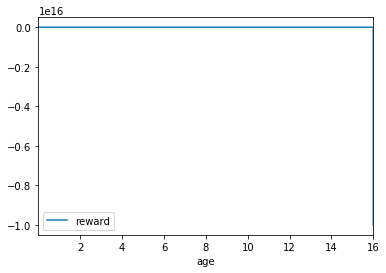

In [10]:
df.plot('age', 'reward')
plt.ylim((-100, 100))

In [ ]:
env.envs[0].action_space.high[2]